<pre style="color:#D00000;text-align:center;font-size:150%;font-weight:bold;font-family:Helvetica;background-color:#F9E4D0;border-style: solid;  border-color: coral; border-width: 1px;">
BikeRental Analysis & Prediction
</pre>

 Domain Perspective

- Industry:  
  This project is positioned within the urban mobility sector, specifically focusing on bike-sharing systems. These systems are part of a broader movement towards sustainable transportation, offering an automated solution for bike rental and return processes. The insights gained from this project can help operators optimize station placements, improve bike availability, and adjust pricing to enhance service utilization.

- Problem Statement:  
  The main objective is to analyze bike-sharing data that includes detailed logs of bike rentals influenced by various environmental and seasonal factors. By modeling and predicting daily bike rental counts, operators can better understand demand patterns and make informed decisions to improve operational efficiency and customer satisfaction.

- Objectives:  
  The project includes several key tasks:
  1. Data Analysis Report: Conduct a comprehensive exploration of how different factors, such as weather conditions and day types (weekdays/weekends), affect bike rental counts.
  2. Predictive Modeling: Develop and evaluate multiple predictive models to forecast daily bike rental counts based on the available data.
  3. Reporting: Generate a Model Comparison Report detailing the performance of the evaluated models and a Challenges Report to document the issues faced during the analysis, including the solutions used to address them.

 Data Perspective

- Data Source:  
  The dataset is derived from the Capital Bikeshare system in Washington D.C., enriched with weather and seasonal information. It includes data from the years 2011 and 2012, providing a robust framework for understanding the dynamics of bike rentals.

- Variables:  
  The dataset includes attributes like:
  - Temporal Data: Date, season, year, month, hour of the day, and whether the day is a holiday or a working day.
  - Weather Conditions: Temperature (actual and feeling), humidity, and wind speed, all normalized to specific scales.
  - Rental Data: Counts of casual and registered users and total bike rentals (the sum of casual and registered users).

- Target Variable:  
  The primary target variable is the total count of rented bikes (cnt), which aggregates the counts of both casual and registered users. This variable helps in understanding the overall demand for bike rentals on any given day or hour.

- Input Variables:  
  All the other attributes in the dataset function as input variables. These include time-related variables (like hour, day, month), environmental conditions (such as temperature and weather situation), and operational settings (e.g., holiday, working day), which together influence the total bike rental counts.
  All the other attributes in the dataset function as input variables. These include time-related variables (like hour, day, month), environmental conditions (such as temperature and weather situation), and operational settings (e.g., holiday, working day), which together influence the total bike rental counts.

---

# Data Analysis

### Import data

In [1]:
import pandas as pd
day = pd.read_csv(r'D:\datamites\BikeRental\data\1.1 raw\day.csv')
hr = pd.read_csv(r'D:\datamites\BikeRental\data\1.1 raw\hour.csv')

In [2]:
from tabulate import tabulate
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

### Imports & functions

In [3]:
from insightfulpy.eda import *

In [4]:
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy import stats
from scipy.stats import (
    chi2_contingency, fisher_exact, pearsonr, spearmanr,
    ttest_ind, mannwhitneyu, shapiro
)
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, compute_class_weight
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, mean_squared_log_error
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA

import joblib

In [5]:
import psutil
import os
import gc

def memory_usage():
    """Prints the current memory usage of the Python process."""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / 1024 ** 2:.2f} MB")

def dataframe_memory_usage(df):
    """Returns the memory usage of a Pandas DataFrame in MB."""
    mem_usage = df.memory_usage(deep=True).sum() / 1024 ** 2
    print(f"DataFrame Memory Usage: {mem_usage:.2f} MB")
    return mem_usage

def garbage_collection():
    """Performs garbage collection to free up memory."""
    gc.collect()
    memory_usage()

---

In [6]:
def normality_test_with_skew_kurt(df):
    normal_cols = []
    not_normal_cols = []
    for col in df.select_dtypes(include=[np.number]).columns:
        col_data = df[col].dropna()
        if len(col_data) >= 3:
            if len(col_data) <= 5000:
                stat, p_value = shapiro(col_data)
                test_used = 'Shapiro-Wilk'
            else:
                stat, p_value = kstest(col_data, 'norm', args=(col_data.mean(), col_data.std()))
                test_used = 'Kolmogorov-Smirnov'
            col_skewness = skew(col_data)
            col_kurtosis = kurtosis(col_data)
            result = {
                'Column': col,
                'Test': test_used,
                'Statistic': stat,
                'p_value': p_value,
                'Skewness': col_skewness,
                'Kurtosis': col_kurtosis
            }
            if p_value > 0.05:
                normal_cols.append(result)
            else:
                not_normal_cols.append(result)
    normal_df = (
        pd.DataFrame(normal_cols)
        .sort_values(by='Column') 
        if normal_cols else pd.DataFrame(columns=['Column', 'Test', 'Statistic', 'p_value', 'Skewness', 'Kurtosis'])
    )
    not_normal_df = (
        pd.DataFrame(not_normal_cols)
        .sort_values(by='p_value', ascending=False)  # Sort by p-value descending (near normal to not normal)
        if not_normal_cols else pd.DataFrame(columns=['Column', 'Test', 'Statistic', 'p_value', 'Skewness', 'Kurtosis'])
    )
    print("\nNormal Columns (p > 0.05):")
    display(normal_df)
    print("\nNot Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:")
    display(not_normal_df)
    return normal_df, not_normal_df
def spearman_correlation_with_target(data, non_normal_cols, target_col='TARGET', plot=True, table=True):
    if not pd.api.types.is_numeric_dtype(data[target_col]):
        raise ValueError(f"Target column '{target_col}' must be numeric. Please encode it before running this test.")
    correlation_results = {}
    for col in non_normal_cols:
        if col not in data.columns:
            continue 
        coef, p_value = spearmanr(data[col], data[target_col], nan_policy='omit')
        correlation_results[col] = {'Spearman Coefficient': coef, 'p-value': p_value}
    correlation_data = pd.DataFrame(correlation_results).T.dropna()
    correlation_data = correlation_data.sort_values('Spearman Coefficient', ascending=False)
    if target_col in correlation_data.index:
        correlation_data = correlation_data.drop(target_col)
    positive_corr = correlation_data[correlation_data['Spearman Coefficient'] > 0]
    negative_corr = correlation_data[correlation_data['Spearman Coefficient'] < 0]
    if table:
        print(f"\nPositive Spearman Correlations with Target ('{target_col}'):\n")
        for feature, stats in positive_corr.iterrows():
            print(f"- {feature}: Correlation={stats['Spearman Coefficient']:.4f}, p-value={stats['p-value']:.4f}")
        print(f"\nNegative Spearman Correlations with Target ('{target_col}'):\n")
        for feature, stats in negative_corr.iterrows():
            print(f"- {feature}: Correlation={stats['Spearman Coefficient']:.4f}, p-value={stats['p-value']:.4f}")
    if plot:
        plt.figure(figsize=(20, 8))  # Increase figure width to prevent label overlap
        sns.barplot(x=correlation_data.index, y='Spearman Coefficient', data=correlation_data, palette='coolwarm')
        plt.axhline(0, color='black', linestyle='--')
        plt.title(f"Spearman Correlation with Target ('{target_col}')", fontsize=16)
        plt.xlabel("Features", fontsize=14)
        plt.ylabel("Spearman Coefficient", fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for clarity
        plt.subplots_adjust(bottom=0.3)  # Add space below the plot for labels
        plt.tight_layout()
        plt.show()
    return correlation_data
def spearman_correlation(data, non_normal_cols, exclude_target=None, multicollinearity_threshold=0.8):
    if non_normal_cols.empty:
        print("\nNo non-normally distributed numerical columns found. Exiting Spearman Correlation.")
        return
    selected_columns = non_normal_cols['Column'].tolist()
    if exclude_target and exclude_target in selected_columns and pd.api.types.is_numeric_dtype(data[exclude_target]):
        selected_columns.remove(exclude_target)
    spearman_corr_matrix = data[selected_columns].corr(method='spearman')
    multicollinear_pairs = []
    for i, col1 in enumerate(selected_columns):
        for col2 in selected_columns[i+1:]:
            coef = spearman_corr_matrix.loc[col1, col2]
            if abs(coef) > multicollinearity_threshold:
                multicollinear_pairs.append((col1, col2, coef))
    print("\nVariables Exhibiting Multicollinearity (|Correlation| > {:.2f}):".format(multicollinearity_threshold))
    if multicollinear_pairs:
        for col1, col2, coef in multicollinear_pairs:
            print(f"- {col1} & {col2}: Correlation={coef:.4f}")
    else:
        print("No multicollinear pairs found.")
    annot_matrix = spearman_corr_matrix.round(2).astype(str)
    num_vars = len(selected_columns)
    fig_size = max(min(24, num_vars * 1.2), 10)  # Keep reasonable bounds
    annot_font_size = max(min(10, 200 / num_vars), 6)  # Smaller font for more variables
    plt.figure(figsize=(fig_size, fig_size * 0.75))
    sns.heatmap(
        spearman_corr_matrix,
        annot=annot_matrix,
        fmt='',
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        annot_kws={"size": annot_font_size},
        cbar_kws={"shrink": 0.8}
    )
    plt.title('Spearman Correlation Matrix', fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()
def calculate_vif(data, exclude_target='TARGET', multicollinearity_threshold=5.0):
    # Select only numeric columns, exclude target, and drop rows with missing values
    numeric_data = data.select_dtypes(include=[np.number]).drop(columns=[exclude_target], errors='ignore').dropna()
    vif_data = pd.DataFrame()
    vif_data['Feature'] = numeric_data.columns
    vif_data['VIF'] = [variance_inflation_factor(numeric_data.values, i) 
                       for i in range(numeric_data.shape[1])]
    vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
    high_vif = vif_data[vif_data['VIF'] > multicollinearity_threshold]
    low_vif = vif_data[vif_data['VIF'] <= multicollinearity_threshold]
    print(f"\nVariance Inflation Factor (VIF) Scores (multicollinearity_threshold = {multicollinearity_threshold}):")
    print("\nFeatures with VIF > threshold (High Multicollinearity):")
    if not high_vif.empty:
        print(high_vif.to_string(index=False))
    else:
        print("None. No features exceed the VIF threshold.")
    print("\nFeatures with VIF <= threshold (Low/No Multicollinearity):")
    if not low_vif.empty:
        print(low_vif.to_string(index=False))
    else:
        print("None. All features exceed the VIF threshold.")
    return vif_data, high_vif['Feature'].tolist()

---

In [7]:
if __name__ == "__main__":
    memory_usage()

Memory Usage: 284.53 MB


In [8]:
dataframe_memory_usage(day)

DataFrame Memory Usage: 0.13 MB


0.13049030303955078

In [9]:
dataframe_memory_usage(hr)

DataFrame Memory Usage: 3.23 MB


3.2320375442504883

---

## Data understanding 

In [10]:
dataframes = {
    'day': day,
    'hr': hr,
}

In [11]:
linked_key(dataframes)

Dataset   Rows  Columns  Missing Values  Missing %  Negative Values  \
0     day    731       16               0        0.0                0   
1      hr  17379       17               0        0.0                0   
2   Total  18110       33               0        0.0                0   

   Negative %  Outliers  Outlier %                        Data Types  
0         0.0        80       0.68  int64: 11, float64: 4, object: 1  
1         0.0      3244       1.10  int64: 12, float64: 4, object: 1  
2         0.0      3324       1.08  int64: 23, float64: 8, object: 2


### Link Columns (Common Columns Across DataFrames):

- instant: day, hr
- dteday: day, hr
- season: day, hr
- yr: day, hr
- mnth: day, hr
- holiday: day, hr
- weekday: day, hr
- workingday: day, hr
- weathersit: day, hr
- temp: day, hr
- atemp: day, hr
- hum: day, hr
- windspeed: day, hr
- casual: day, hr
- registered: day, hr
- cnt: day, hr


---

The memory usage for the project is recorded at 284.28 MB, with the day and hr dataframes using 0.13 MB and 3.23 MB, respectively. These datasets, which share key columns, are analyzed for bike rental patterns across daily and hourly intervals. Both are well-maintained with no missing values and contain a small percentage of outliers, making them suitable for detailed analyses to predict bike rental trends based on environmental and seasonal settings.

### day

In [12]:
print(day.shape)
for idx, col in enumerate(day.columns):
        print(f"{idx}: {col}")

(731, 16)
0: instant
1: dteday
2: season
3: yr
4: mnth
5: holiday
6: weekday
7: workingday
8: weathersit
9: temp
10: atemp
11: hum
12: windspeed
13: casual
14: registered
15: cnt


In [13]:
day.head().T

0           1           2           3           4
instant              1           2           3           4           5
dteday      2011-01-01  2011-01-02  2011-01-03  2011-01-04  2011-01-05
season               1           1           1           1           1
yr                   0           0           0           0           0
mnth                 1           1           1           1           1
holiday              0           0           0           0           0
weekday              6           0           1           2           3
workingday           0           0           1           1           1
weathersit           2           2           1           1           1
temp          0.344167    0.363478    0.196364         0.2    0.226957
atemp         0.363625    0.353739    0.189405    0.212122     0.22927
hum           0.805833    0.696087    0.437273    0.590435    0.436957
windspeed     0.160446    0.248539    0.248309    0.160296      0.1869
casual             331         131         120         108          82
registered         654         670        1229        1454        1518
cnt                985         801        1349        1562        1600

In [14]:
detect_mixed_data_types(day)

'No mixed data types detected!'

In [15]:
cat_high_cardinality(day)

high_cardinality_columns


['dteday']

In [16]:
missing_inf_values(day)
print(f"\nNumber of duplicate rows: {day.duplicated().sum()}\n")
duplicates = day[day.duplicated()]
duplicates

Missing Values Summary:
No missing values found.

Infinite Values Summary:
No infinite values found.

Number of duplicate rows: 0



Empty DataFrame
Columns: [instant, dteday, season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt]
Index: []

In [17]:
inf_counts = np.isinf(day.select_dtypes(include=[np.number])).sum().sum()
print(f"Total Inf values: {inf_counts}")

Total Inf values: 0


In [18]:
day.dtypes.value_counts()

int64      11
float64     4
object      1
Name: count, dtype: int64

In [19]:
columns_info("dayset Overview", day)


======== dayset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     9          temp                           float64         0.0591304 - 0.861667           499
2     10         atemp                          float64         0.0790696 - 0.840896           690
3     11         hum                            float64         0.0 - 0.9725                   595
4     12         windspeed                      float64         0.0223917 - 0.507463           650
5     0          instant                        int64           1 - 731                        731
6     2          season                         int64           1 - 4                          4
7     3          yr                             int64           0 - 1                          2
8     4          mnth                           in

In [20]:
analyze_data(day)































=== Numerical Analysis ===
|    | Variable   |   N |      Mean |        SD |      SE |   95% Conf. |   Interval |
|---:|:-----------|----:|----------:|----------:|--------:|------------:|-----------:|
|  0 | instant    | 731 |  366      |  211.166  |  7.8102 |    350.667  |   381.333  |
|  1 | season     | 731 |    2.4966 |    1.1108 |  0.0411 |      2.4159 |     2.5772 |
|  2 | yr         | 731 |    0.5007 |    0.5003 |  0.0185 |      0.4644 |     0.537  |
|  3 | mnth       | 731 |    6.5198 |    3.4519 |  0.1277 |      6.2692 |     6.7705 |
|  4 | holiday    | 731 |    0.0287 |    0.1672 |  0.0062 |      0.0166 |     0.0409 |
|  5 | weekday    | 731 |    2.9973 |    2.0048 |  0.0741 |      2.8517 |     3.1428 |
|  6 | workingday | 731 |    0.684  |    0.4652 |  0.0172 |      0.6502 |     0.7178 |
|  7 | weathersit | 731 |    1.3953 |    0.5449 |  0.0202 |      1.3558 |     1.4349 |
|  8 | temp       | 731 |    0.4954 |    0.1831 |  0.0068 |      0.4821 |

Missing Values Summary:
No missing values found.

Infinite Values Summary:
No infinite values found.


<Figure size 2000x800 with 0 Axes>

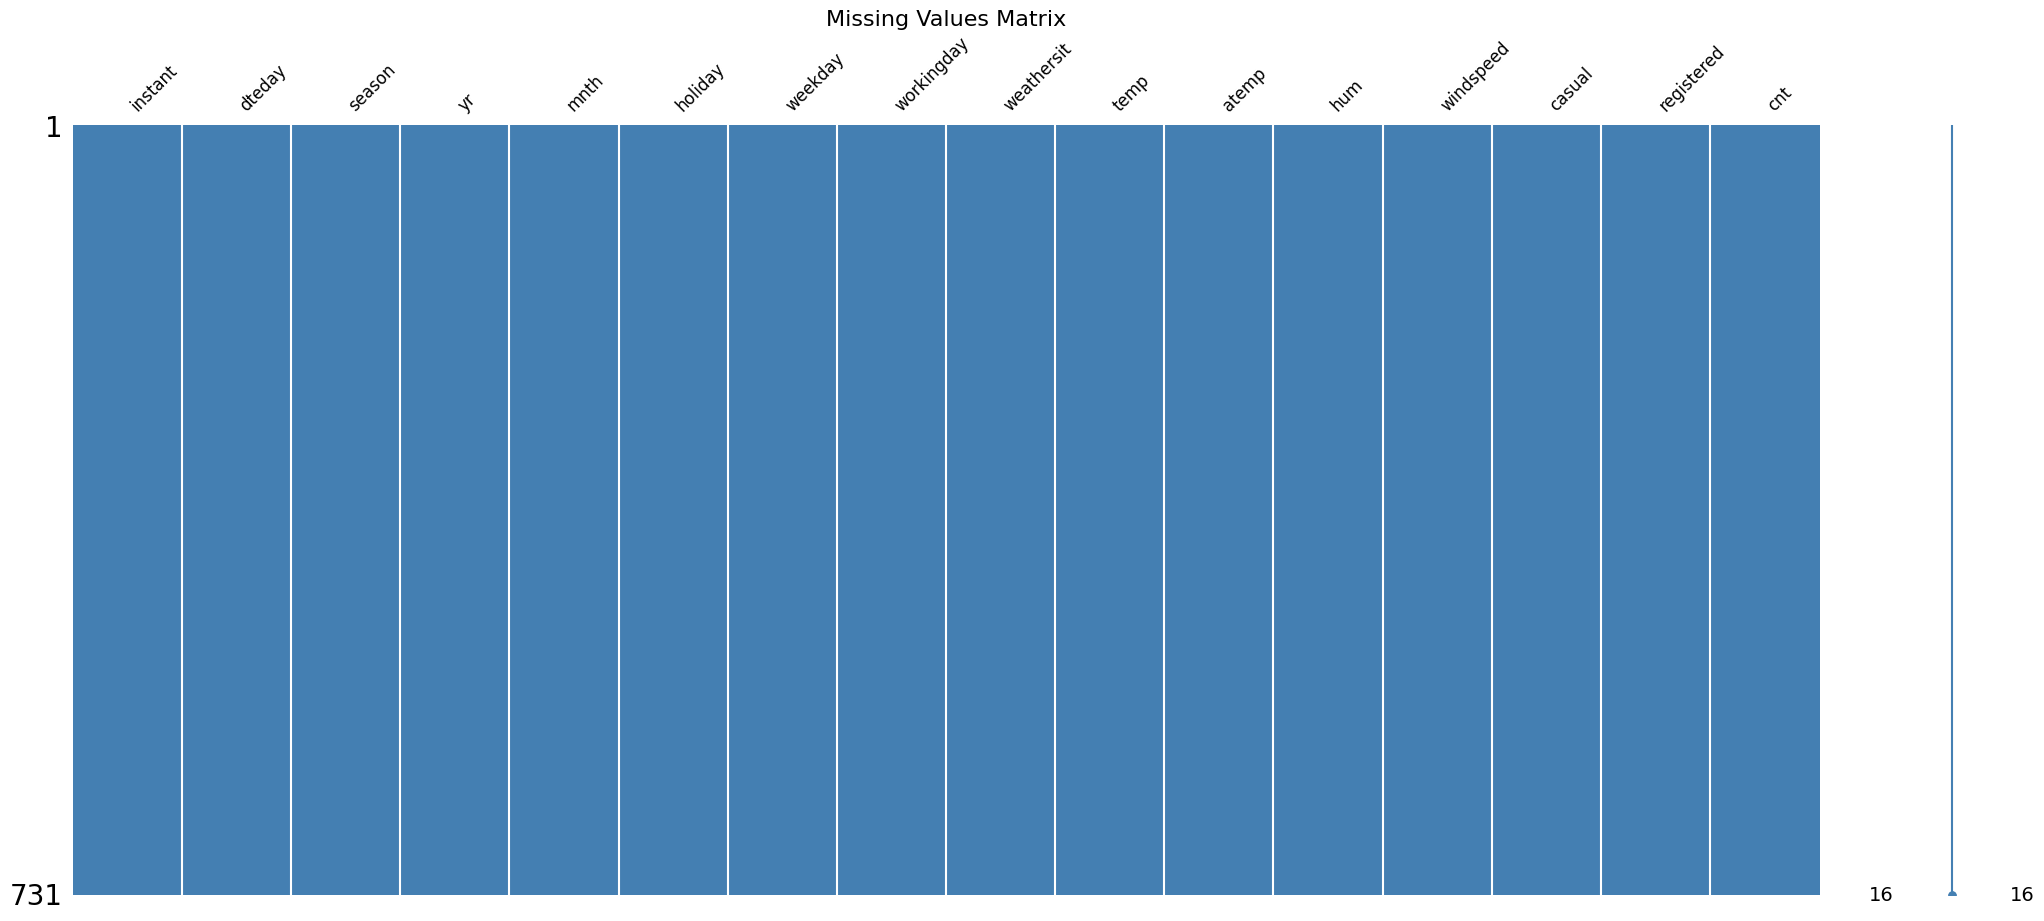

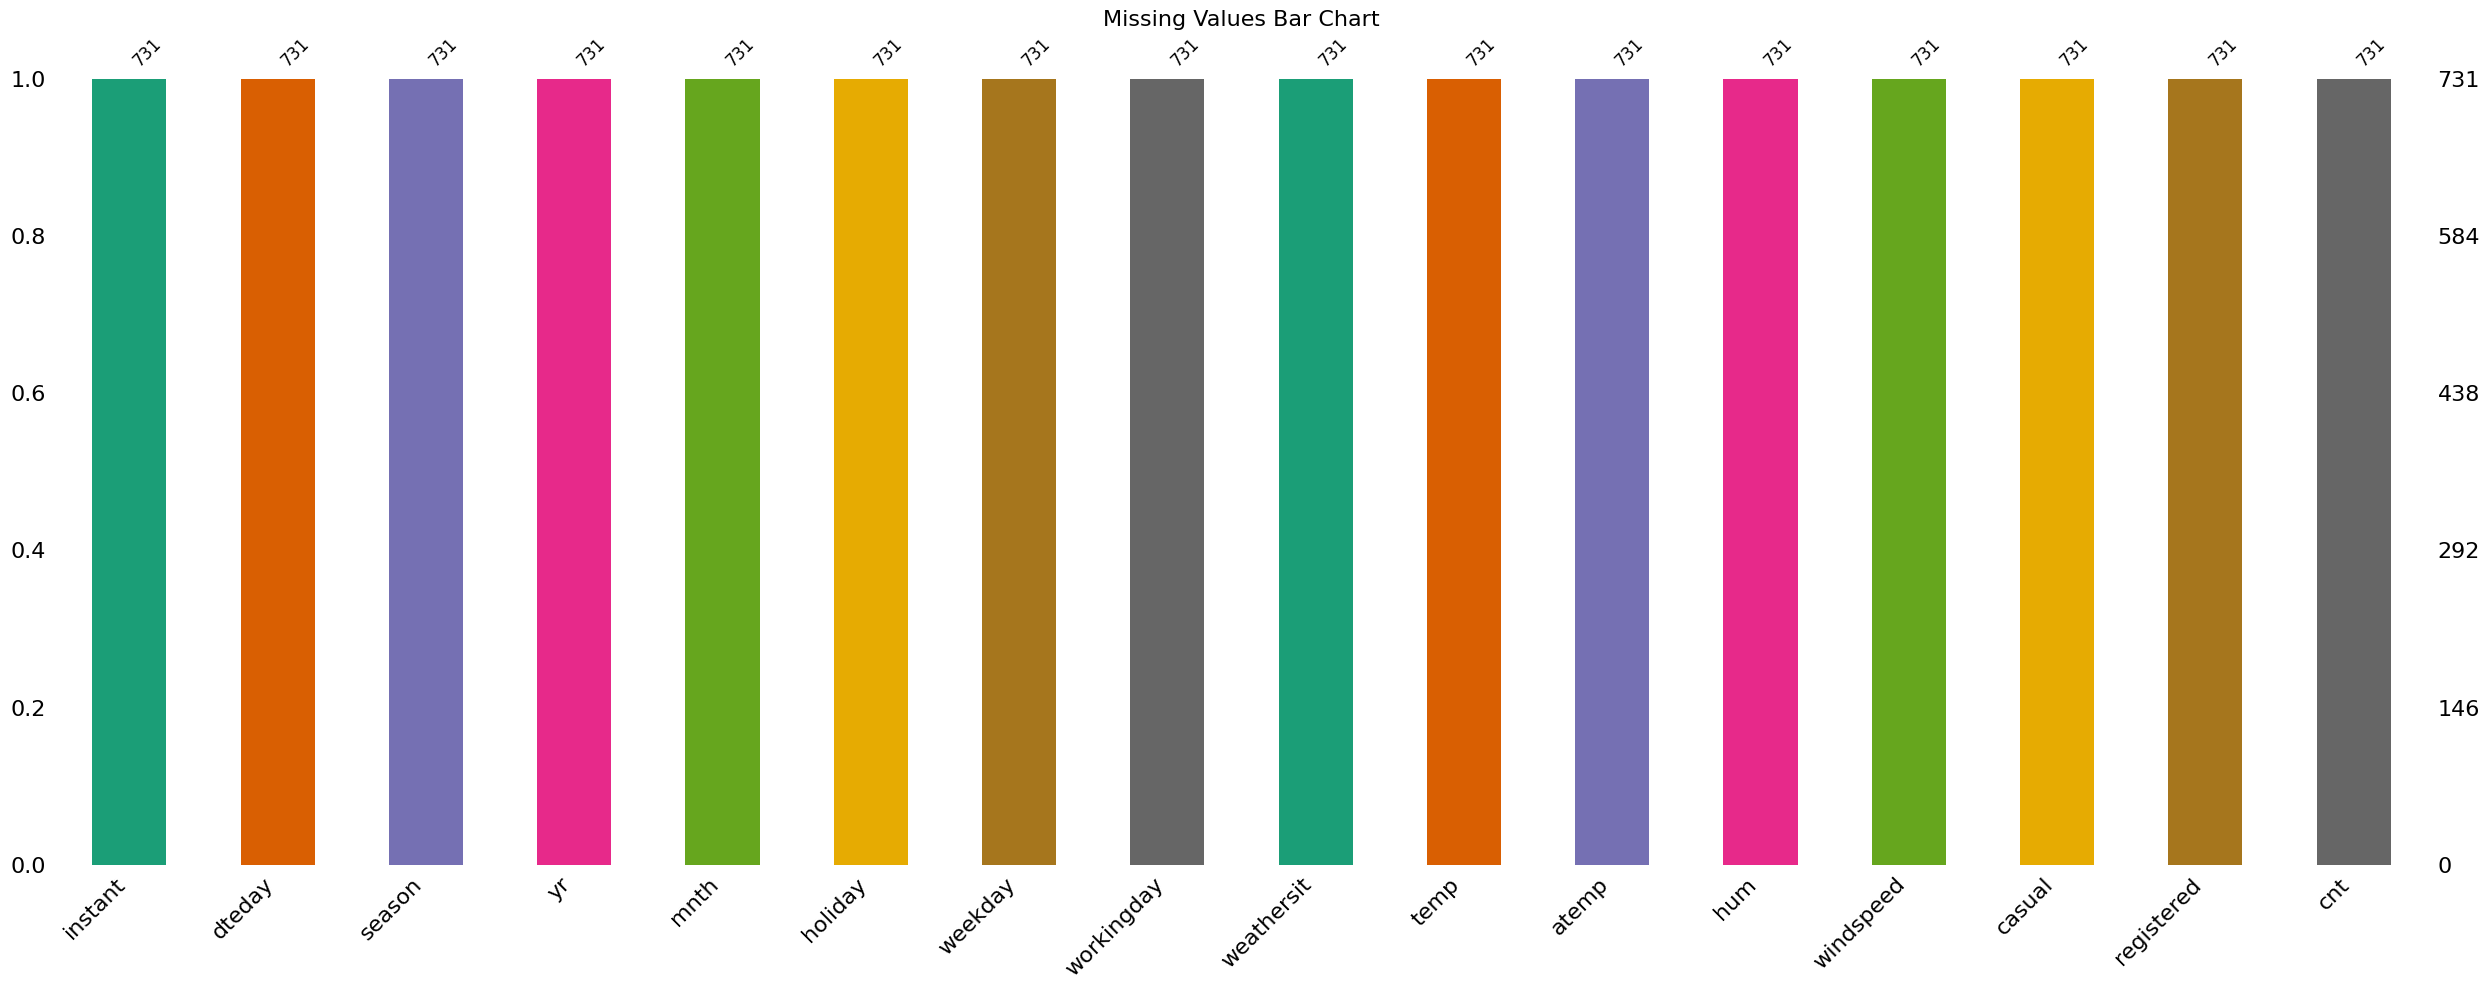


Number of duplicate rows: 0



Empty DataFrame
Columns: [instant, dteday, season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt]
Index: []

In [21]:
missing_inf_values(day)
show_missing(day)
print(f"\nNumber of duplicate rows: {day.duplicated().sum()}\n")
duplicates = day[day.duplicated()]
duplicates

The dataset named day consists of 731 entries and 16 columns, representing various attributes of daily bike rentals such as the date, season, weather conditions, and counts of casual and registered users. The dataframe exhibits a range of numerical and categorical data types, with most numeric data normalized for easier analysis. Notably, the column 'dteday' stands out due to its high cardinality, as it uniquely identifies each day in the dataset.

Key statistics for numerical columns like temperature, humidity, and wind speed reflect a wide range of conditions, potentially influencing bike rental behavior. The dataset is clean, with no missing, infinite, or duplicate values detected, ensuring the integrity and usability of the data for analysis. This comprehensive data setup provides a solid foundation for examining trends and patterns in bike usage, crucial for predictive modeling and insights into factors affecting daily rental counts.

---

### hr

In [22]:
for idx, col in enumerate(hr.columns):
        print(f"{idx}: {col}")

0: instant
1: dteday
2: season
3: yr
4: mnth
5: hr
6: holiday
7: weekday
8: workingday
9: weathersit
10: temp
11: atemp
12: hum
13: windspeed
14: casual
15: registered
16: cnt


In [23]:
hr.head().T

0           1           2           3           4
instant              1           2           3           4           5
dteday      2011-01-01  2011-01-01  2011-01-01  2011-01-01  2011-01-01
season               1           1           1           1           1
yr                   0           0           0           0           0
mnth                 1           1           1           1           1
hr                   0           1           2           3           4
holiday              0           0           0           0           0
weekday              6           6           6           6           6
workingday           0           0           0           0           0
weathersit           1           1           1           1           1
temp              0.24        0.22        0.22        0.24        0.24
atemp           0.2879      0.2727      0.2727      0.2879      0.2879
hum               0.81         0.8         0.8        0.75        0.75
windspeed          0.0         0.0         0.0         0.0         0.0
casual               3           8           5           3           0
registered          13          32          27          10           1
cnt                 16          40          32          13           1

In [24]:
detect_mixed_data_types(hr)

'No mixed data types detected!'

In [25]:
cat_high_cardinality(hr)

high_cardinality_columns


['dteday']

In [26]:
missing_inf_values(hr)
print(f"\nNumber of duplicate rows: {hr.duplicated().sum()}\n")
duplicates = hr[hr.duplicated()]
duplicates

Missing Values Summary:
No missing values found.

Infinite Values Summary:
No infinite values found.

Number of duplicate rows: 0



Empty DataFrame
Columns: [instant, dteday, season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt]
Index: []

In [27]:
inf_counts = np.isinf(hr.select_dtypes(include=[np.number])).sum().sum()
print(f"Total Inf values: {inf_counts}")

Total Inf values: 0


In [28]:
hr.dtypes.value_counts()

int64      12
float64     4
object      1
Name: count, dtype: int64

In [29]:
columns_info("hrset Overview", hr)


======== hrset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     10         temp                           float64         0.02 - 1.0                     50
2     11         atemp                          float64         0.0 - 1.0                      65
3     12         hum                            float64         0.0 - 1.0                      89
4     13         windspeed                      float64         0.0 - 0.8507                   30
5     0          instant                        int64           1 - 17379                      17379
6     2          season                         int64           1 - 4                          4
7     3          yr                             int64           0 - 1                          2
8     4          mnth                           int64

In [30]:
analyze_data(hr)

































=== Numerical Analysis ===
|    | Variable   |     N |      Mean |        SD |      SE |   95% Conf. |   Interval |
|---:|:-----------|------:|----------:|----------:|--------:|------------:|-----------:|
|  0 | instant    | 17379 | 8690      | 5017.03   | 38.057  |   8615.4    |  8764.6    |
|  1 | season     | 17379 |    2.5016 |    1.1069 |  0.0084 |      2.4852 |     2.5181 |
|  2 | yr         | 17379 |    0.5026 |    0.5    |  0.0038 |      0.4951 |     0.51   |
|  3 | mnth       | 17379 |    6.5378 |    3.4388 |  0.0261 |      6.4866 |     6.5889 |
|  4 | hr         | 17379 |   11.5468 |    6.9144 |  0.0524 |     11.4439 |    11.6496 |
|  5 | holiday    | 17379 |    0.0288 |    0.1672 |  0.0013 |      0.0263 |     0.0313 |
|  6 | weekday    | 17379 |    3.0037 |    2.0058 |  0.0152 |      2.9739 |     3.0335 |
|  7 | workingday | 17379 |    0.6827 |    0.4654 |  0.0035 |      0.6758 |     0.6896 |
|  8 | weathersit | 17379 |    1.4253 |    0.6394 |

Missing Values Summary:
No missing values found.

Infinite Values Summary:
No infinite values found.


<Figure size 2000x800 with 0 Axes>

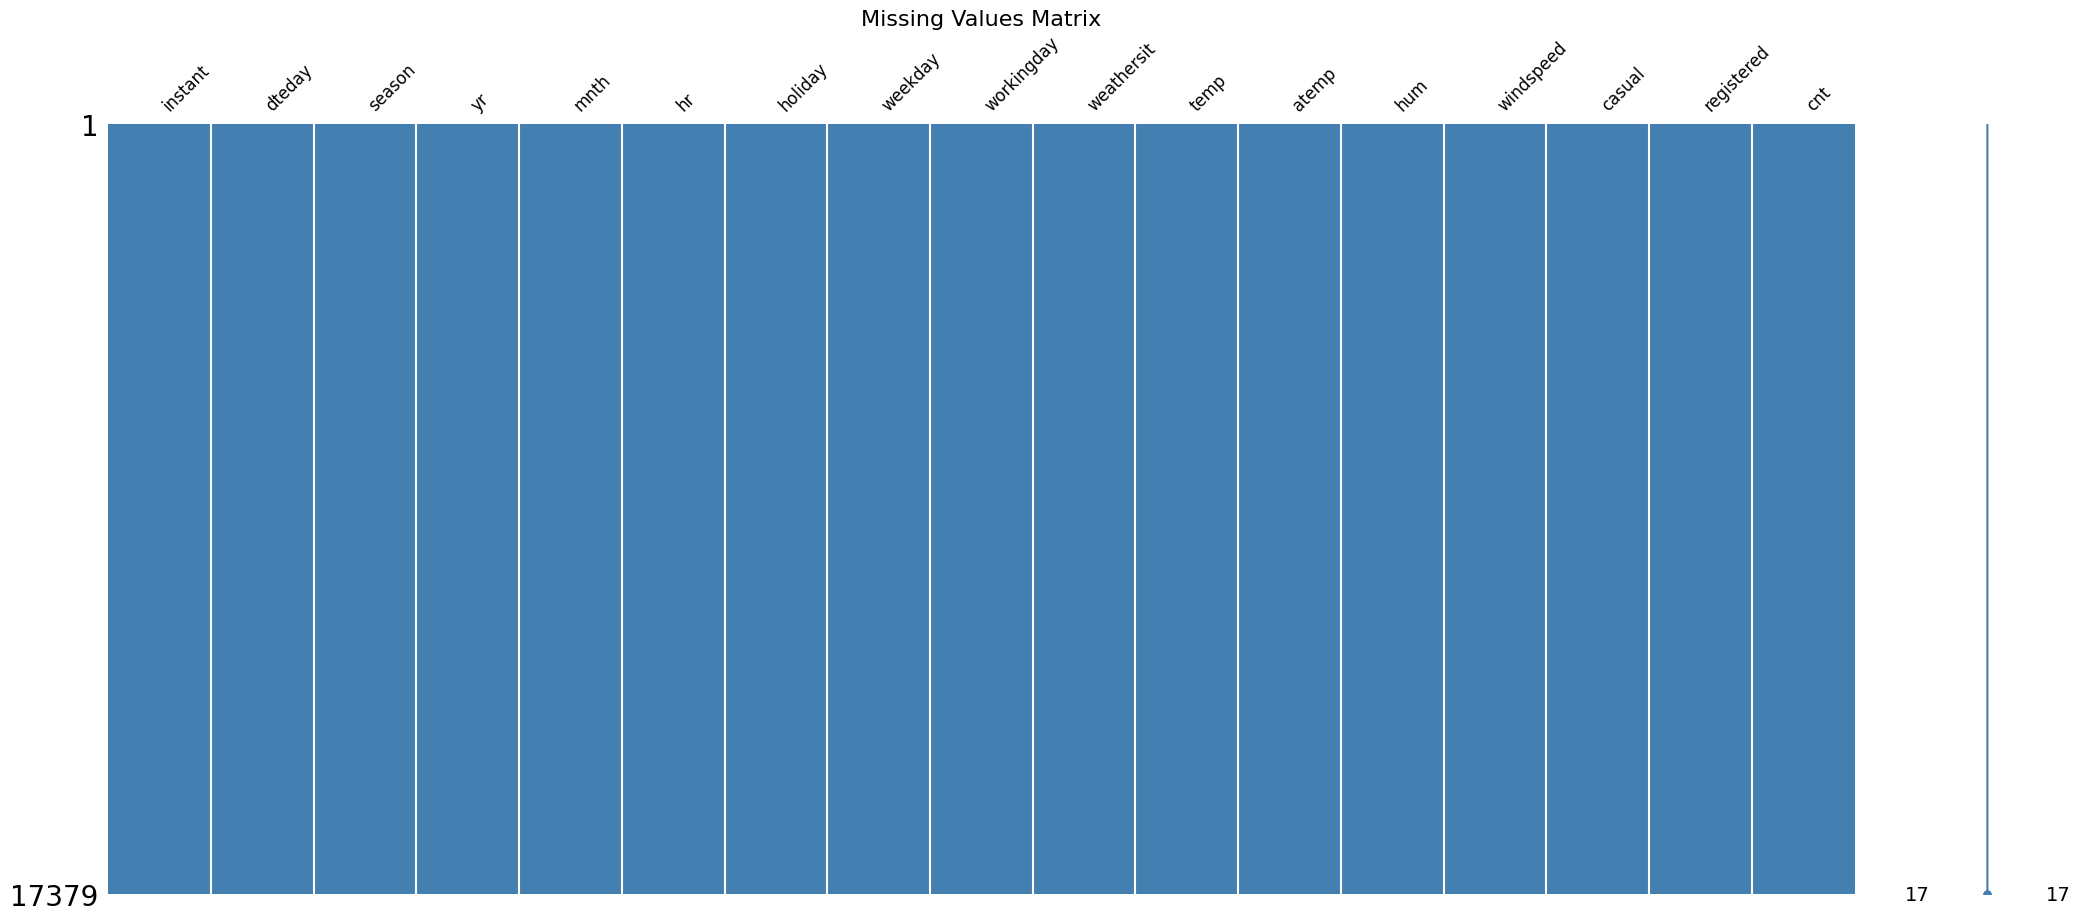

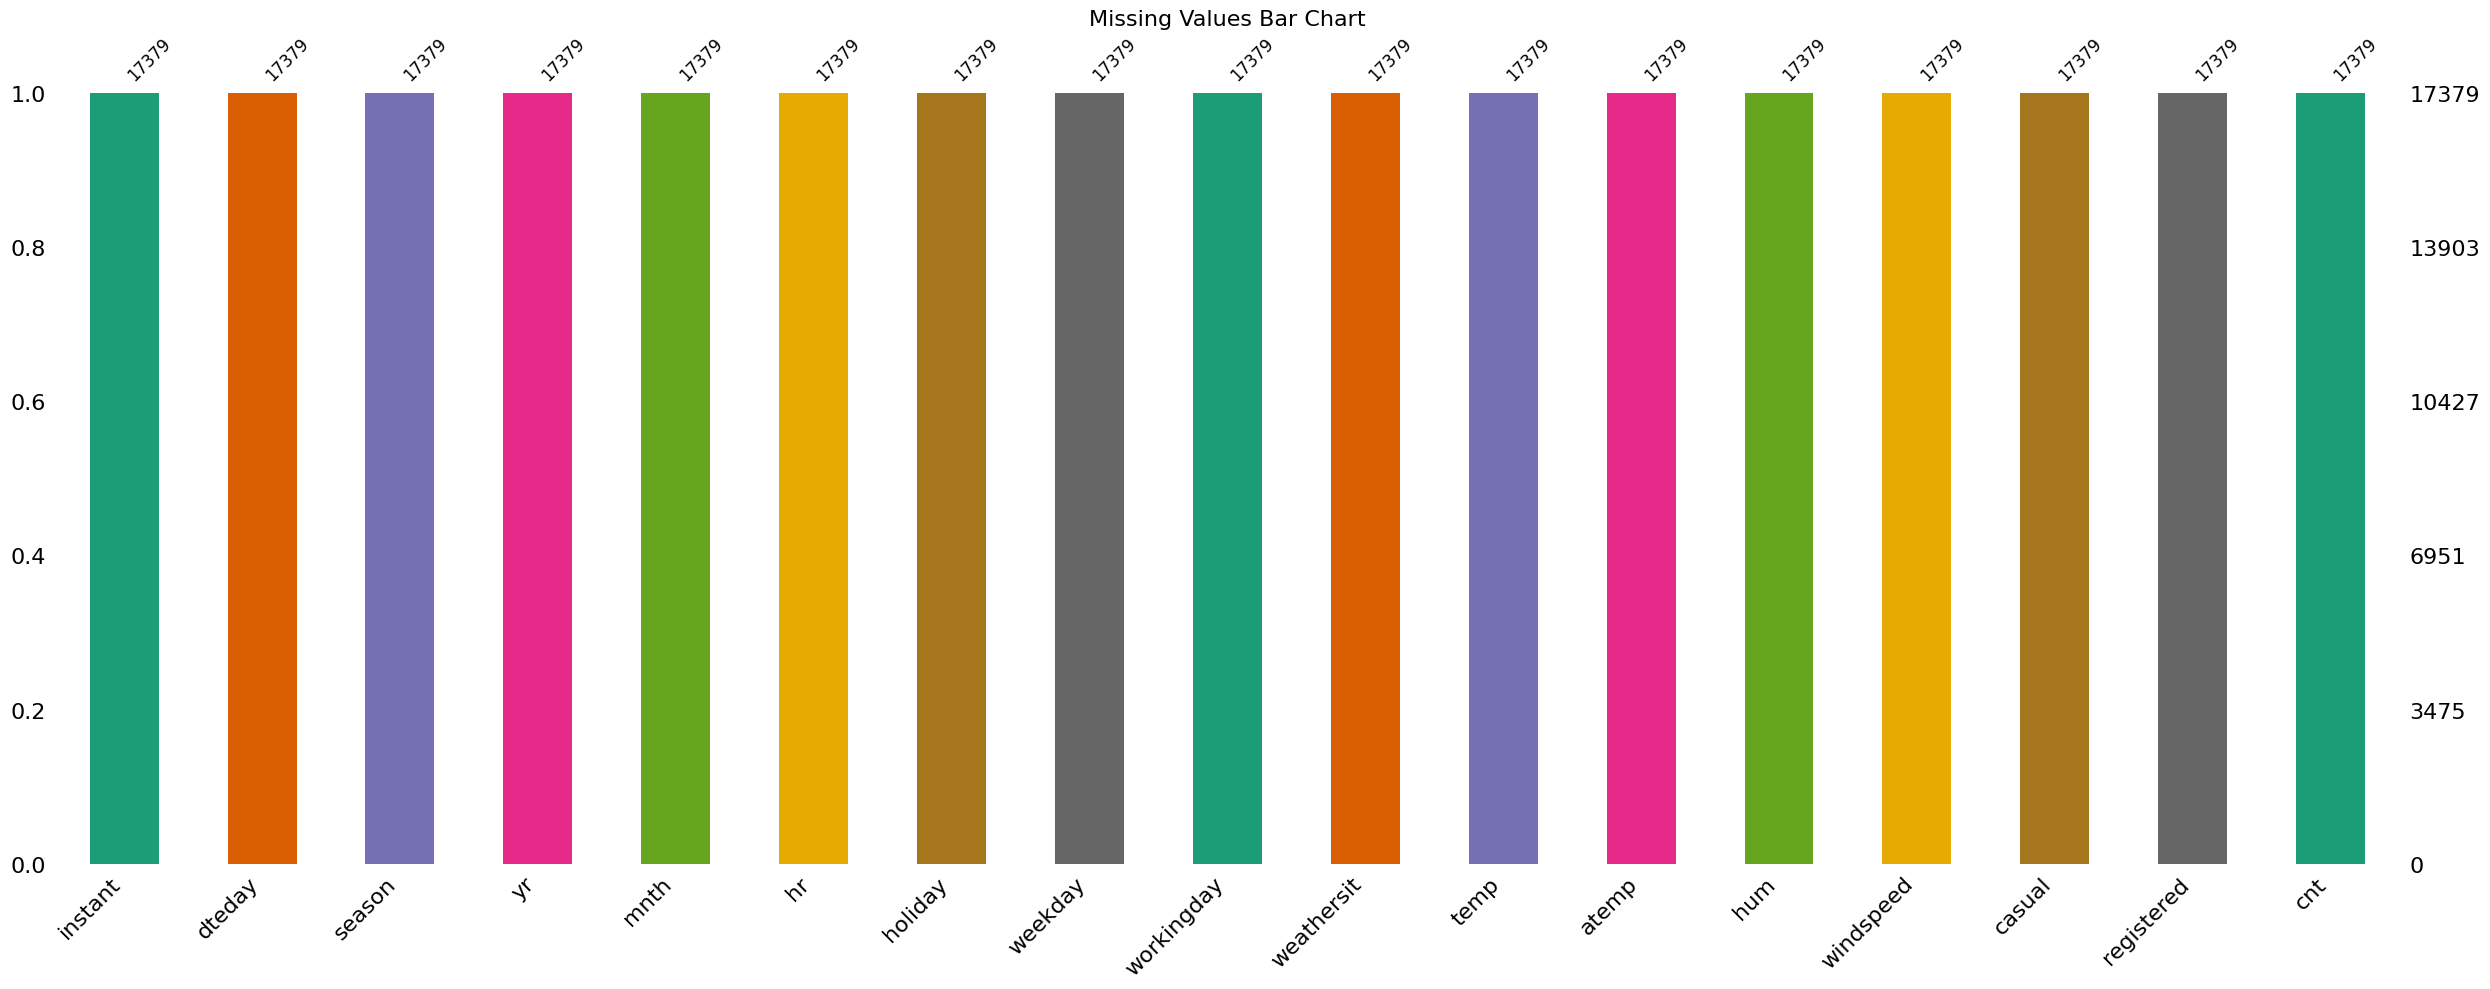


Number of duplicate rows: 0



Empty DataFrame
Columns: [instant, dteday, season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt]
Index: []

In [31]:
missing_inf_values(hr)
show_missing(hr)
print(f"\nNumber of duplicate rows: {hr.duplicated().sum()}\n")
duplicates = hr[hr.duplicated()]
duplicates

The hr dataset details hourly bike rental records with 17,379 entries across 17 attributes. This dataset captures an array of variables such as the date, season, specific hour of the day, weather conditions, temperature, humidity, and counts of casual and registered users each hour. Like the day dataset, hr is noted for its clean data quality, showing no missing or infinite values and zero duplicates, indicating thorough data collection and preprocessing.

Significant characteristics of this dataset include its ability to provide insights into the hourly fluctuations in bike rental activity, which are crucial for understanding user behavior in finer temporal granularity. The continuous variables like temperature and humidity are presented in normalized form, enhancing the dataset's utility for modeling environmental impacts on rental trends. The high cardinality of the 'dteday' column, shared with the day dataset, underlines its importance in linking these two datasets for comprehensive temporal analysis, from daily summaries to hourly details. This structure is instrumental for predictive modeling, where understanding the interplay of various factors at different times of the day can lead to more accurate demand forecasting in bike-sharing systems.

---

### final_data 

In [32]:
hr['dteday'] = pd.to_datetime(hr['dteday'])
day['dteday'] = pd.to_datetime(day['dteday'])
daily_aggregations = {
    'cnt': 'sum', 
    'casual': 'sum', 
    'registered': 'sum', 
    'temp': 'mean',  
    'atemp': 'mean',  
    'hum': 'mean',  
    'windspeed': 'mean',  
    'weathersit': lambda data: data.mode()[0] if not data.mode().empty else None  
}
aggregated_hourly_data = hr.groupby('dteday').agg(daily_aggregations).reset_index()
columns_to_use = aggregated_hourly_data.columns.difference(day.columns).tolist()
columns_to_use.append('dteday')
data = pd.merge(day, aggregated_hourly_data[columns_to_use], on='dteday', how='left')

In [33]:
print("Hourly Data Info:")
print(hr.info())
print("\nDaily Data Info:")
print(day.info())
print("\nMerged Data Info:")
print(data.info())
print("\nDuplicate Check:")
print("Hourly Data duplicates:", hr.duplicated().sum())
print("Daily Data duplicates:", day.duplicated().sum())
print("Merged Data duplicates:", data.duplicated().sum())
print("\nUnique Days Check:")
print("Unique days in hourly data:", hr['dteday'].nunique())
print("Unique days in daily data:", day['dteday'].nunique())
print("Unique days in merged data:", data['dteday'].nunique())
expected_columns = ['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
                    'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
                    'casual', 'registered', 'cnt']
print("\nColumns in Merged Data:")
print(data.columns.tolist())
print("All expected columns in merged data:", all(col in data.columns for col in expected_columns))
print("\nSummary Statistics for Merged Data:")
print(data.describe())
print("\nData Anomalies Check:")
print("Negative or zero counts in merged data:")
print(data[data['cnt'] <= 0][['dteday', 'cnt']])

Hourly Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt 

The operations performed involve converting the 'dteday' columns in both the hr and day datasets to datetime format for consistency, aggregating the hourly data to create daily summaries, and merging these with the existing daily records. This results in a comprehensive dataset that combines detailed hourly data with summarized daily metrics, such as user counts and weather conditions. The merged data is thoroughly checked and confirmed to have no missing values, duplicates, or anomalies. It maintains the integrity of the original datasets and enriches the daily records with additional insights from hourly variations, making it valuable for in-depth analysis and predictive modeling of bike rental patterns based on environmental and temporal factors.

In [34]:
print(data.shape)
for idx, col in enumerate(data.columns):
        print(f"{idx}: {col}")

(731, 16)
0: instant
1: dteday
2: season
3: yr
4: mnth
5: holiday
6: weekday
7: workingday
8: weathersit
9: temp
10: atemp
11: hum
12: windspeed
13: casual
14: registered
15: cnt


In [35]:
data.head().T

0                    1                    2  \
instant                       1                    2                    3   
dteday      2011-01-01 00:00:00  2011-01-02 00:00:00  2011-01-03 00:00:00   
season                        1                    1                    1   
yr                            0                    0                    0   
mnth                          1                    1                    1   
holiday                       0                    0                    0   
weekday                       6                    0                    1   
workingday                    0                    0                    1   
weathersit                    2                    2                    1   
temp                   0.344167             0.363478             0.196364   
atemp                  0.363625             0.353739             0.189405   
hum                    0.805833             0.696087             0.437273   
windspeed              0.160446             0.248539             0.248309   
casual                      331                  131                  120   
registered                  654                  670                 1229   
cnt                         985                  801                 1349   

                              3                    4  
instant                       4                    5  
dteday      2011-01-04 00:00:00  2011-01-05 00:00:00  
season                        1                    1  
yr                            0                    0  
mnth                          1                    1  
holiday                       0                    0  
weekday                       2                    3  
workingday                    1                    1  
weathersit                    1                    1  
temp                        0.2             0.226957  
atemp                  0.212122              0.22927  
hum                    0.590435             0.436957  
windspeed              0.160296               0.1869  
casual                      108                   82  
registered                 1454                 1518  
cnt                        1562                 1600

In [36]:
detect_mixed_data_types(data)

'No mixed data types detected!'

In [37]:
cat_high_cardinality(data)

high_cardinality_columns


[]

In [38]:
missing_inf_values(data)
print(f"\nNumber of duplicate rows: {data.duplicated().sum()}\n")
duplicates = data[data.duplicated()]
duplicates

Missing Values Summary:
No missing values found.

Infinite Values Summary:
No infinite values found.

Number of duplicate rows: 0



Empty DataFrame
Columns: [instant, dteday, season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt]
Index: []

In [39]:
inf_counts = np.isinf(data.select_dtypes(include=[np.number])).sum().sum()
print(f"Total Inf values: {inf_counts}")

Total Inf values: 0


In [40]:
data.dtypes.value_counts()

int64             11
float64            4
datetime64[ns]     1
Name: count, dtype: int64

In [41]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     1          dteday                         datetime64[ns]  N/A                            731
2     9          temp                           float64         0.0591304 - 0.861667           499
3     10         atemp                          float64         0.0790696 - 0.840896           690
4     11         hum                            float64         0.0 - 0.9725                   595
5     12         windspeed                      float64         0.0223917 - 0.507463           650
6     0          instant                        int64           1 - 731                        731
7     2          season                         int64           1 - 4                          4
8     3          yr                            

In [42]:
analyze_data(data)































=== Numerical Analysis ===
|    | Variable   |   N |      Mean |        SD |      SE |   95% Conf. |   Interval |
|---:|:-----------|----:|----------:|----------:|--------:|------------:|-----------:|
|  0 | instant    | 731 |  366      |  211.166  |  7.8102 |    350.667  |   381.333  |
|  1 | season     | 731 |    2.4966 |    1.1108 |  0.0411 |      2.4159 |     2.5772 |
|  2 | yr         | 731 |    0.5007 |    0.5003 |  0.0185 |      0.4644 |     0.537  |
|  3 | mnth       | 731 |    6.5198 |    3.4519 |  0.1277 |      6.2692 |     6.7705 |
|  4 | holiday    | 731 |    0.0287 |    0.1672 |  0.0062 |      0.0166 |     0.0409 |
|  5 | weekday    | 731 |    2.9973 |    2.0048 |  0.0741 |      2.8517 |     3.1428 |
|  6 | workingday | 731 |    0.684  |    0.4652 |  0.0172 |      0.6502 |     0.7178 |
|  7 | weathersit | 731 |    1.3953 |    0.5449 |  0.0202 |      1.3558 |     1.4349 |
|  8 | temp       | 731 |    0.4954 |    0.1831 |  0.0068 |      0.4821 |

In [43]:
categorical_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
for column in categorical_columns:
    data[column] = data[column].astype('category')

In [44]:
data.drop(columns=['instant'], inplace=True)

In [45]:
data.drop(columns=['casual', 'registered'], inplace=True)

reason:

- casual: Count of casual (non-registered) users.
- registered: Count of registered users.
- cnt: Total count of rentals (cnt = casual + registered).

This merged dataset encapsulates view of bike rentals, detailing daily counts, weather conditions, and user statistics. Each column in the dataset, including 'temp', 'atemp', 'hum', 'windspeed', and user counts like 'casual', 'registered', and total 'cnt', retains numerical integrity with no detected mixed data types, missing values, or infinite values. Notably, the dataset has undergone transformations such as converting certain columns to categorical data types to better reflect their nature and dropping unnecessary columns like 'instant', which serves no analytical purpose post-merge.

The dataset's structure and cleanliness ensure it is primed for advanced analyses, such as time series forecasting or regression modeling, to predict bike rental patterns

---

In [46]:
data_cat_missing_summary, data_cat_non_missing_summary = comp_cat_analysis(data, missing_df=True)
data_missing_summary, data_non_missing_summary = comp_num_analysis(data, missing_df=True)
data_outlier_summary, data_non_outlier_summary = comp_num_analysis(data, outlier_df=True)
print(data_cat_missing_summary.shape)
print(data_missing_summary.shape)
print(data_outlier_summary.shape)

(0, 9)
(0, 31)
(2, 31)


In [47]:
data_outlier_summary

Index     Column DataType  Count  Missing_Percentage  Unique_Count  \
2     10        hum  float64    731                 0.0           595   
3     11  windspeed  float64    731                 0.0           650   

        Min       Q1  50% (Median)        Q3       Max      Mode     Range  \
2  0.000000  0.52000      0.626667  0.730209  0.972500  0.613333  0.972500   
3  0.022392  0.13495      0.180975  0.233214  0.507463  0.106350  0.485071   

        IQR  Lower Bound  Upper Bound  Total Distinct  Outliers Distinct  \
2  0.210209     0.204687     1.045521             595                  2   
3  0.098265    -0.012447     0.380611             650                 13   

   Outliers Count  Outliers %  Negative Count  Negative Distinct  Negative %  \
2               2    0.273598               0                  0         0.0   
3              13    1.778386               0                  0         0.0   

       Mean  Variance       Std  Skewness  Kurtosis Normality Test  \
2  0.627894  0.020286  0.142429 -0.069640 -0.072286   Shapiro-Wilk   
3  0.190486  0.006006  0.077498  0.675955  0.399920   Shapiro-Wilk   

   Normality Statistic  Normality p-value  
2             0.993346       2.482338e-03  
3             0.971232       8.424003e-11

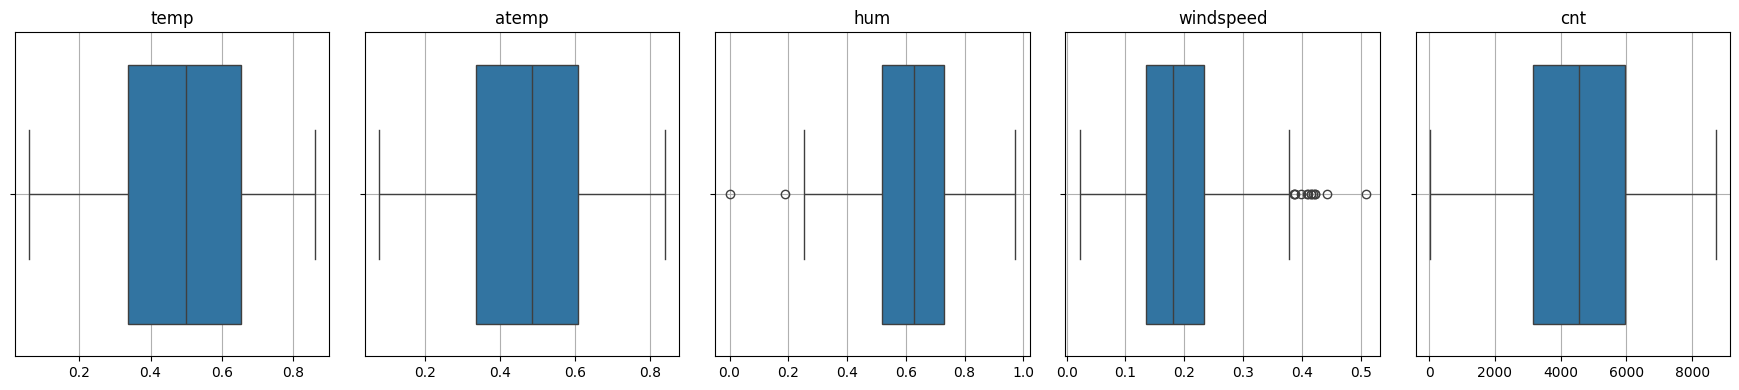

Skewness  Kurtosis
temp      -0.054521 -1.118864
atemp     -0.131088 -0.985131
hum       -0.069783 -0.064530
windspeed  0.677345  0.410922
cnt       -0.047353 -0.811922

In [48]:
plot_boxplots(data)
calculate_skewness_kurtosis(data)

In [49]:
outlier_cols = ["hum", "windspeed"]
interconnected_outliers_df = interconnected_outliers(data, outlier_cols)


Total Interconnected Outliers: 1
Column Set Outlier Frequency:
  Columns hum, windspeed: 1 times


In [50]:
interconnected_outliers_df

dteday season yr mnth holiday weekday workingday weathersit      temp  \
49 2011-02-19      1  0    2       0       6          0          1  0.399167   

       atemp       hum  windspeed   cnt  
49  0.391404  0.187917   0.507463  1635

In [51]:
def cap_outliers(series, lower_percentile=1, upper_percentile=99):
    lower_bound = np.percentile(series, lower_percentile)
    upper_bound = np.percentile(series, upper_percentile)
    return series.clip(lower=lower_bound, upper=upper_bound)
data['hum'] = cap_outliers(data['hum'])
data['windspeed'] = cap_outliers(data['windspeed'])

In [52]:
data['windspeed_log'] = np.log1p(data['windspeed'])

In [53]:
Q1 = data['windspeed_log'].quantile(0.25)
Q3 = data['windspeed_log'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['windspeed_log'] < lower_bound) | (data['windspeed_log'] > upper_bound)]
print(f"Outliers found: {outliers.shape[0]}")

Outliers found: 10


In [54]:
median_value = data['windspeed_log'].median()
data.loc[data['windspeed_log'] > upper_bound, 'windspeed_log'] = median_value
data.loc[data['windspeed_log'] < lower_bound, 'windspeed_log'] = median_value

 outliers were identified specifically in the hum (humidity) and windspeed columns, with a detailed examination revealing a few extreme values. These outliers were addressed by capping them at the 1st and 99th percentiles and applying a logarithmic transformation to windspeed to normalize its distribution. This process identified and corrected additional outliers, ensuring that the dataset's integrity is maintained for accurate analysis. 


Normal Columns (p > 0.05):


Empty DataFrame
Columns: [Column, Test, Statistic, p_value, Skewness, Kurtosis]
Index: []


Not Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:


Column          Test  Statistic       p_value  Skewness  Kurtosis
2            hum  Shapiro-Wilk   0.990059  7.519694e-05  0.046240 -0.606427
5  windspeed_log  Shapiro-Wilk   0.984764  6.687795e-07  0.349296 -0.301218
4            cnt  Shapiro-Wilk   0.980123  2.079554e-08 -0.047256 -0.814576
1          atemp  Shapiro-Wilk   0.973839  3.743482e-10 -0.130819 -0.986602
3      windspeed  Shapiro-Wilk   0.969488  3.255932e-11  0.617425  0.077906
0           temp  Shapiro-Wilk   0.965912  5.146187e-12 -0.054409 -1.119423


Variables Exhibiting Multicollinearity (|Correlation| > 0.80):
- windspeed_log & windspeed: Correlation=0.9801
- atemp & temp: Correlation=0.9926


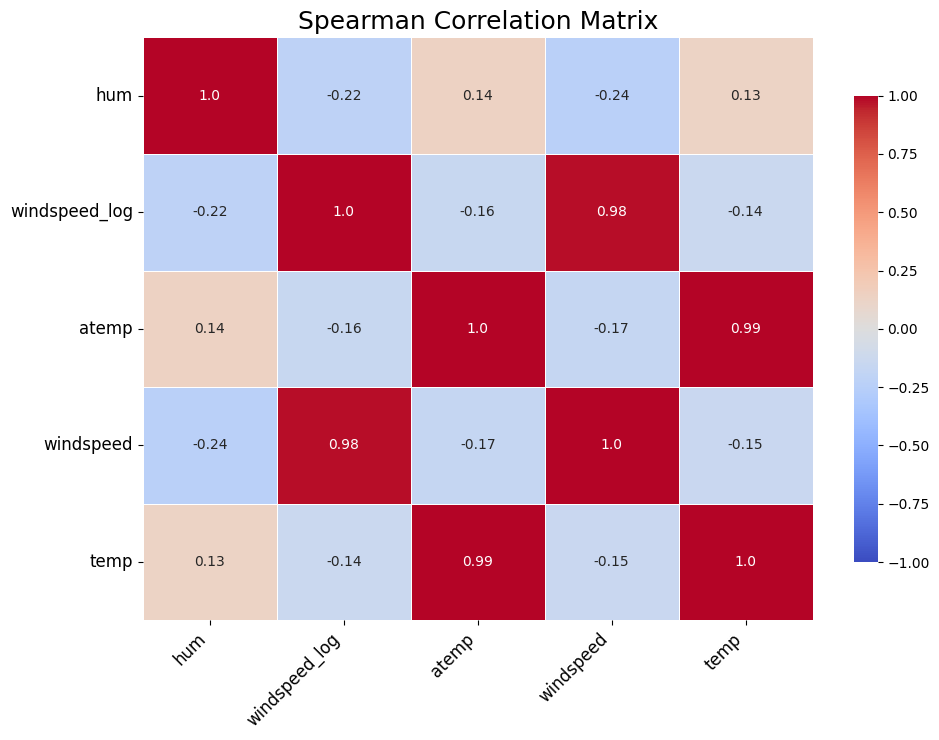

In [55]:
data_normal_df, data_not_normal_df = normality_test_with_skew_kurt(data)
spearman_correlation(data, data_not_normal_df, exclude_target='cnt', multicollinearity_threshold=0.8)

near-perfect correlation between atemp and temp, and between windspeed_log and windspeed. These strong correlations suggest redundancy, which might necessitate adjustments in predictive modeling to avoid multicollinearity. Additionally, the Shapiro-Wilk test results confirm that none of the variables follow a normal distribution, with some showing significant skewness and kurtosis.

### Exploratory Data Analysis (EDA)


### Analysis for 'cnt'  ###

|    | Cnt          |        Overall |
|---:|:-------------|---------------:|
|  0 | Count        |  731           |
|  1 | Mean         | 4504.35        |
|  2 | Trimmed Mean | 4504.35        |
|  3 | MAD          | 1581.79        |
|  4 | Std          | 1937.21        |
|  5 | Min          |   22           |
|  6 | 25%          | 3152           |
|  7 | 50%          | 4548           |
|  8 | 75%          | 5956           |
|  9 | Max          | 8714           |
| 10 | Mode         | 1096           |
| 11 | Range        | 8692           |
| 12 | IQR          | 2804           |
| 13 | Variance     |    3.75279e+06 |
| 14 | Skewness     |   -0.0473528   |
| 15 | Kurtosis     |   -0.811922    |


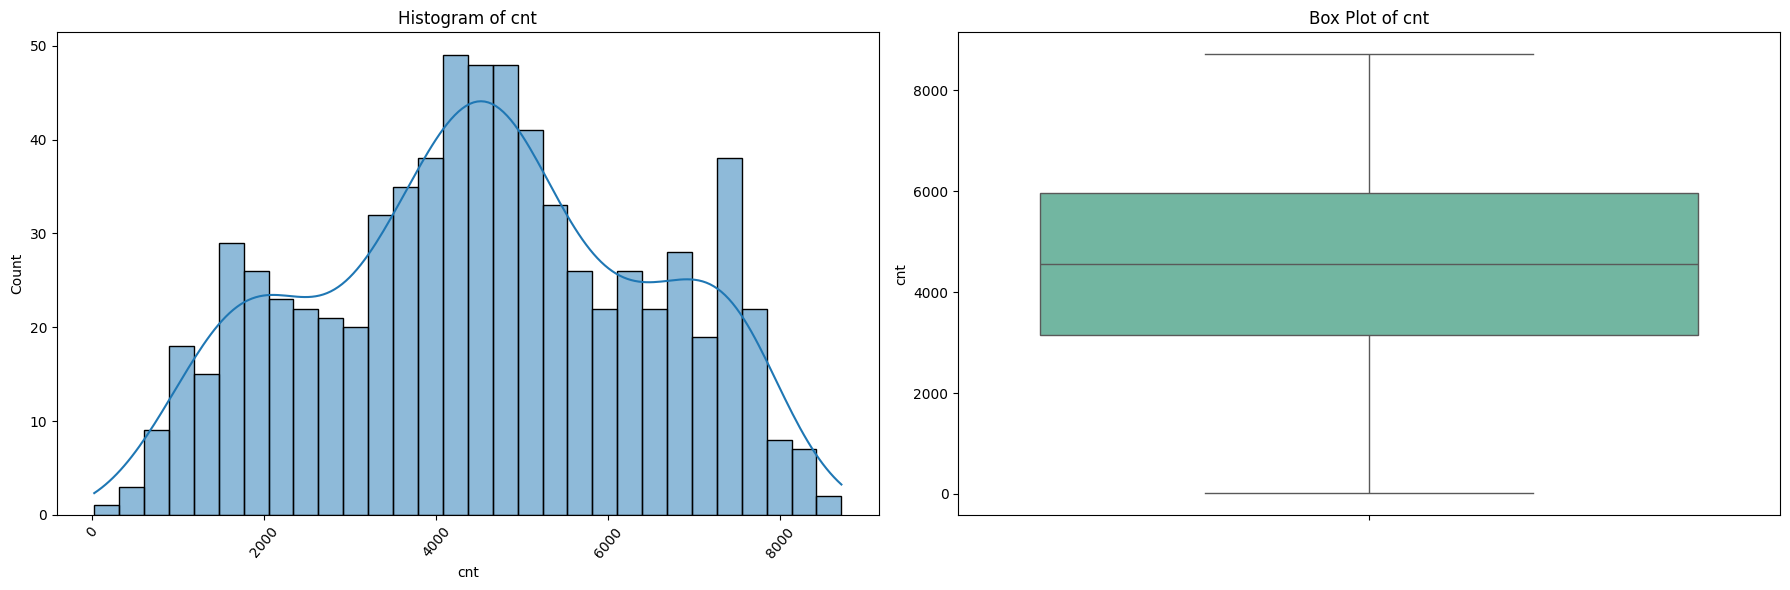

In [56]:
num_analysis_and_plot(data, 'cnt')

In [57]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     1          season                         category        N/A                            4
2     2          yr                             category        N/A                            2
3     3          mnth                           category        N/A                            12
4     4          holiday                        category        N/A                            2
5     5          weekday                        category        N/A                            7
6     6          workingday                     category        N/A                            2
7     7          weathersit                     category        N/A                            3
8     0          dteday                         datetime64

In [58]:
analyze_data(data)













=== Numerical Analysis ===
|    | Variable      |   N |      Mean |        SD |      SE |   95% Conf. |   Interval |
|---:|:--------------|----:|----------:|----------:|--------:|------------:|-----------:|
|  0 | temp          | 731 |    0.4954 |    0.1831 |  0.0068 |      0.4821 |     0.5087 |
|  1 | atemp         | 731 |    0.4744 |    0.163  |  0.006  |      0.4625 |     0.4862 |
|  2 | hum           | 731 |    0.6284 |    0.1396 |  0.0052 |      0.6183 |     0.6386 |
|  3 | windspeed     | 731 |    0.1903 |    0.0765 |  0.0028 |      0.1848 |     0.1959 |
|  4 | cnt           | 731 | 4504.35   | 1937.21   | 71.6504 |   4363.68   |  4645.01   |
|  5 | windspeed_log | 731 |    0.1698 |    0.0601 |  0.0022 |      0.1655 |     0.1742 |

=== Categorical Analysis ===
|    | Variable   |   Outcome |   Count |   Percent |
|---:|:-----------|----------:|--------:|----------:|
|  0 | season     |         3 |     188 |     25.72 |
|  1 | season     |         2 |     184 |     25.

### Descriptive Statistics

In [59]:
num_summary(data)

Count  Unique       Mean        Std      Min        25%  \
temp           731.0   499.0     0.4954     0.1831   0.0591     0.3371   
atemp          731.0   690.0     0.4744     0.1630   0.0791     0.3378   
hum            731.0   581.0     0.6284     0.1396   0.3121     0.5200   
windspeed      731.0   636.0     0.1903     0.0765   0.0530     0.1349   
cnt            731.0   696.0  4504.3488  1937.2115  22.0000  3152.0000   
windspeed_log  731.0   633.0     0.1698     0.0601   0.0516     0.1266   

                     50%        75%        Max         Mode      Range  \
temp              0.4983     0.6554     0.8617     0.265833     0.8025   
atemp             0.4867     0.6086     0.8409     0.654688     0.7618   
hum               0.6267     0.7302     0.9279     0.312125     0.6158   
windspeed         0.1810     0.2332     0.4087     0.052973     0.3557   
cnt            4548.0000  5956.0000  8714.0000  1096.000000  8692.0000   
windspeed_log     0.1663     0.2076     0.3279     0.166340     0.2763   

                     IQR      Variance  Skewness  Kurtosis  Shapiro-Wilk Stat  \
temp              0.3183  3.350000e-02   -0.0545   -1.1189             0.9659   
atemp             0.2708  2.660000e-02   -0.1311   -0.9851             0.9738   
hum               0.2102  1.950000e-02    0.0463   -0.6023             0.9901   
windspeed         0.0983  5.900000e-03    0.6187    0.0867             0.9695   
cnt            2804.0000  3.752788e+06   -0.0474   -0.8119             0.9801   
windspeed_log     0.0810  3.600000e-03    0.3500   -0.2950             0.9848   

               Shapiro-Wilk p-value  
temp                         0.0000  
atemp                        0.0000  
hum                          0.0001  
windspeed                    0.0000  
cnt                          0.0000  
windspeed_log                0.0000

In [60]:
cat_summary(data)

Count Unique Top Freq   Top %
season       731      4   3  188  25.72%
yr           731      2   1  366  50.07%
mnth         731     12   1   62   8.48%
holiday      731      2   0  710  97.13%
weekday      731      7   0  105  14.36%
workingday   731      2   1  500  68.40%
weathersit   731      3   1  463  63.34%

The analysis of the 'cnt' variable, representing total daily bike rentals, reveals significant variability in rental activity across 731 observations. The average daily rentals stand at 4,504 with fluctuations ranging from as low as 22 to as high as 8,714. This data displays a slight negative skew and a less peaked distribution than a normal curve, suggesting variability isn't driven by outliers. The results, including a median of 4,548 and an interquartile range of 2,804, underscore the day-to-day changes in bike rental counts, which is critical for managing and forecasting in bike-sharing operations. Additionally, the Shapiro-Wilk test confirms that the distribution does not conform to normality, indicating the need for non-parametric methods in further analyses.

### Univariate Analysis

#### num_analysis

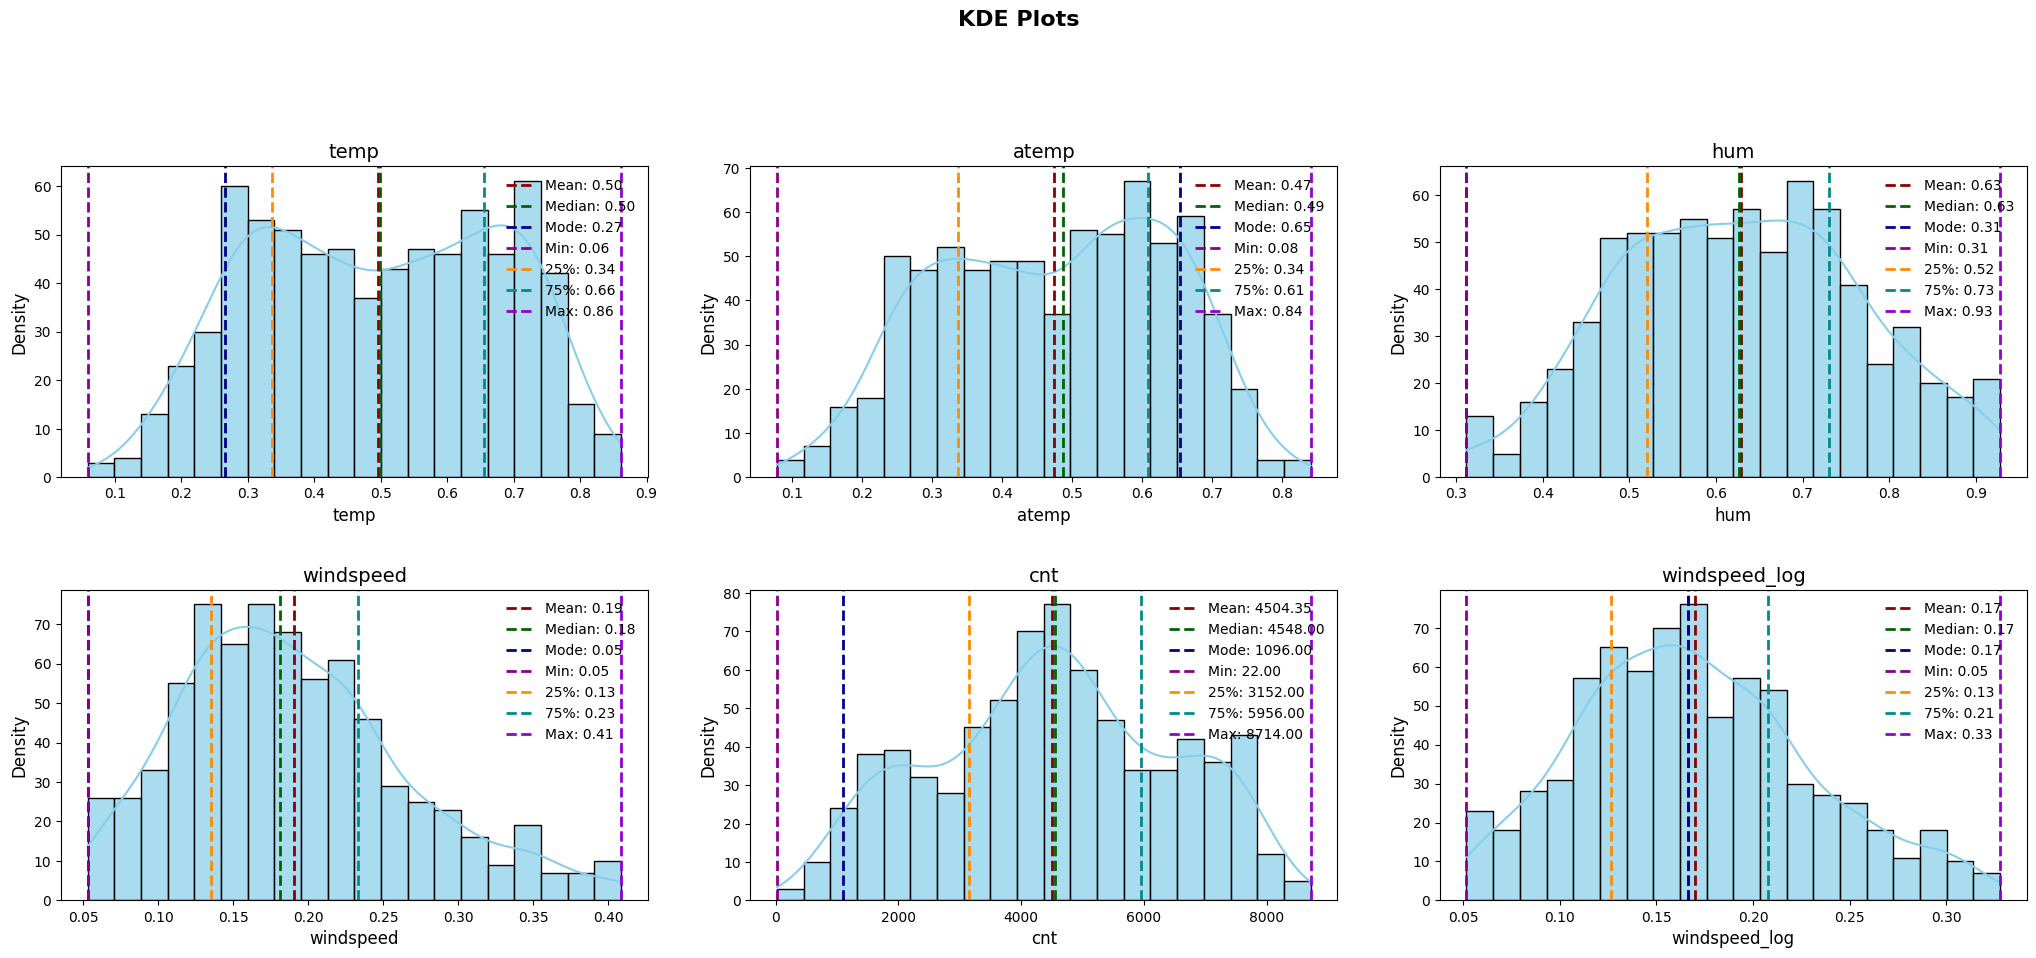

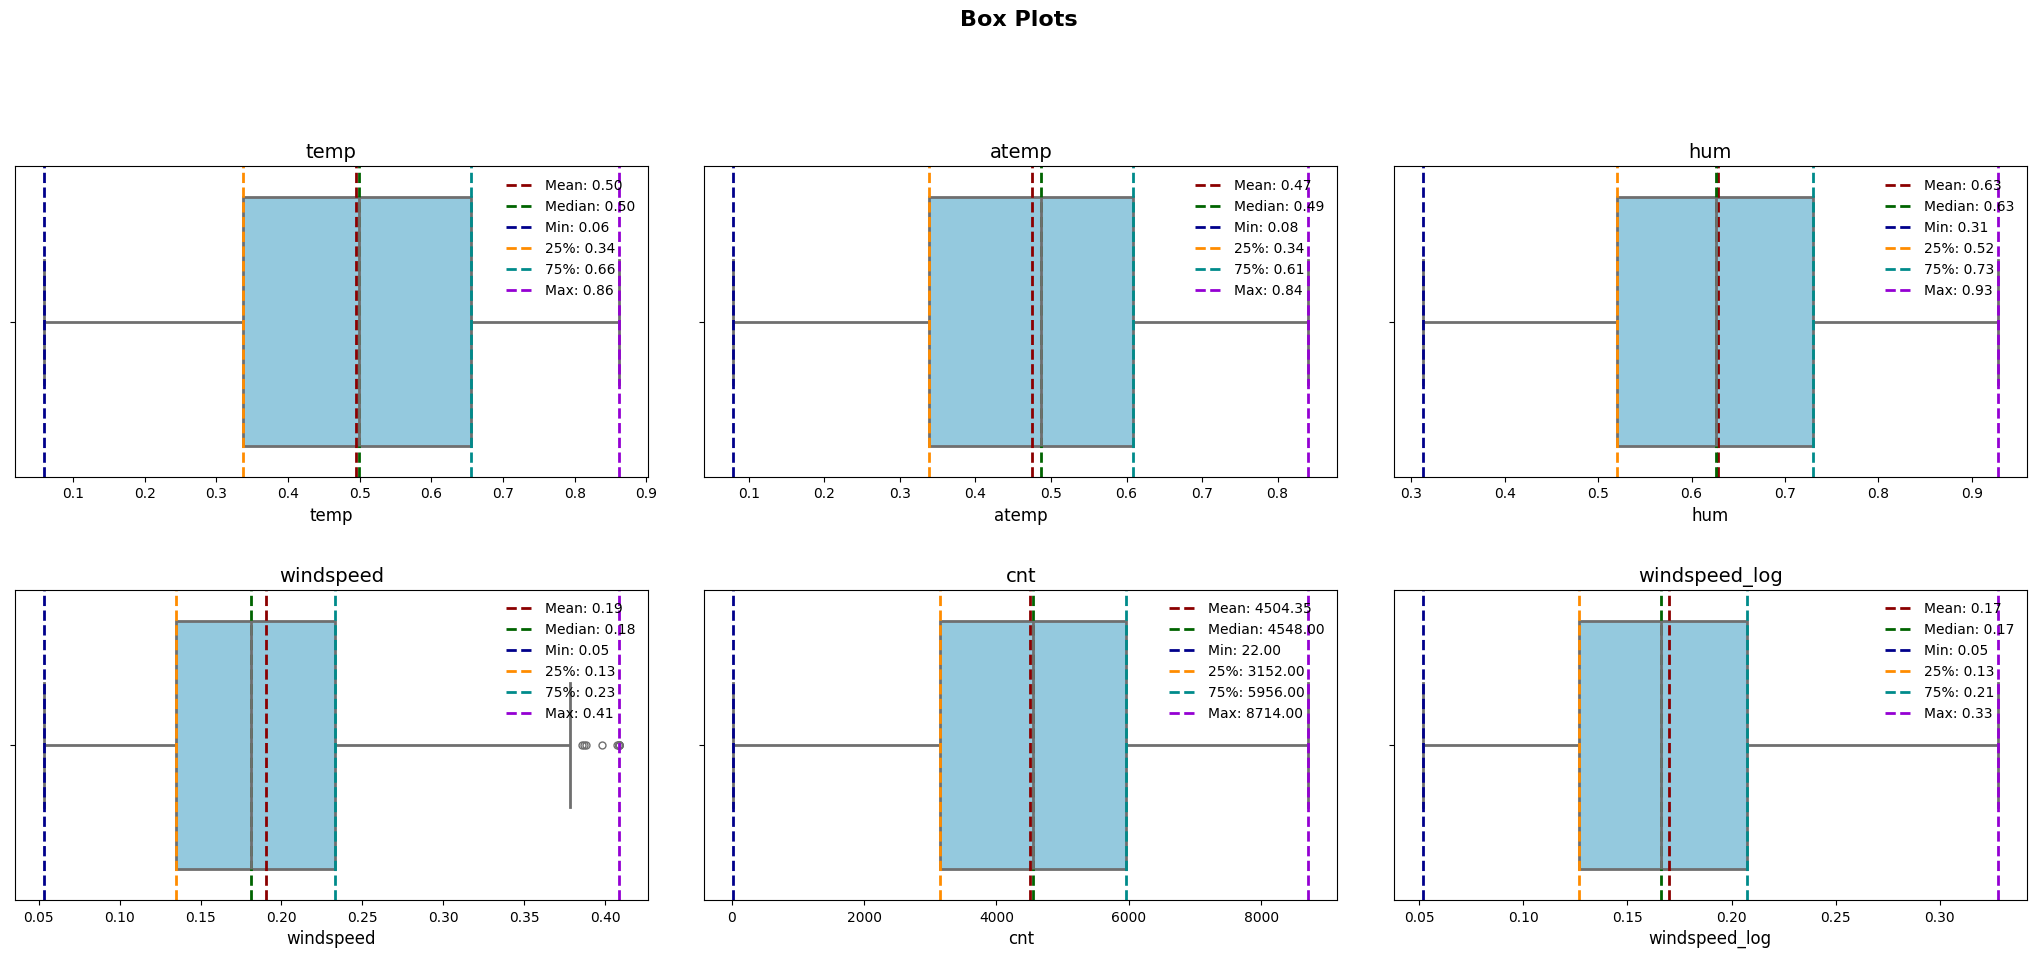

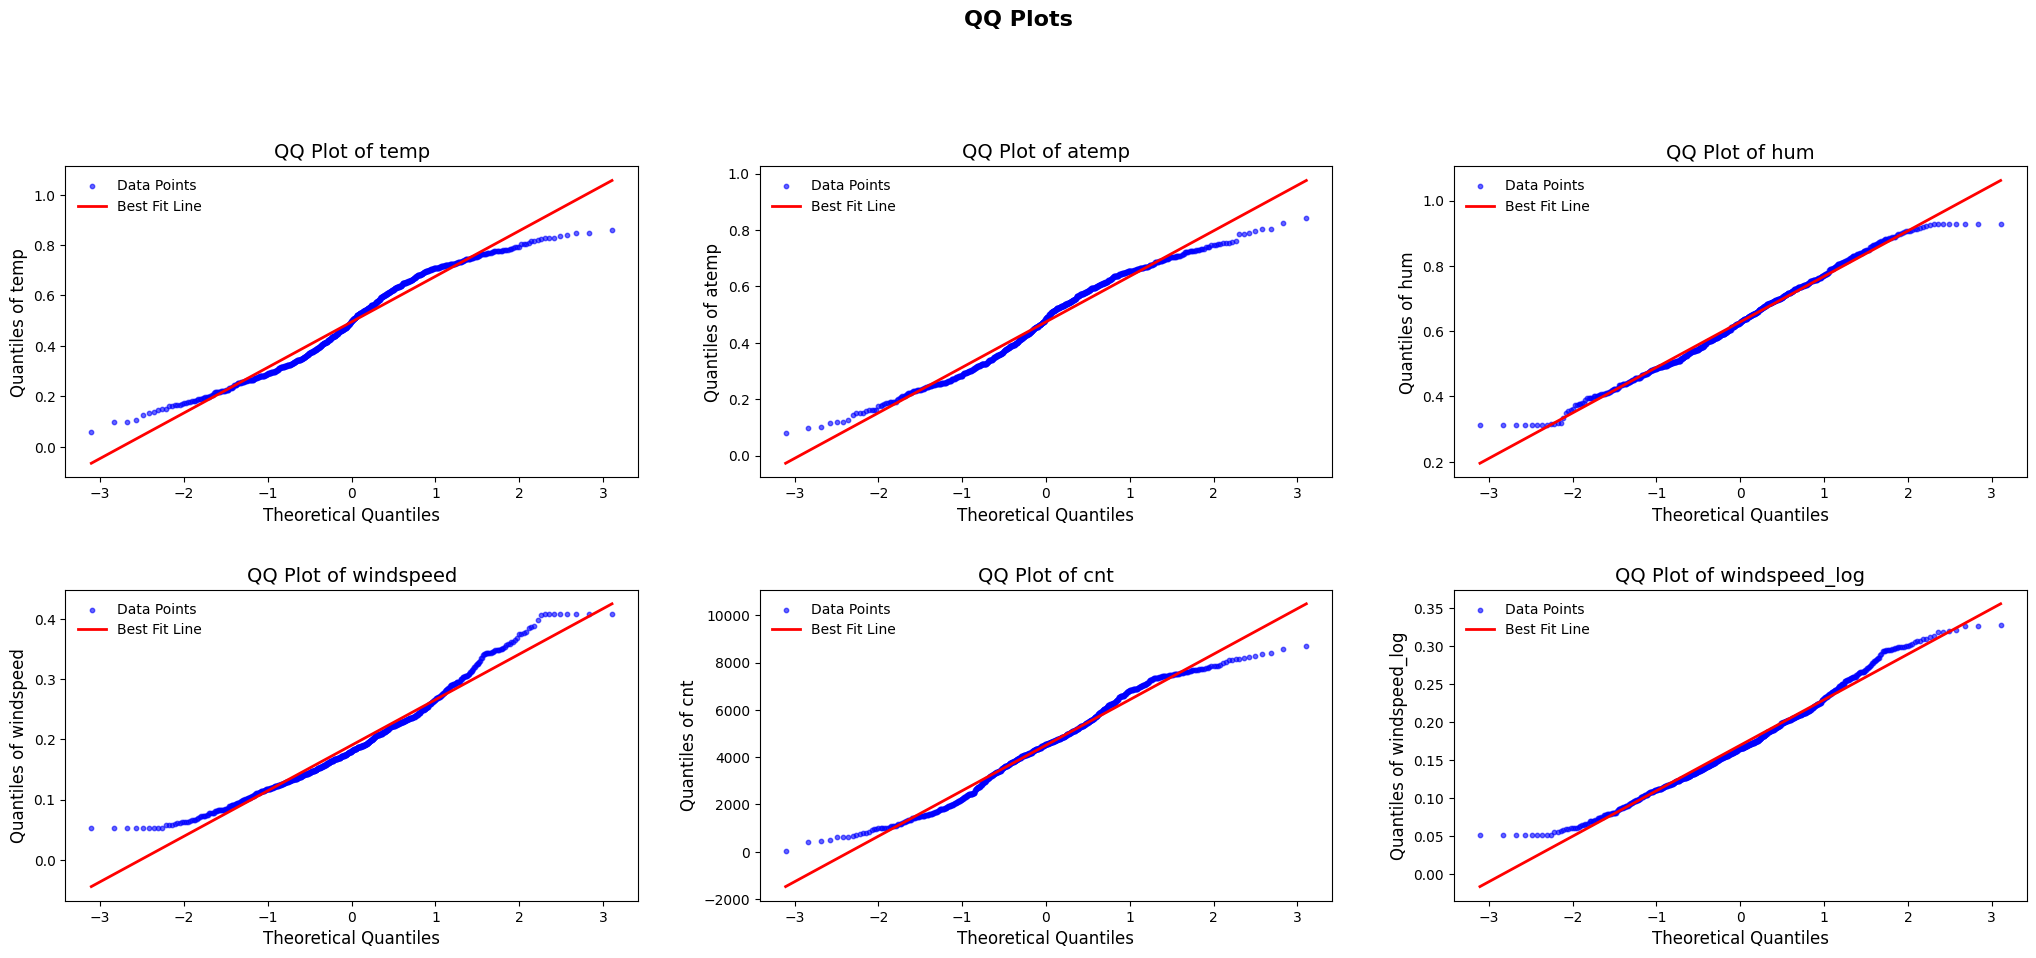

In [61]:
kde_batches(data, batch_num=1)
box_plot_batches(data, batch_num=1)
qq_plot_batches(data, batch_num=1)

the temperature, adjusted temperature, humidity, wind speed, and bike rental counts (cnt), all exhibit distinct distribution characteristics. Temperature and adjusted temperature seem to center around their means but deviate from normality, especially at their tails. Humidity displays a more uniform spread across its range but skews slightly towards higher values. Wind speed is notably right-skewed, a common trait for this type of data, which persists even after a logarithmic transformation. The bike rental counts show a wide range of values, indicating days with very high rental activity alongside more typical days. The QQ plots confirm that none of these variables follows a normal distribution, suggesting the need for statistical methods that can accommodate non-normality and handle outliers effectively for any predictive modeling or analysis.

#### cat_analysis


=== Excluded or Processed Columns ===
Time Series Columns (Auto-Detected): ['dteday']


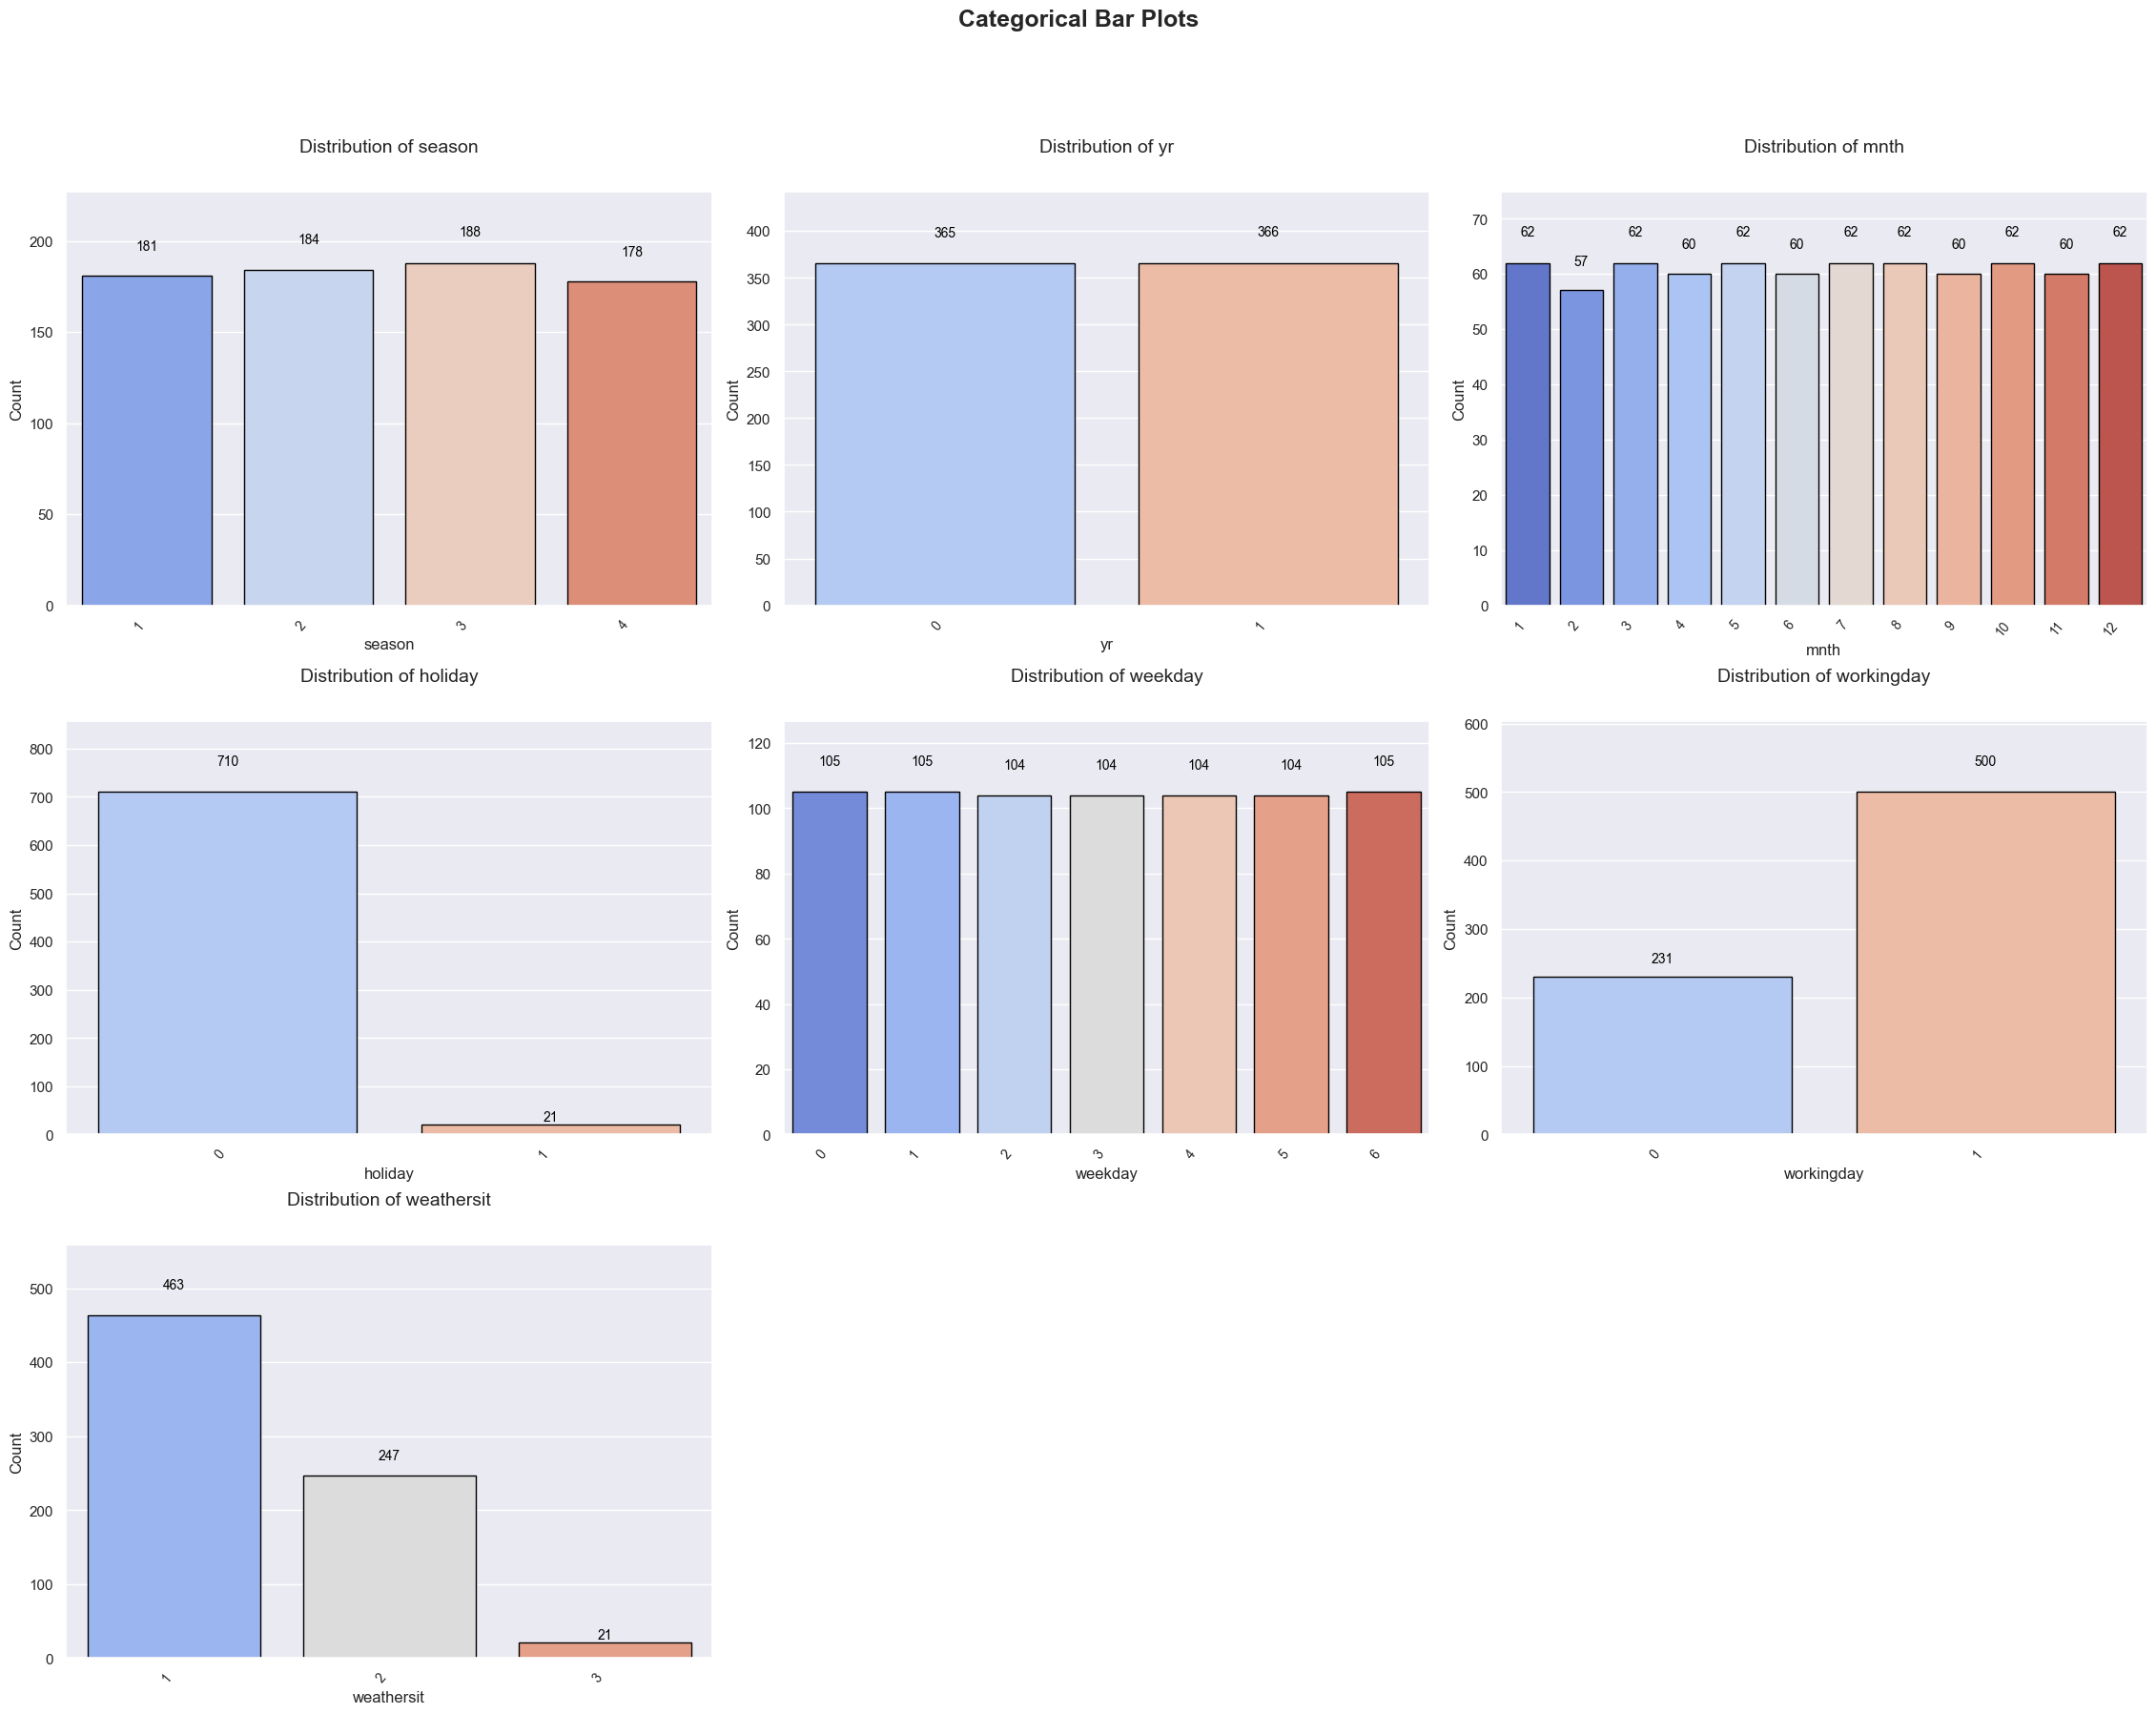


=== Excluded Columns ===
Time Series Columns (Auto-Detected): ['dteday']


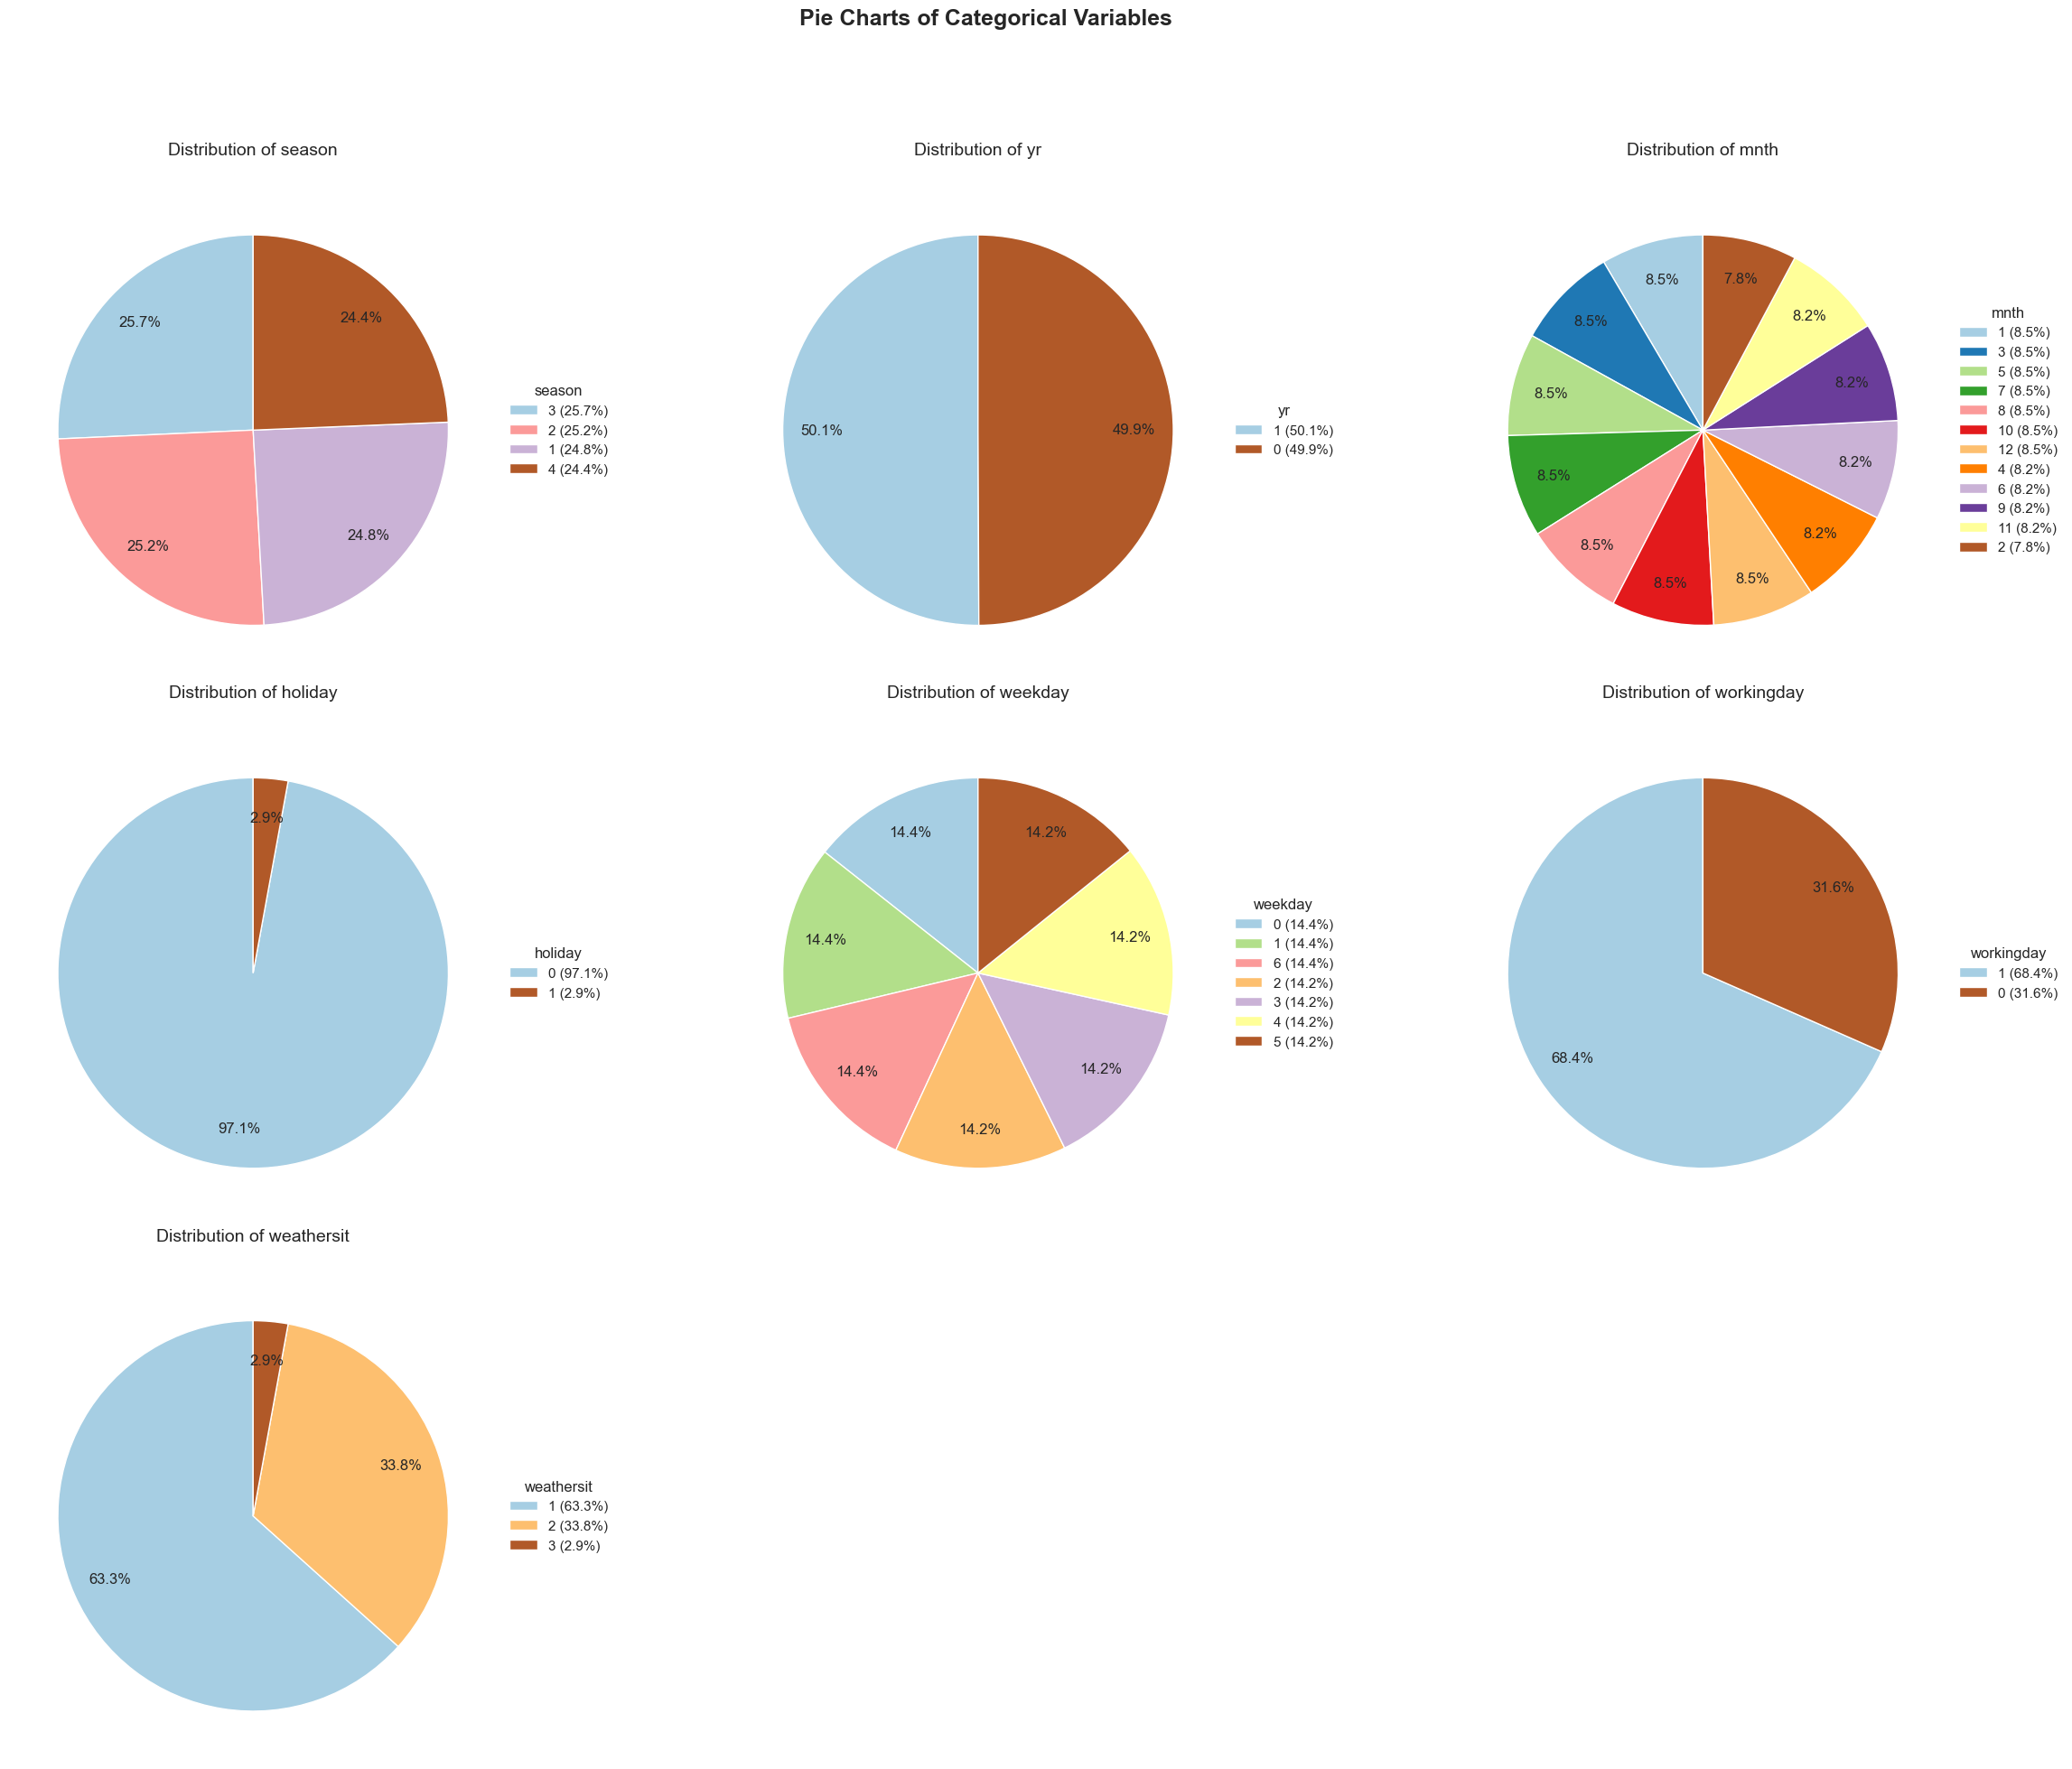

In [62]:
cat_bar_batches(data, batch_num=1,high_cardinality_limit=22)
cat_pie_chart_batches(data, batch_num=1,high_cardinality_limit=22)

Each season is almost equally represented, ensuring a balanced analysis through different weather conditions. The dataset includes an equal number of entries for two years, providing a comprehensive comparison over time. Monthly data is evenly distributed, capturing detailed seasonal impacts on bike rental patterns. The majority of data points represent non-holiday days, highlighting typical usage patterns, while holiday occurrences are minimal. Weekday distribution is uniform, indicating consistent data collection throughout the week. Most entries are classified as working days, which could influence rental trends compared to non-working days. Weather conditions predominantly fall into the better weather categories, with fewer instances of poor weather, affecting the analysis of weather-related impacts on rentals. These distributions are crucial for understanding how temporal and environmental factors might influence bike rental behavior.

### Bivariate & Multivariate Analysis

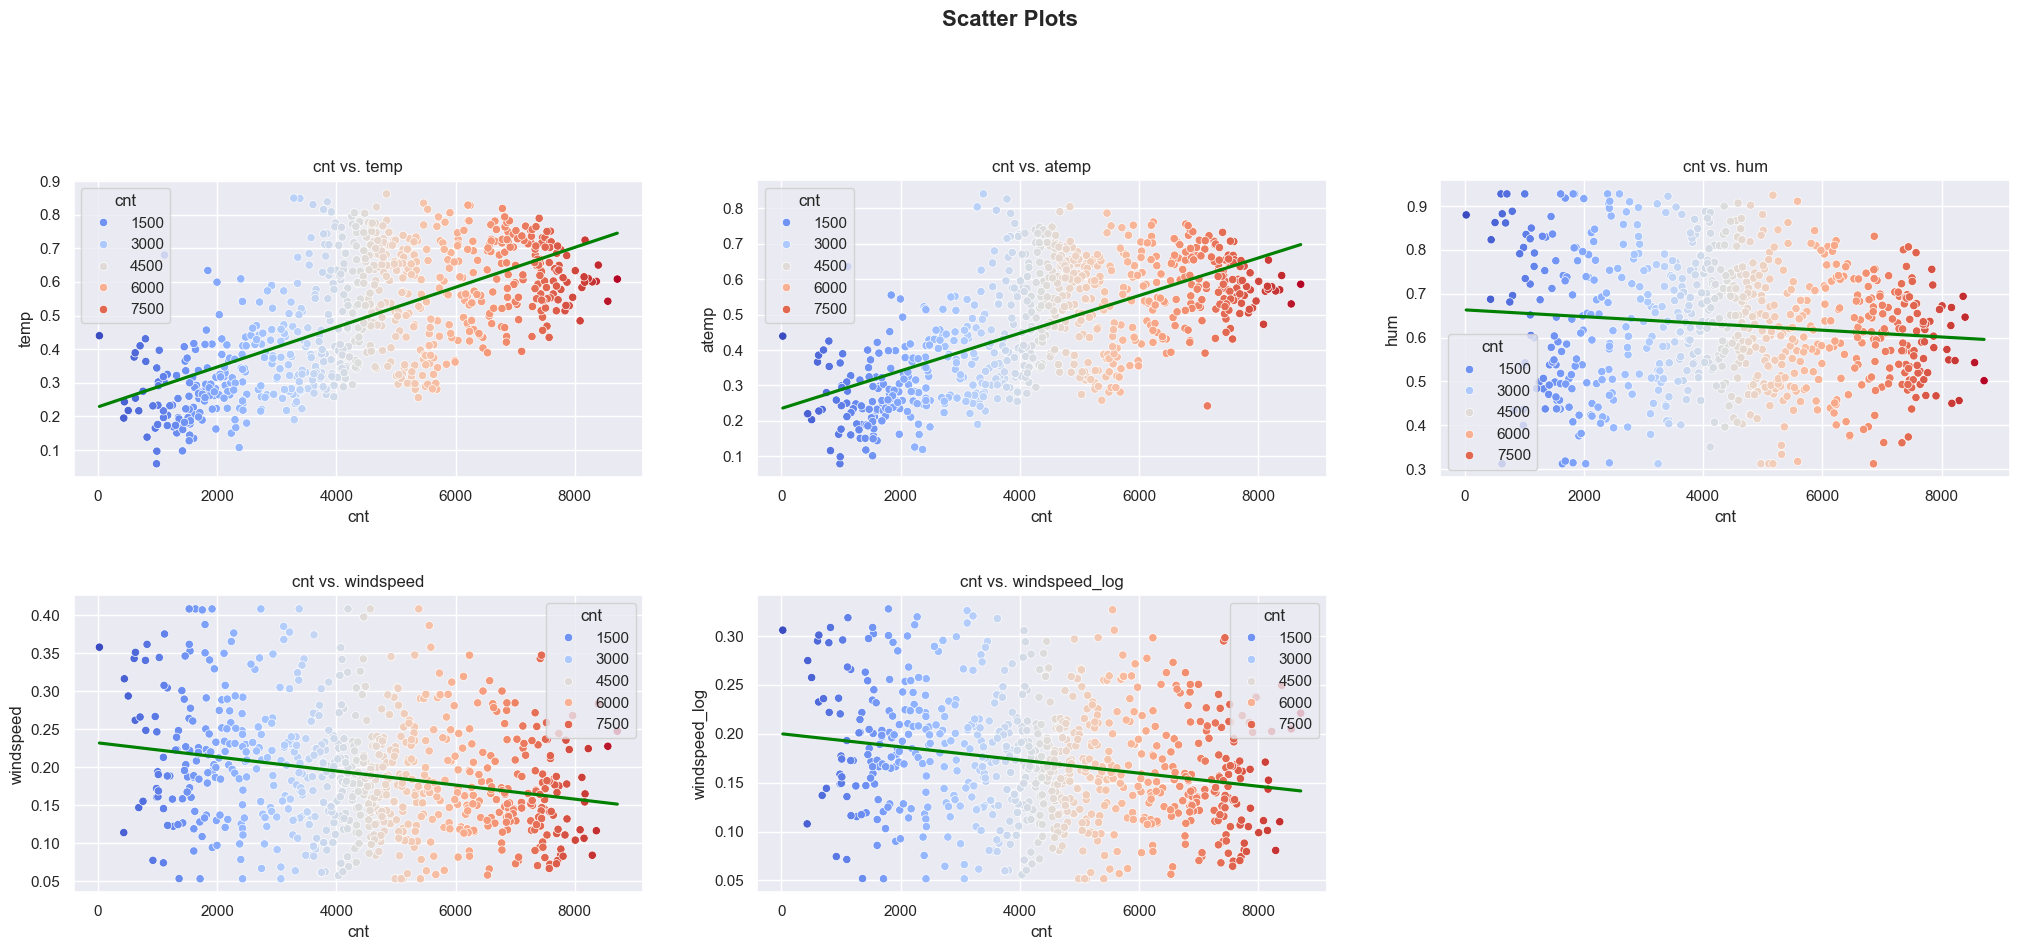

In [63]:
num_vs_num_scatterplot_pair_batch(data,pair_num=4, batch_num=1, hue_column="cnt")

A strong positive correlation is observed between cnt and both temp and atemp, indicating higher rentals on warmer days. Humidity (hum) shows a slight negative correlation, suggesting that increased humidity may slightly reduce rentals. Wind speed (windspeed) and its log-transformed version (windspeed_log) also exhibit a weak negative correlation with cnt, implying that stronger winds may discourage bike usage. The color gradient highlights density variations, with higher rental counts concentrated in specific ranges of temperature and humidity.

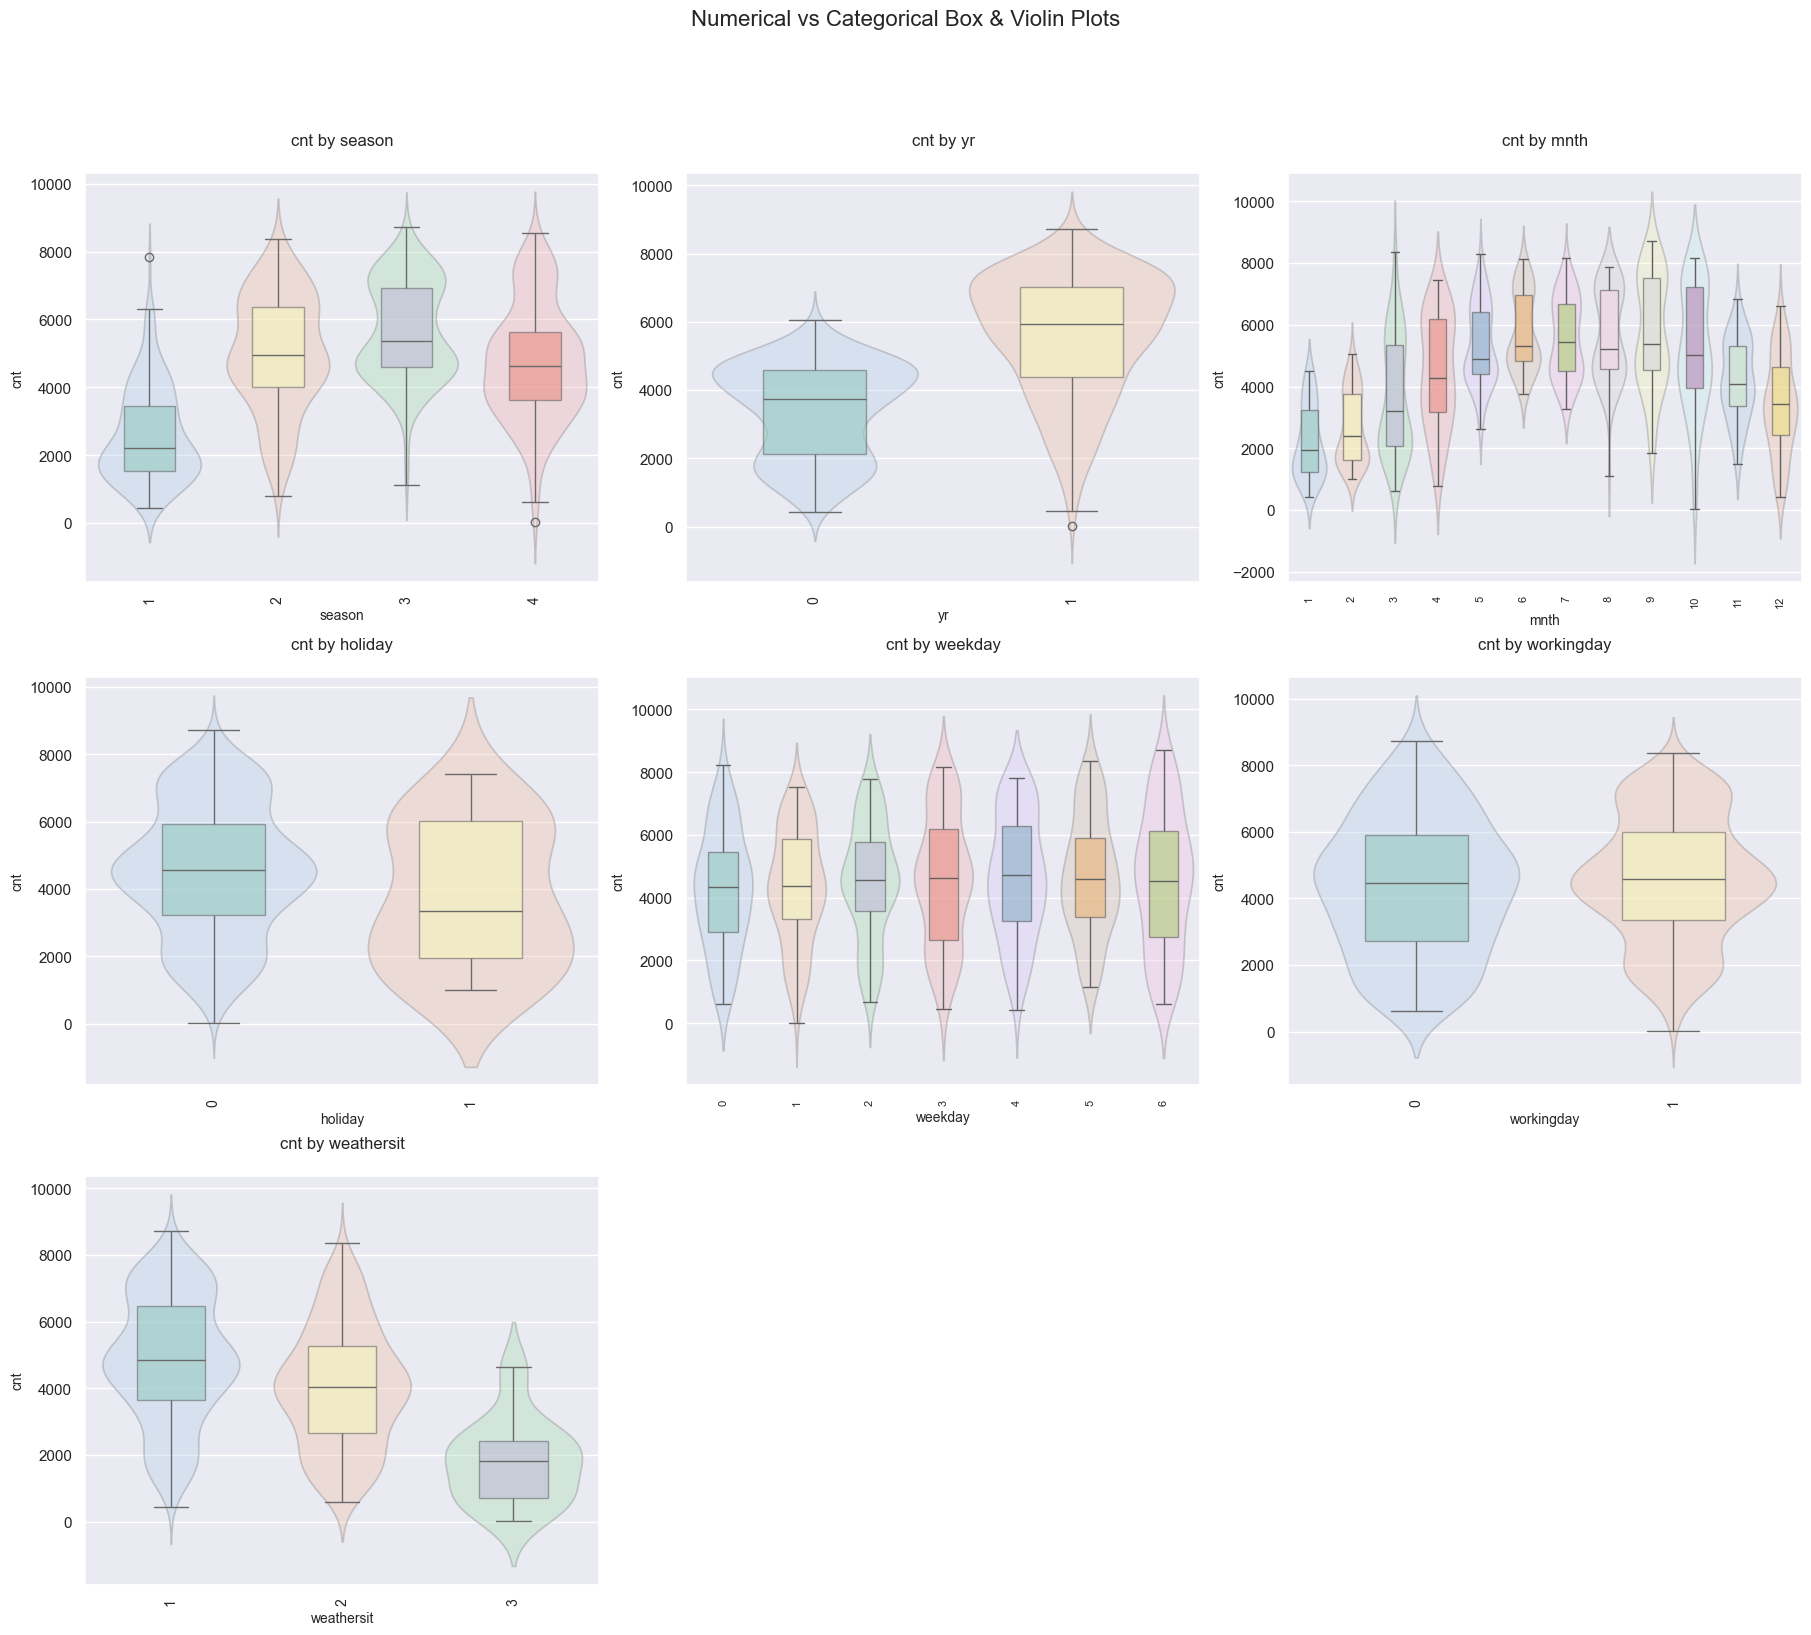

In [64]:
num_vs_cat_box_violin_pair_batch(data, pair_num=4, batch_num=1, high_cardinality_limit=22)

Rentals are higher in warmer seasons, with summer and fall showing the highest median counts. The year-wise comparison indicates an overall increase in rentals in the second year. Monthly distribution shows fluctuations, with peaks around mid-year. Holidays tend to have a wider spread but generally lower median rentals compared to non-holidays. Weekday distributions remain fairly consistent, while working days exhibit slightly lower variability. Weather conditions significantly impact rentals, with clear weather leading to higher counts and poor weather conditions showing a sharp decline in usage.

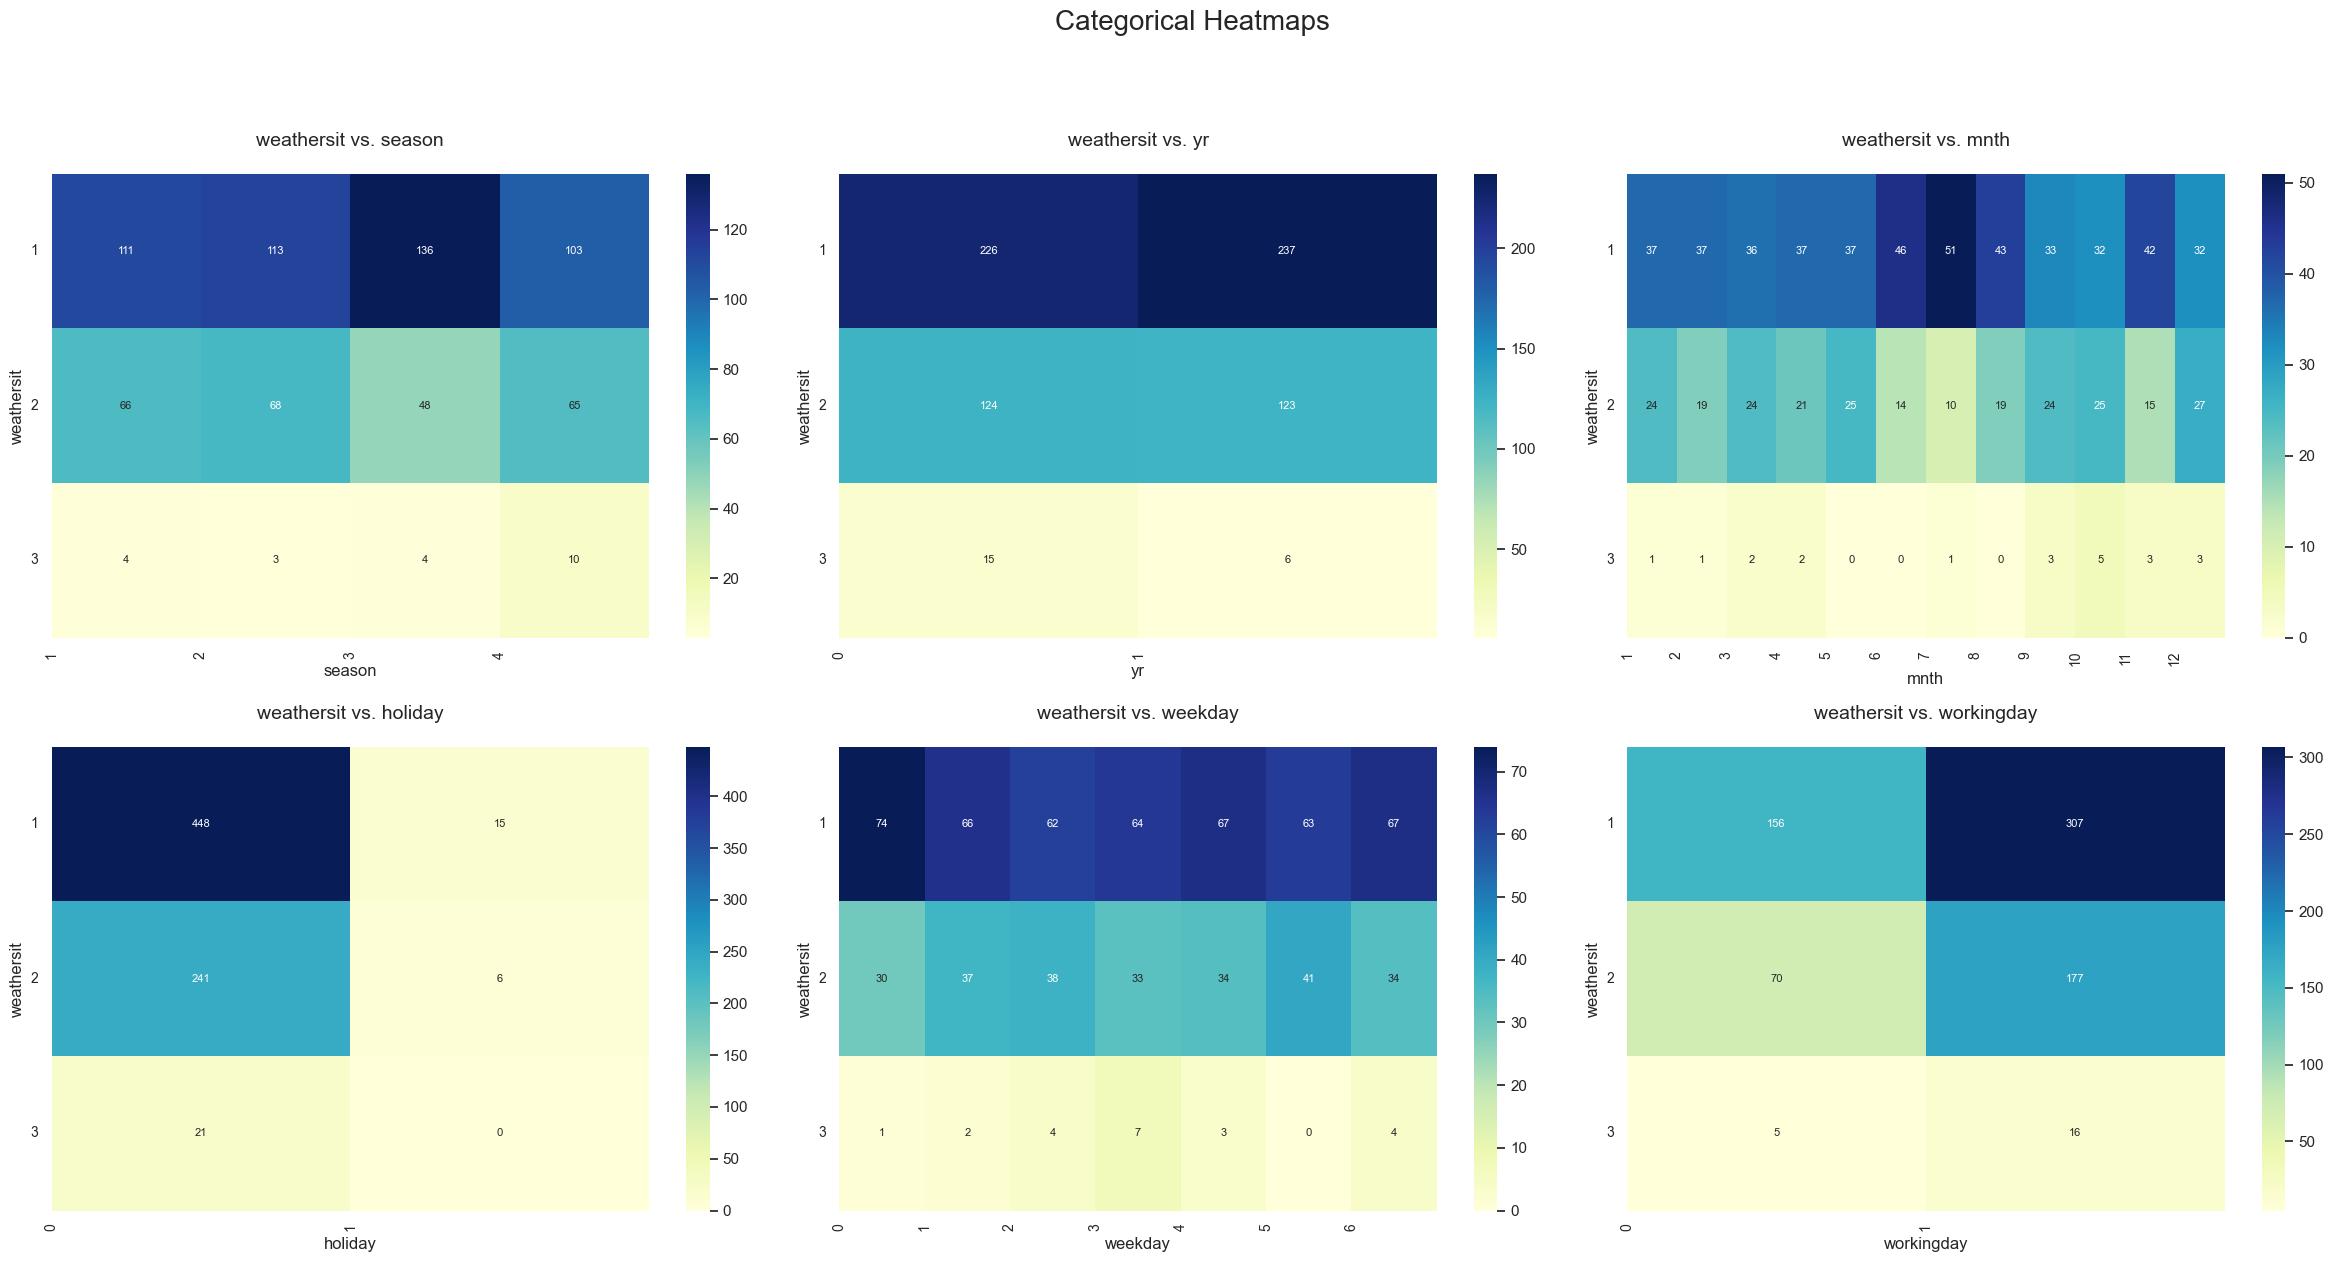

In [65]:
cat_vs_cat_pair_batch(data, pair_num=6, batch_num=1, high_cardinality_limit=22)

 Clear weather is most frequent in all seasons, while poor weather is relatively rare, with a slight increase in winter. Yearly trends show consistency in weather distribution, with clear conditions prevailing. Monthly variations indicate higher instances of unfavorable weather in the colder months. Holidays and non-holidays exhibit a similar weather pattern, with clear conditions dominating. Weekdays and working days follow a uniform trend, with minimal fluctuations in weather distribution across different days of the week.

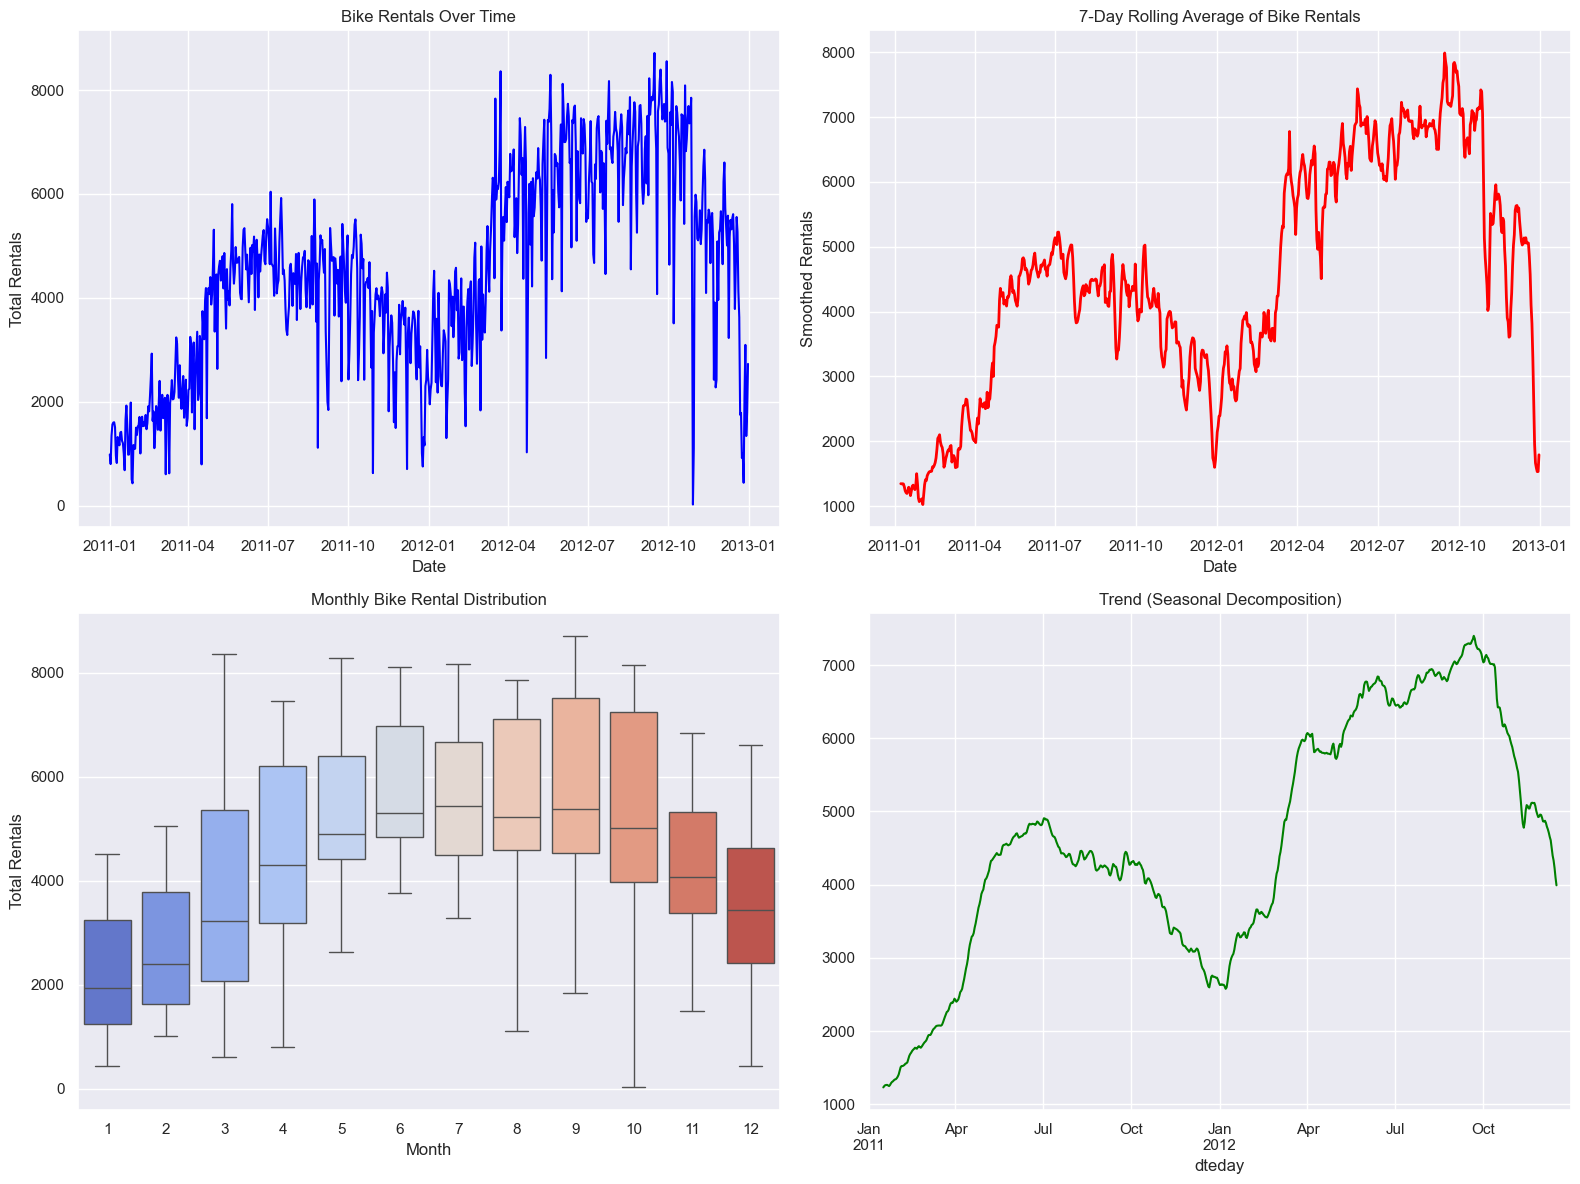

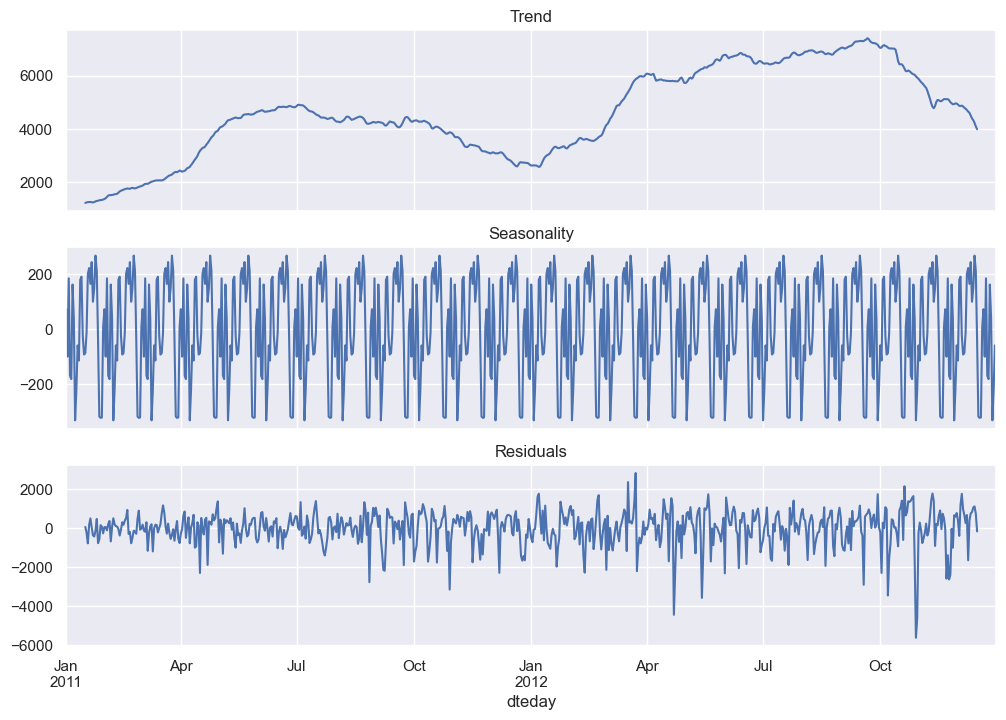

In [66]:
data['dteday'] = pd.to_datetime(data['dteday'])
data['cnt_rolling'] = data['cnt'].rolling(window=7).mean()
decomposition = seasonal_decompose(data.set_index('dteday')['cnt'], model='additive', period=30)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes[0, 0].plot(data['dteday'], data['cnt'], color='blue', linewidth=1.5)
axes[0, 0].set_title("Bike Rentals Over Time")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Total Rentals")
axes[0, 0].grid(True)
axes[0, 1].plot(data['dteday'], data['cnt_rolling'], color='red', linewidth=2)
axes[0, 1].set_title("7-Day Rolling Average of Bike Rentals")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Smoothed Rentals")
axes[0, 1].grid(True)
sns.boxplot(x=data['mnth'], y=data['cnt'], ax=axes[1, 0], palette="coolwarm")
axes[1, 0].set_title("Monthly Bike Rental Distribution")
axes[1, 0].set_xlabel("Month")
axes[1, 0].set_ylabel("Total Rentals")
decomposition.trend.plot(ax=axes[1, 1], title="Trend (Seasonal Decomposition)", color="green")
plt.tight_layout()
plt.show()
decomposition = seasonal_decompose(data.set_index('dteday')['cnt'], model='additive', period=30)
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
decomposition.trend.plot(ax=axes[0], title='Trend')
decomposition.seasonal.plot(ax=axes[1], title='Seasonality')
decomposition.resid.plot(ax=axes[2], title='Residuals')
plt.show()

Bike rentals exhibit strong seasonal trends, peaking during warmer months and declining in colder seasons. The overall trend shows a consistent increase in demand from early 2011, reaching a peak in mid-2012, followed by a slight decline toward the end of the year. The rolling average smooths out daily fluctuations, highlighting a clear seasonal pattern with a strong upward trend in rentals, particularly during spring and summer. Monthly rental distributions confirm higher demand from May to October, with July and August showing the highest counts. The seasonal decomposition further breaks down these trends, illustrating strong seasonality and stable residuals, indicating a predictable pattern influenced by external factors like weather and time of year.

---

# Predictive Model

In [67]:
data_cat_missing_summary, data_cat_non_missing_summary = comp_cat_analysis(data, missing_df=True)
data_missing_summary, data_non_missing_summary = comp_num_analysis(data, missing_df=True)
data_outlier_summary, data_non_outlier_summary = comp_num_analysis(data, outlier_df=True)
print(data_cat_missing_summary.shape)
print(data_missing_summary.shape)
print(data_outlier_summary.shape)

(0, 9)
(1, 31)
(1, 31)


In [68]:
data_missing_summary

Index       Column DataType  Count  Missing_Percentage  Unique_Count  \
6     14  cnt_rolling  float64    725            0.820793           713   

           Min      Q1  50% (Median)      Q3     Max         Mode  \
6  1022.714286  3344.0   4470.142857  6123.0  7988.0  1234.714286   

         Range     IQR  Lower Bound  Upper Bound  Total Distinct  \
6  6965.285714  2779.0       -824.5      10291.5             713   

   Outliers Distinct  Outliers Count  Outliers %  Negative Count  \
6                  0               0         0.0               0   

   Negative Distinct  Negative %         Mean      Variance          Std  \
6                  0         0.0  4527.936552  3.031008e+06  1740.978997   

   Skewness  Kurtosis Normality Test  Normality Statistic  Normality p-value  
6 -0.102329 -0.913807   Shapiro-Wilk             0.968397       2.100988e-11

In [69]:
data_outlier_summary

Index     Column DataType  Count  Missing_Percentage  Unique_Count  \
3     11  windspeed  float64    731                 0.0           636   

        Min       Q1  50% (Median)        Q3       Max      Mode     Range  \
3  0.052973  0.13495      0.180975  0.233214  0.408652  0.052973  0.355679   

        IQR  Lower Bound  Upper Bound  Total Distinct  Outliers Distinct  \
3  0.098265    -0.012447     0.380611             636                  6   

   Outliers Count  Outliers %  Negative Count  Negative Distinct  Negative %  \
3              13    1.778386               0                  0         0.0   

       Mean  Variance       Std  Skewness  Kurtosis Normality Test  \
3  0.190336  0.005854  0.076509  0.617425  0.077906   Shapiro-Wilk   

   Normality Statistic  Normality p-value  
3             0.969488       3.255932e-11

In [70]:
upper_limit_windspeed = data['windspeed'].quantile(0.75) + 1.5 * (data['windspeed'].quantile(0.75) - data['windspeed'].quantile(0.25))
data['windspeed'] = data['windspeed'].apply(lambda x: upper_limit_windspeed if x > upper_limit_windspeed else x)

data.drop('cnt_rolling', axis=1, inplace=True)

In [71]:
data.drop('dteday', axis=1, inplace=True)

The a single missing value in the cnt_rolling column, which was later dropped. The numerical analysis indicates that windspeed has 13 outliers, accounting for approximately 1.78% of the data, but no negative values. The normality test for windspeed suggests a non-normal distribution, with slight positive skewness and low kurtosis. To mitigate extreme values, windspeed was capped at the upper IQR limit. Additionally, dteday was removed, likely to focus on numerical and categorical features relevant to bike rental predictions. These adjustments ensure a refined dataset without unnecessary columns or extreme values affecting model performance.

## Preprocessing

#### Encoding

In [72]:
import calendar
data['mnth'] = data['mnth'].apply(lambda x: calendar.month_abbr[x])
data['season'] = data['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
data['weathersit'] = data['weathersit'].map({
    1: 'Clear', 2: 'Mist & Cloudy', 3: 'Light Snow & Rain', 4: 'Heavy Snow & Rain'
})
data['weekday'] = data['weekday'].map({
    0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday"
})
categorical_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [73]:
bool_cols = data_encoded.select_dtypes(include='bool').columns
data_encoded[bool_cols] = data_encoded[bool_cols].astype(int)

#### Relation


Normal Columns (p > 0.05):


Empty DataFrame
Columns: [Column, Test, Statistic, p_value, Skewness, Kurtosis]
Index: []


Not Normal Columns (p ≤ 0.05) - Sorted from Near Normal to Not Normal:


Column          Test  Statistic       p_value  \
2                            hum  Shapiro-Wilk   0.990059  7.519694e-05   
5                  windspeed_log  Shapiro-Wilk   0.984764  6.687795e-07   
4                            cnt  Shapiro-Wilk   0.980123  2.079554e-08   
1                          atemp  Shapiro-Wilk   0.973839  3.743482e-10   
3                      windspeed  Shapiro-Wilk   0.970418  5.383162e-11   
0                           temp  Shapiro-Wilk   0.965912  5.146187e-12   
9                           yr_1  Shapiro-Wilk   0.636576  1.246048e-36   
29      weathersit_Mist & Cloudy  Shapiro-Wilk   0.597176  4.989213e-38   
28                  workingday_1  Shapiro-Wilk   0.585353  1.996931e-38   
7                    season_Fall  Shapiro-Wilk   0.544461  9.828385e-40   
6                  season_Summer  Shapiro-Wilk   0.539920  7.131768e-40   
8                  season_Winter  Shapiro-Wilk   0.532847  4.350317e-40   
27              weekday_Saturday  Shapiro-Wilk   0.416849  2.816610e-43   
22                weekday_Monday  Shapiro-Wilk   0.416849  2.816610e-43   
26                weekday_Friday  Shapiro-Wilk   0.414785  2.494311e-43   
25              weekday_Thursday  Shapiro-Wilk   0.414785  2.494311e-43   
24             weekday_Wednesday  Shapiro-Wilk   0.414785  2.494311e-43   
23               weekday_Tuesday  Shapiro-Wilk   0.414785  2.494311e-43   
20                      mnth_Dec  Shapiro-Wilk   0.310792  1.401298e-45   
15                      mnth_Jul  Shapiro-Wilk   0.310792  1.401298e-45   
18                      mnth_Oct  Shapiro-Wilk   0.310792  1.401298e-45   
16                      mnth_Aug  Shapiro-Wilk   0.310792  1.401298e-45   
13                      mnth_May  Shapiro-Wilk   0.310792  1.401298e-45   
11                      mnth_Mar  Shapiro-Wilk   0.310792  1.401298e-45   
19                      mnth_Nov  Shapiro-Wilk   0.304793  0.000000e+00   
21                     holiday_1  Shapiro-Wilk   0.154387  0.000000e+00   
17                      mnth_Sep  Shapiro-Wilk   0.304793  0.000000e+00   
14                      mnth_Jun  Shapiro-Wilk   0.304793  0.000000e+00   
12                      mnth_Apr  Shapiro-Wilk   0.304793  0.000000e+00   
10                      mnth_Feb  Shapiro-Wilk   0.295567  0.000000e+00   
30  weathersit_Light Snow & Rain  Shapiro-Wilk   0.154387  0.000000e+00   

    Skewness   Kurtosis  
2   0.046240  -0.606427  
5   0.349296  -0.301218  
4  -0.047256  -0.814576  
1  -0.130819  -0.986602  
3   0.545594  -0.145222  
0  -0.054409  -1.119423  
9  -0.002736  -1.999993  
29  0.685452  -1.530155  
28 -0.791519  -1.373498  
7   1.111091  -0.765477  
6   1.144206  -0.690794  
8   1.195250  -0.571378  
27  2.032151   2.129636  
22  2.032151   2.129636  
26  2.048100   2.194715  
25  2.048100   2.194715  
24  2.048100   2.194715  
23  2.048100   2.194715  
20  2.980436   6.882998  
15  2.980436   6.882998  
18  2.980436   6.882998  
16  2.980436   6.882998  
13  2.980436   6.882998  
11  2.980436   6.882998  
19  3.045119   7.272752  
21  5.642615  29.839101  
17  3.045119   7.272752  
14  3.045119   7.272752  
12  3.045119   7.272752  
10  3.147877   7.909131  
30  5.642615  29.839101


Variables Exhibiting Multicollinearity (|Correlation| > 0.80):
- windspeed_log & windspeed: Correlation=0.9803
- atemp & temp: Correlation=0.9926


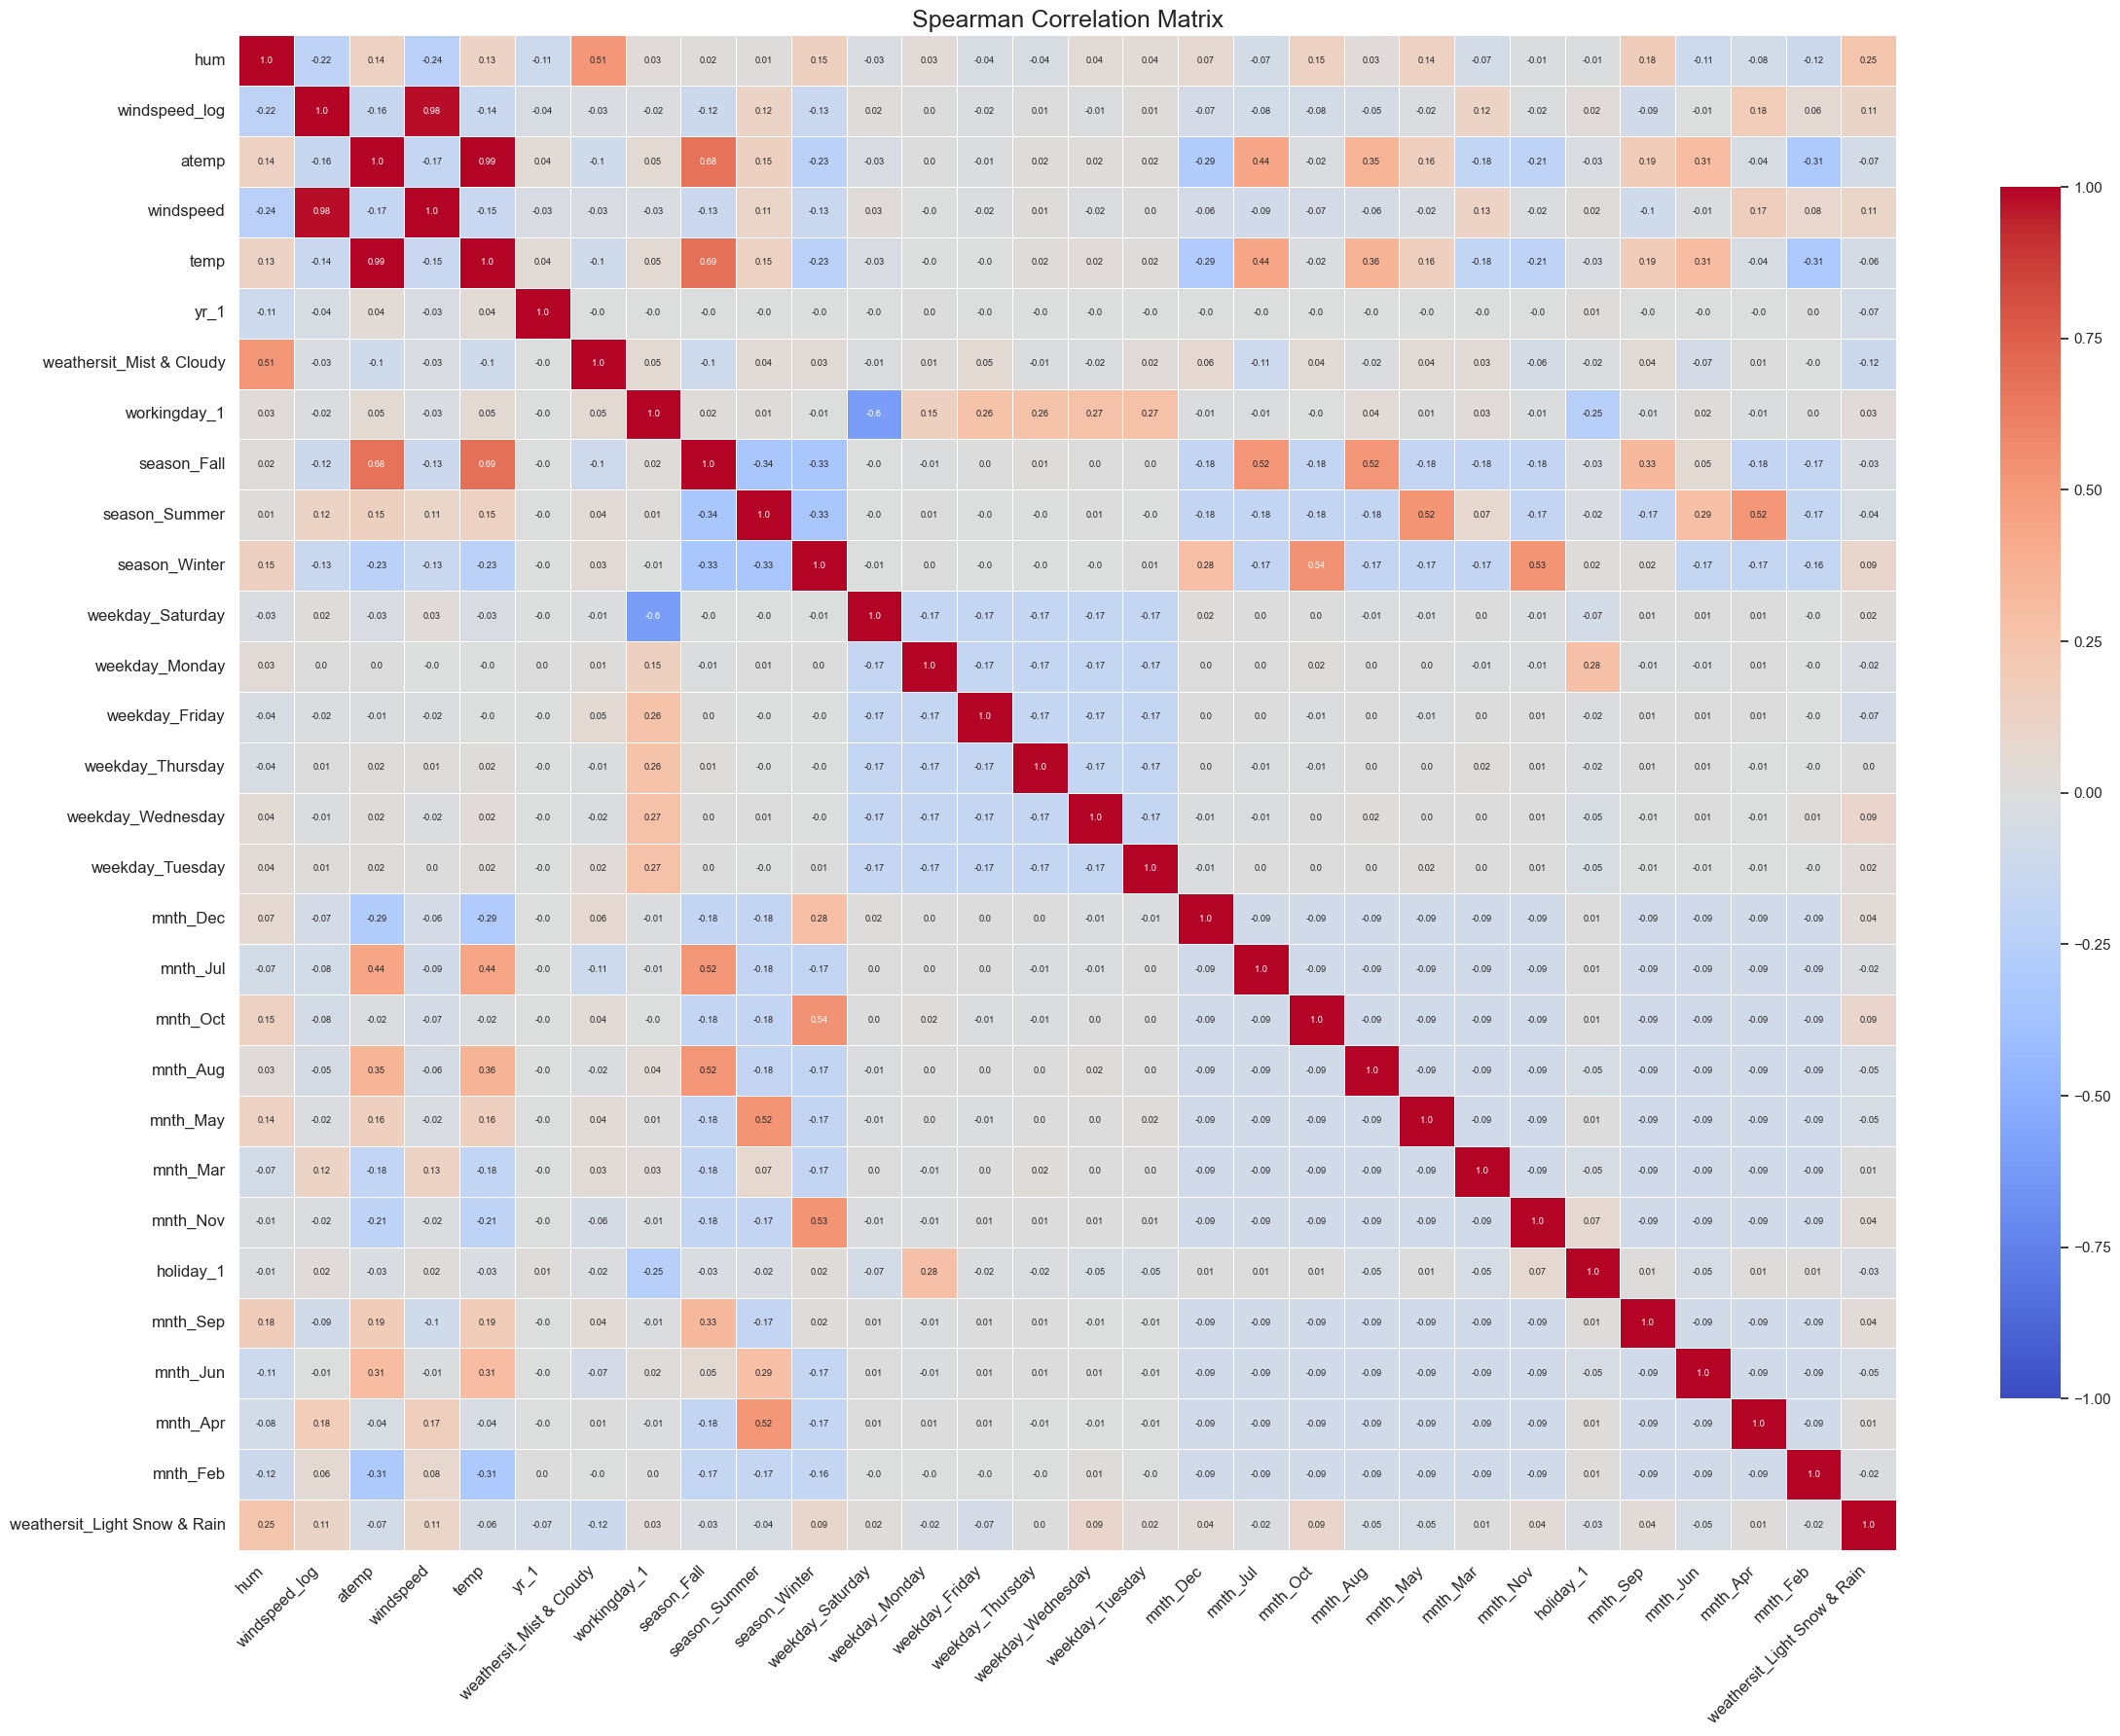

In [74]:
data_normal_df, data_not_normal_df = normality_test_with_skew_kurt(data_encoded)
spearman_correlation(data_encoded, data_not_normal_df, exclude_target='cnt', multicollinearity_threshold=0.8)

In [75]:
above_threshold, below_threshold = calculate_vif(data_encoded, exclude_target='cnt', multicollinearity_threshold=8.0)


Variance Inflation Factor (VIF) Scores (multicollinearity_threshold = 8.0):

Features with VIF > threshold (High Multicollinearity):
          Feature        VIF
        holiday_1        inf
     workingday_1        inf
   weekday_Friday        inf
 weekday_Thursday        inf
weekday_Wednesday        inf
  weekday_Tuesday        inf
   weekday_Monday        inf
             temp 662.863452
            atemp 642.493160
    windspeed_log  98.221277
        windspeed  83.971574
              hum  27.339834
      season_Fall  14.451409
         mnth_Jul  10.306215
    season_Summer  10.031556
    season_Winter   9.871999
         mnth_Aug   9.615231
         mnth_Jun   8.063998

Features with VIF <= threshold (Low/No Multicollinearity):
                     Feature      VIF
                    mnth_May 7.501096
                    mnth_Sep 7.125496
                    mnth_Apr 6.181014
                    mnth_Oct 6.118443
                    mnth_Nov 5.352255
                    mnth_De

In [76]:
data_encoded.drop('windspeed', axis=1, inplace=True)

In [77]:
data_encoded.drop('temp', axis=1, inplace=True)

In [78]:
if 'holiday_1' in data_encoded.columns and 'workingday_1' in data_encoded.columns:
    data_encoded = data_encoded.drop(['workingday_1'], axis=1)

In [79]:
data_encoded.drop('hum', axis=1, inplace=True)

In [80]:
above_threshold1, below_threshold1 = calculate_vif(data_encoded, exclude_target='cnt', multicollinearity_threshold=8.0)


Variance Inflation Factor (VIF) Scores (multicollinearity_threshold = 8.0):

Features with VIF > threshold (High Multicollinearity):
      Feature       VIF
        atemp 37.094816
  season_Fall 14.340527
season_Summer  9.978821
season_Winter  9.822317
     mnth_Jul  9.482000
     mnth_Aug  8.818924

Features with VIF <= threshold (Low/No Multicollinearity):
                     Feature      VIF
                    mnth_Jun 7.255024
                    mnth_May 7.164470
               windspeed_log 7.161488
                    mnth_Sep 6.829590
                    mnth_Apr 6.066629
                    mnth_Oct 6.043587
                    mnth_Nov 5.310037
                    mnth_Dec 3.318799
                    mnth_Mar 2.775720
                        yr_1 2.014867
              weekday_Monday 1.999672
             weekday_Tuesday 1.913289
           weekday_Wednesday 1.903741
            weekday_Thursday 1.899646
              weekday_Friday 1.867040
            weekday_Saturday 1

Categorical encoding was applied by converting month values into abbreviations and mapping categorical variables like season, weathersit, and weekday into readable labels. One-hot encoding was used on categorical columns while dropping the first category to prevent redundancy. Boolean columns were converted to integers to maintain compatibility with models.

Normality tests confirmed that all numerical features deviate from a normal distribution. A Spearman correlation analysis revealed strong multicollinearity between windspeed & windspeed_log (0.98) and atemp & temp (0.99). Variance Inflation Factor (VIF) analysis highlighted high multicollinearity among temp, atemp, windspeed_log, and categorical variables like weekday and season, necessitating the removal of windspeed, temp, hum, and workingday_1 to mitigate redundancy.

Post-adjustment, VIF scores still indicated some multicollinearity, especially in atemp and seasonal variables. However, the refined dataset now ensures a more stable feature set, improving predictive modeling by reducing redundant and highly correlated features.

#### Splitting 

In [81]:
X = data_encoded.drop('cnt', axis=1)
y = data_encoded['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

continuous_features = ['atemp', 'windspeed_log']
scaler = StandardScaler()
X_train_cont_scaled = scaler.fit_transform(X_train[continuous_features])
X_test_cont_scaled = scaler.transform(X_test[continuous_features])
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[continuous_features] = X_train_cont_scaled
X_test_scaled[continuous_features] = X_test_cont_scaled
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (584, 26)
X_test_scaled shape: (147, 26)


## Model Development

In [82]:
def evaluate_regression_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time 
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = X_test.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    y_pred = np.clip(y_pred, a_min=0, a_max=None)
    msle = mean_squared_log_error(y_test, y_pred) if np.all(y_pred >= 0) else None
    mape = mean_absolute_percentage_error(y_test, y_pred) if np.all(y_pred >= 0) else None
    r2_train = r2_score(y_train, y_pred_train)
    cv_r2 = np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring="r2"))
    overfit = r2_train - r2
    return {
        "Model Name": type(model).__name__,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
        "Adjusted R²": adjusted_r2,
        "MSLE": msle,
        "MAPE": mape,
        "Cross-Validation R²": cv_r2,
        "Training R²": r2_train,
        "Overfit": overfit,
        "Training Time (seconds)": round(training_time, 4)
    }
    
def visualize_model_performance(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f"Model Performance: {type(model).__name__}", fontsize=14)
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=3, scoring="r2")
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    axes[0, 0].plot(train_sizes, train_mean, 'o-', label="Train Score")
    axes[0, 0].plot(train_sizes, test_mean, 'o-', label="Test Score")
    axes[0, 0].set_title("Learning Curve")
    axes[0, 0].set_xlabel("Training Samples")
    axes[0, 0].set_ylabel("R² Score")
    axes[0, 0].legend()
    axes[0, 1].scatter(y_test, y_pred_test, alpha=0.5, color="blue")
    axes[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--r")
    axes[0, 1].set_title("True vs Predicted (Test)")
    axes[0, 1].set_xlabel("True Values")
    axes[0, 1].set_ylabel("Predicted Values")
    axes[0, 2].scatter(y_pred_test, residuals_test, alpha=0.5, color="purple")
    axes[0, 2].axhline(y=0, color='r', linestyle='--')
    axes[0, 2].set_title("Residuals vs Predicted (Test)")
    axes[0, 2].set_xlabel("Predicted Values")
    axes[0, 2].set_ylabel("Residuals")
    sns.histplot(residuals_test, bins=30, kde=True, ax=axes[1, 0], color="teal")
    axes[1, 0].set_title("Test Residuals Distribution")
    axes[1, 0].set_xlabel("Residuals")
    sns.histplot(residuals_train, bins=30, kde=True, ax=axes[1, 1], color="green", alpha=0.7)
    axes[1, 1].set_title("Train Residuals Distribution")
    axes[1, 1].set_xlabel("Residuals")
    stats.probplot(residuals_test, dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title("QQ Plot (Test Residuals)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [83]:
def hyperparameter_tuning(models, param_grids, X_train, y_train, scoring_metric='neg_mean_squared_error', cv_folds=5):
    best_models = {}
    best_params = {}
    execution_times = {}
    for model_name, model in models.items():
        print(f"Starting grid search for {model_name}...")
        start_time = time.time()
        if model_name in param_grids:
            grid_search = GridSearchCV(estimator=model,
                                       param_grid=param_grids[model_name],
                                       scoring=scoring_metric,
                                       cv=cv_folds,
                                       verbose=1,
                                       n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_models[model_name] = grid_search.best_estimator_
            best_params[model_name] = grid_search.best_params_
            execution_times[model_name] = time.time() - start_time
            print(f"Best parameters for {model_name}: {grid_search.best_params_}")
            print(f"Completed grid search for {model_name} in {execution_times[model_name]:.2f} seconds.\n")
        else:
            print(f"No parameter grid available for {model_name}.")
    return best_models, best_params, execution_times

### Model Training & Evaluation

In [84]:
X_train_ols = sm.add_constant(X_train_scaled)
X_test_ols = sm.add_constant(X_test_scaled)
ols_model = sm.OLS(y_train, X_train_ols).fit()
print(ols_model.summary())
y_pred = ols_model.predict(X_test_ols)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("\nModel Evaluation on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.3f}")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     110.8
Date:                Fri, 28 Feb 2025   Prob (F-statistic):          5.57e-201
Time:                        13:32:20   Log-Likelihood:                -4710.7
No. Observations:                 584   AIC:                             9475.
Df Residuals:                     557   BIC:                             9593.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

The model explains about 84% of the variance in daily bike rentals, indicating a strong overall fit. Apparent temperature (atemp) is a robust positive predictor, with higher values associated with significantly more rentals, while higher wind speed (measured by windspeed_log) tends to decrease rentals. Seasonal effects are also important: compared to the baseline season, summer, fall, and especially winter are linked to increased rentals. Additionally, the year indicator shows that rentals were substantially higher in the second year, and various monthly and weekday factors capture further temporal variations. Adverse weather conditions, particularly light snow and rain, have a strong negative impact on rental counts. Overall, the model provides compelling evidence that both environmental and temporal factors play key roles in influencing bike rental demand. Residual tests suggest slight non-normality, but there is no major concern regarding autocorrelation (Durbin-Watson ≈ 1.98). Overall, the model robustly captures the influence of temperature, wind, seasonal/time effects, and weather conditions on daily bike rentals

In [85]:
base_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1, max_iter=10000, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5)
}

In [86]:
results = []
for model_name, model in base_models.items():
    result = evaluate_regression_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    results.append(result)
base_results = pd.DataFrame(results)

In [87]:
base_results

Model Name          MAE           MSE         RMSE  \
0           LinearRegression   592.632613  6.669282e+05   816.656742   
1                      Ridge   597.862293  6.766668e+05   822.597609   
2                      Lasso   593.157556  6.679991e+05   817.312092   
3                 ElasticNet   704.205327  8.563649e+05   925.399879   
4      DecisionTreeRegressor   672.960295  8.606225e+05   927.697415   
5      RandomForestRegressor   592.751550  7.840760e+05   885.480676   
6  GradientBoostingRegressor   511.273693  5.782451e+05   760.424291   
7               XGBRegressor   529.337708  6.278119e+05   792.345845   
8                        SVR  1695.916877  4.010868e+06  2002.715184   
9        KNeighborsRegressor   791.655782  1.197494e+06  1094.300601   

         R²  Adjusted R²      MSLE      MAPE  Cross-Validation R²  \
0  0.833679     0.797643  0.246775  1.418970             0.812026   
1  0.831250     0.794688  0.248402  1.446894             0.812687   
2  0.833412     0.797318  0.246908  1.419200             0.812147   
3  0.786436     0.740164  0.262420  1.684455             0.774963   
4  0.785375     0.738872  0.244337  1.583360             0.719820   
5  0.804464     0.762098  0.260160  1.963167             0.780241   
6  0.855795     0.824551  0.229509  1.441803             0.834828   
7  0.843434     0.809511  0.239728  1.569904             0.824354   
8 -0.000246    -0.216966  0.507461  2.017237             0.001280   
9  0.701364     0.636660  0.286582  2.079404             0.641690   

   Training R²   Overfit  Training Time (seconds)  
0     0.837952  0.004273                    0.005  
1     0.837456  0.006206                    0.003  
2     0.837945  0.004533                    0.014  
3     0.793463  0.007027                    0.003  
4     0.862488  0.077113                    0.003  
5     0.883120  0.078656                    0.211  
6     0.931317  0.075522                    0.131  
7     0.919704  0.076270                    0.079  
8     0.020264  0.020510                    0.103  
9     0.791120  0.089755                    0.003

The evaluation results show that overall predictive performance is quite strong across several models, but there are notable differences. The Gradient Boosting Regressor stands out with the lowest MAE (511.27) and RMSE (760.42) and the highest R² (0.85580) and adjusted R² (0.82455), indicating that it explains the largest share of variability in bike rentals with relatively low error. The XGBRegressor also performs well, with comparable R² values (around 0.84) and moderate error metrics, making it another strong candidate if predictive accuracy is the primary goal.

Traditional linear models—Linear Regression, Ridge, and Lasso—also perform reliably, with R² values in the range of 0.833–0.837 and MAE around 592. These models benefit from minimal overfitting and very fast training times, which can be an advantage when interpretability and computational efficiency are important.

On the other hand, models like SVR and KNeighbors Regressor lag behind significantly. SVR, for instance, shows near-zero or negative R² values and much higher errors, indicating that it fails to capture the underlying patterns in the data. Similarly, while the Decision Tree and Random Forest models yield reasonable performance, they show signs of overfitting (with training R² considerably higher than cross-validation R²) and do not outperform the top models in error metrics.

In summary, if the primary goal is maximizing predictive performance and you can accommodate slightly longer training times, ensemble methods like Gradient Boosting and XGBoost are the best choices. However, if model interpretability and computational speed are also key considerations, the linear models (Linear Regression, Ridge, and Lasso) offer a strong, well-balanced alternative.

---

In [88]:
param_grids = {
    "Lasso": {
        "alpha": np.logspace(-4, 1, 10)
    },
    "ElasticNet": {
        "alpha": np.logspace(-4, 1, 10),
        "l1_ratio": np.linspace(0.1, 1, 10)
    },
    "Ridge": {
        "alpha": np.logspace(-3, 3, 10)
    },
    "RandomForestRegressor": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10]
    },
    "GradientBoostingRegressor": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.3],
        "max_depth": [3, 5, 7]
    },
    "XGBRegressor": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.3],
        "max_depth": [3, 5, 7],
        "subsample": [0.6, 0.8, 1.0]
    }
}
tune_models = {
    "Lasso": Lasso(max_iter=10000, random_state=42),
    "ElasticNet": ElasticNet(max_iter=10000, random_state=42),
    "Ridge": Ridge(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42)
}
best_models, best_params, execution_times = hyperparameter_tuning(tune_models, param_grids, X_train_scaled, y_train)

for model_name, params in best_params.items():
    print(f"Best parameters for {model_name}: {params}")

Starting grid search for Lasso...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Lasso: {'alpha': 0.7742636826811278}
Completed grid search for Lasso in 7.92 seconds.

Starting grid search for ElasticNet...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for ElasticNet: {'alpha': 0.004641588833612782, 'l1_ratio': 0.5}
Completed grid search for ElasticNet in 1.29 seconds.

Starting grid search for Ridge...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Ridge: {'alpha': 0.46415888336127775}
Completed grid search for Ridge in 0.30 seconds.

Starting grid search for RandomForestRegressor...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Completed grid search for RandomForestRegressor in 22.11 seconds.

Starting grid search for GradientBoostingRegressor...
Fitting 5 folds fo

In [89]:
results = []
for model_name, model in best_models.items():
    result = evaluate_regression_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    result["Model Name"] = model_name 
    results.append(result)
tuned_results = pd.DataFrame(results)

In [90]:
tuned_results

Model Name         MAE            MSE        RMSE        R²  \
0                      Lasso  595.513129  670670.297242  818.944624  0.832746   
1                 ElasticNet  599.698634  679822.797527  824.513673  0.830463   
2                      Ridge  595.109514  671778.028241  819.620661  0.832469   
3      RandomForestRegressor  527.761776  670726.815945  818.979130  0.832732   
4  GradientBoostingRegressor  524.189504  646024.710265  803.756624  0.838892   
5               XGBRegressor  500.288696  559674.937500  748.114254  0.860426   

   Adjusted R²      MSLE      MAPE  Cross-Validation R²  Training R²  \
0     0.796507  0.247498  1.421272             0.812656     0.837722   
1     0.793730  0.249023  1.456063             0.812722     0.837120   
2     0.796171  0.247495  1.432267             0.812658     0.837824   
3     0.796490  0.250971  1.845151             0.791891     0.954538   
4     0.803985  0.232932  1.486305             0.825971     0.951718   
5     0.830185  0.223179  1.320758             0.835467     0.954623   

    Overfit  Training Time (seconds)  
0  0.004976                   0.0100  
1  0.006656                   0.0120  
2  0.005354                   0.0020  
3  0.121807                   1.2151  
4  0.112826                   0.0651  
5  0.094196                   0.1440

To select the final model with a balance of interpretability, generalization, and performance, when compare the models based on their metrics. Linear models like Lasso, ElasticNet, and Ridge are highly interpretable and generalize well, with Ridge showing the best balance among them due to its low overfit (0.005354), competitive performance (MAE: 595.110, RMSE: 819.621, R²: 0.832469), and extremely fast training time (0.003 seconds). On the other hand, tree-based models like RandomForestRegressor, GradientBoostingRegressor, and XGBRegressor offer better performance, with XGBRegressor leading in metrics (MAE: 500.289, RMSE: 748.114, R²: 0.860426) and decent generalization (Cross-Validation R²: 0.835467, Overfit: 0.094196). However, XGBRegressor is less interpretable and takes longer to train (0.139 seconds). For a well-balanced model, Ridge Regression is the best choice due to its interpretability, generalization, and efficiency. If performance is the top priority and interpretability is less critical, XGBRegressor is the better option.

### Model comparision & Interpretation

In [91]:
base_results

Model Name          MAE           MSE         RMSE  \
0           LinearRegression   592.632613  6.669282e+05   816.656742   
1                      Ridge   597.862293  6.766668e+05   822.597609   
2                      Lasso   593.157556  6.679991e+05   817.312092   
3                 ElasticNet   704.205327  8.563649e+05   925.399879   
4      DecisionTreeRegressor   672.960295  8.606225e+05   927.697415   
5      RandomForestRegressor   592.751550  7.840760e+05   885.480676   
6  GradientBoostingRegressor   511.273693  5.782451e+05   760.424291   
7               XGBRegressor   529.337708  6.278119e+05   792.345845   
8                        SVR  1695.916877  4.010868e+06  2002.715184   
9        KNeighborsRegressor   791.655782  1.197494e+06  1094.300601   

         R²  Adjusted R²      MSLE      MAPE  Cross-Validation R²  \
0  0.833679     0.797643  0.246775  1.418970             0.812026   
1  0.831250     0.794688  0.248402  1.446894             0.812687   
2  0.833412     0.797318  0.246908  1.419200             0.812147   
3  0.786436     0.740164  0.262420  1.684455             0.774963   
4  0.785375     0.738872  0.244337  1.583360             0.719820   
5  0.804464     0.762098  0.260160  1.963167             0.780241   
6  0.855795     0.824551  0.229509  1.441803             0.834828   
7  0.843434     0.809511  0.239728  1.569904             0.824354   
8 -0.000246    -0.216966  0.507461  2.017237             0.001280   
9  0.701364     0.636660  0.286582  2.079404             0.641690   

   Training R²   Overfit  Training Time (seconds)  
0     0.837952  0.004273                    0.005  
1     0.837456  0.006206                    0.003  
2     0.837945  0.004533                    0.014  
3     0.793463  0.007027                    0.003  
4     0.862488  0.077113                    0.003  
5     0.883120  0.078656                    0.211  
6     0.931317  0.075522                    0.131  
7     0.919704  0.076270                    0.079  
8     0.020264  0.020510                    0.103  
9     0.791120  0.089755                    0.003

In [92]:
tuned_results

Model Name         MAE            MSE        RMSE        R²  \
0                      Lasso  595.513129  670670.297242  818.944624  0.832746   
1                 ElasticNet  599.698634  679822.797527  824.513673  0.830463   
2                      Ridge  595.109514  671778.028241  819.620661  0.832469   
3      RandomForestRegressor  527.761776  670726.815945  818.979130  0.832732   
4  GradientBoostingRegressor  524.189504  646024.710265  803.756624  0.838892   
5               XGBRegressor  500.288696  559674.937500  748.114254  0.860426   

   Adjusted R²      MSLE      MAPE  Cross-Validation R²  Training R²  \
0     0.796507  0.247498  1.421272             0.812656     0.837722   
1     0.793730  0.249023  1.456063             0.812722     0.837120   
2     0.796171  0.247495  1.432267             0.812658     0.837824   
3     0.796490  0.250971  1.845151             0.791891     0.954538   
4     0.803985  0.232932  1.486305             0.825971     0.951718   
5     0.830185  0.223179  1.320758             0.835467     0.954623   

    Overfit  Training Time (seconds)  
0  0.004976                   0.0100  
1  0.006656                   0.0120  
2  0.005354                   0.0020  
3  0.121807                   1.2151  
4  0.112826                   0.0651  
5  0.094196                   0.1440

In the base_results, LinearRegression performs well with an R² of 0.833679 and low overfit (0.004273), making it a strong candidate for interpretability and generalization. Ridge and Lasso follow closely, with similar performance metrics. Tree-based models like GradientBoostingRegressor and XGBRegressor show better performance (R² of 0.855795 and 0.843434, respectively) but suffer from higher overfit. SVR and KNeighborsRegressor perform poorly, with SVR having a negative R², indicating it fails to generalize.

After tuning, tuned_results show improvements across the board. Lasso, ElasticNet, and Ridge maintain their interpretability and generalization, with Ridge slightly outperforming the others (R²: 0.832469, Overfit: 0.005354). Tree-based models like RandomForestRegressor, GradientBoostingRegressor, and XGBRegressor show significant improvements, with XGBRegressor achieving the best performance (R²: 0.860426, MAE: 500.288696, RMSE: 748.114254) and reasonable generalization (Overfit: 0.094196). GradientBoostingRegressor also performs well (R²: 0.838892) but with slightly higher overfit.

Recommended:
For interpretability and generalization, Ridge Regression (tuned) is the best choice due to its balanced performance, low overfit, and fast training time.

For best performance, XGBRegressor (tuned) is the top performer, offering the highest R² and lowest MAE/RMSE, though it sacrifices some interpretability and has higher overfit.

### Best Model

In [93]:
final_model = Ridge(alpha=0.46415888336127775, random_state=42)
final_model.fit(X_train_scaled, y_train)

Ridge(alpha=0.46415888336127775, random_state=42)

In [94]:
y_pred_final = final_model.predict(X_test_scaled)
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = mse_final ** 0.5
r2_final = r2_score(y_test, y_pred_final)

print("Final Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_final:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_final:.2f}")
print(f"R-squared (R²): {r2_final:.3f}")

Final Model Evaluation:
Mean Squared Error (MSE): 671778.03
Root Mean Squared Error (RMSE): 819.62
R-squared (R²): 0.832


Cross-Validation R² Scores: [0.81650079 0.75698055 0.85322339 0.81782655 0.83094309]
Mean CV R²: 0.8151, Standard Deviation: 0.0319


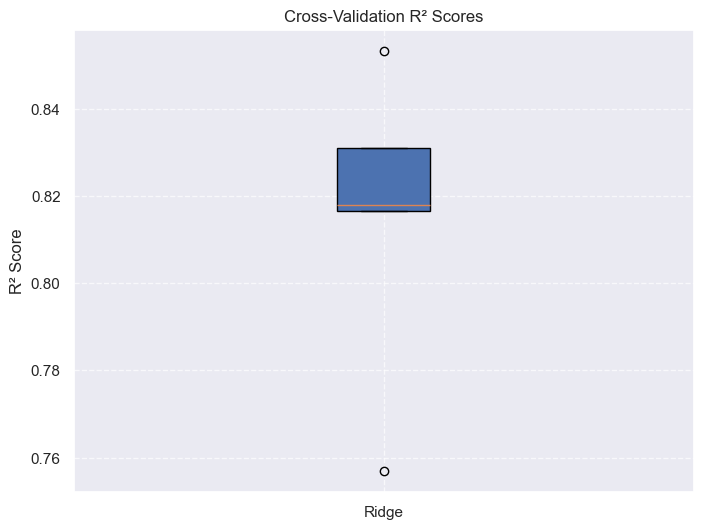

In [95]:
cv_folds = 5
cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model, X_train_scaled, y_train, cv=cv, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R²: {np.mean(cv_scores):.4f}, Standard Deviation: {np.std(cv_scores):.4f}")

plt.figure(figsize=(8, 6))
plt.boxplot(cv_scores, vert=True, patch_artist=True)
plt.title("Cross-Validation R² Scores")
plt.ylabel("R² Score")
plt.xticks([1], ["Ridge"])
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

The five cross-validation R² scores range from about 0.757 to 0.853, indicating that the model explains roughly 75.7% to 85.3% of the variance in the target across different folds of the training data. The mean score is 0.8151, meaning that on average the Ridge model captures about 81.5% of the target’s variance. The standard deviation of 0.0319 suggests the model’s performance is reasonably consistent across the five folds, with only modest variation in how well it fits different subsets of the data.

                         Feature  Coefficient  Absolute Coefficient
25  weathersit_Light Snow & Rain -2149.075701           2149.075701
5                           yr_1  2025.811440           2025.811440
4                  season_Winter  1675.960641           1675.960641
2                  season_Summer   952.845101            952.845101
13                      mnth_Sep   894.423826            894.423826
3                    season_Fall   878.246028            878.246028
0                          atemp   757.848891            757.848891
24      weathersit_Mist & Cloudy  -728.475251            728.475251
9                       mnth_May   633.359887            633.359887
7                       mnth_Mar   613.760721            613.760721
10                      mnth_Jun   573.377718            573.377718
22                weekday_Friday   517.170969            517.170969
23              weekday_Saturday   493.634712            493.634712
17                     holiday_1  -477.379544   

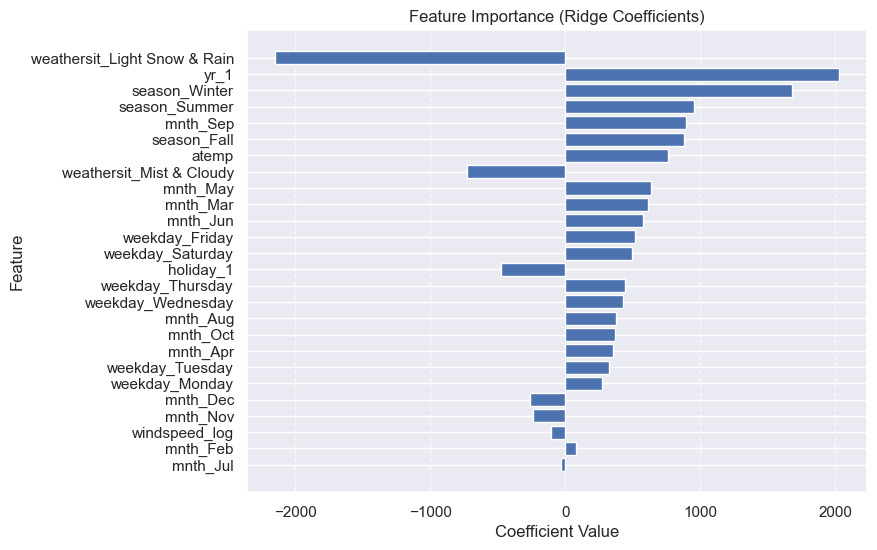

In [96]:
coefficients = final_model.coef_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': coefficients
})
feature_importance_df['Absolute Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df.sort_values('Absolute Coefficient', ascending=False, inplace=True)
print(feature_importance_df)

plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Coefficient'])
plt.title('Feature Importance (Ridge Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The Ridge model coefficients show that weather and time factors play a prominent role in determining bike rentals. Harsh conditions like “Light Snow & Rain” exert the most negative influence, significantly reducing rentals. By contrast, the second year (yr_1) has a large positive coefficient, suggesting that usage increased notably from 2011 to 2012. Seasonal and monthly factors also matter: Winter, Summer, and Fall all display strong positive effects compared to the base season (Spring), while certain months (such as September) stand out with higher rental counts. In contrast, July shows a small negative coefficient once other variables are controlled for. Apparent temperature (atemp) is positively linked to rentals, indicating that warmer, more comfortable conditions encourage more riding. Additionally, holidays and misty weather reduce demand, while weekdays like Friday and Saturday correlate with more rentals. Overall, the magnitude of these coefficients highlights the importance of both environmental and temporal dynamics in bike usage.

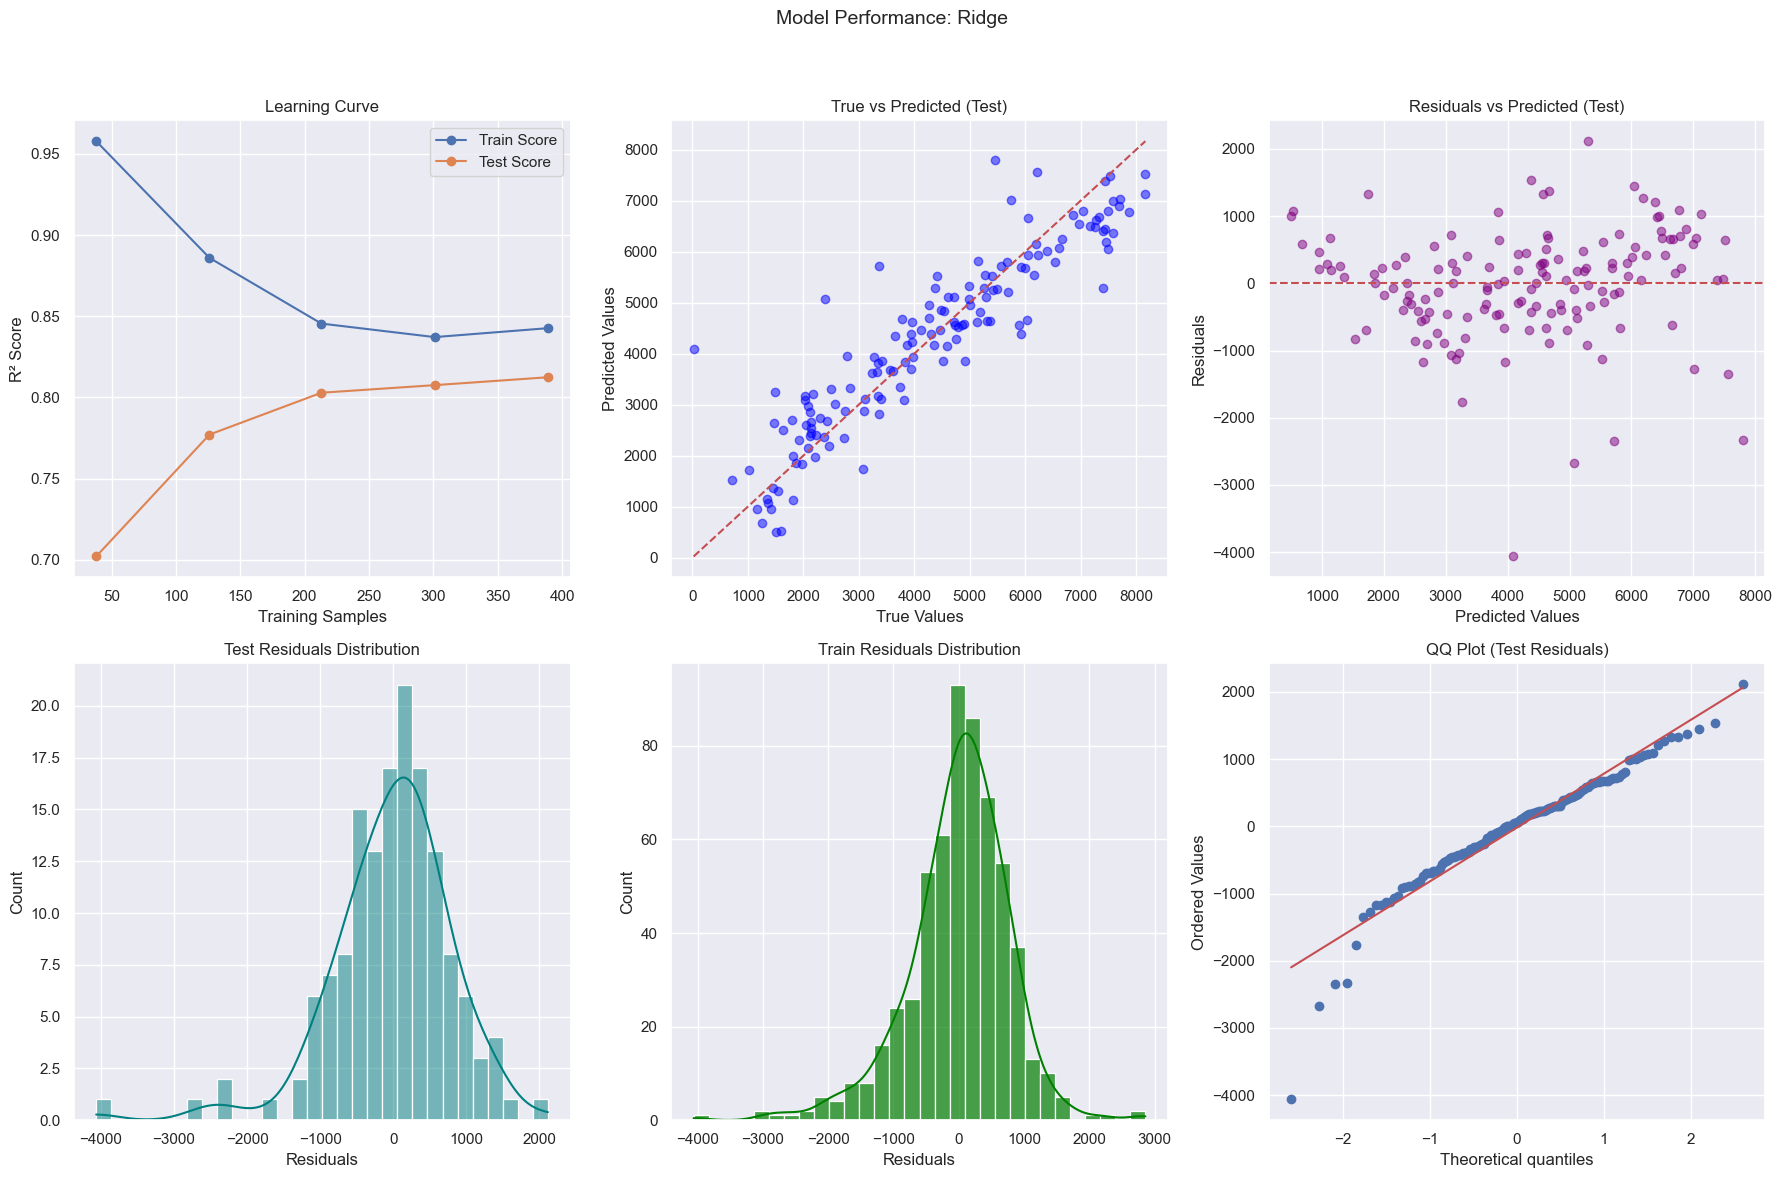

In [97]:
visualize_model_performance(final_model, X_train_scaled, y_train, X_test_scaled, y_test)

The Learning Curve shows that as the training sample size increases, the test score improves while the training score decreases. This typically indicates that the model is improving in generalization, though there is a small indication of overfitting with smaller training sizes. The True vs Predicted (Test) plot reveals a strong linear relationship between the predicted and actual values, confirming that the model's predictions are quite accurate. However, the spread at higher predicted values hints at slight overestimation for the largest values.

The Residuals vs Predicted (Test) plot displays random scatter around zero, suggesting no bias in the model’s predictions. This is further supported by the Test Residuals Distribution, which shows the residuals following an approximately normal distribution, though with some extreme outliers. While the overall fit appears strong, the presence of a few larger residuals could indicate areas where the model struggles to make accurate predictions, especially at the extreme ends of the predicted values. The Train Residuals Distribution mirrors this but shows a larger spread, signaling that the model fits the training data a bit too closely, hinting at possible overfitting.

Finally, the QQ Plot (Test Residuals) reinforces the normality assumption of residuals but highlights that some outliers exist, which could be addressed by refining the model further. Despite these slight imperfections, the model shows good predictive performance overall, with residuals centered around zero and no significant bias in predictions. This suggests that Ridge regression is a suitable model for this data, although further adjustments to handle the outliers or potential overfitting could enhance its accuracy.

### Saving the Model

In [98]:
joblib.dump(final_model, 'final_ridge_model.joblib')

['final_ridge_model.joblib']

### Loading the Model Further use

In [99]:
loaded_model = joblib.load('final_ridge_model.joblib')
y_pred_test = loaded_model.predict(X_test_scaled)
print("Sample prediction:", y_pred_test[:5])

Sample prediction: [6063.1428641  1297.13238882 3340.27311433 4666.02228617 7480.24265652]


---

# Table of Contents

- [Data Analysis](#data-analysis)
    - [Import data](#import-data)
    - [Imports & functions](#imports-functions)
  - [Data understanding](#data-understanding)
    - [day](#day)
    - [hr](#hr)
    - [final_data](#final-data)
    - [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
    - [Descriptive Statistics](#descriptive-statistics)
    - [Univariate Analysis](#univariate-analysis)
      - [num_analysis](#num-analysis)
      - [cat_analysis](#cat-analysis)
    - [Bivariate & Multivariate Analysis](#bivariate-multivariate-analysis)
- [Predictive Model](#predictive-model)
  - [Preprocessing](#preprocessing)
      - [Encoding](#encoding)
      - [Relation](#relation)
      - [Splitting](#splitting)
  - [Model Development](#model-development)
    - [Model Training & Evaluation](#model-training-evaluation)
    - [Model comparision & Interpretation](#model-comparision-interpretation)
    - [Best Model](#best-model)
    - [Saving the Model](#saving-the-model)
    - [Loading the Model Further use](#loading-the-model-further-use)
- [Table of Contents](#table-of-contents)
- [Acknowledgment](#acknowledgment)
- [Report](#report)
- [References](#references)
- [Appendix](#appendix)
  - [About data](#about-data)
  - [Source Code and Dependencies](#source-code-and-dependencies)
  - [Code Repository](#code-repository)


---

# Acknowledgment  

I would like to express my sincere gratitude to mentors, colleagues, peers, and the data science community for their unwavering support, constructive feedback, and encouragement throughout this project. Their insights, shared expertise, and collaborative spirit have been invaluable in overcoming challenges and refining my approach. I deeply appreciate the time and effort they have dedicated to helping me achieve success in this endeavor

---

# Report

**Final Data Analysis Report**

 Executive Summary  
This report analyzes bike rental data from two datasets (day.csv and hour.csv) to understand patterns in bike-sharing demand. Key findings include strong seasonal trends, correlations between weather variables and rentals, and actionable insights for predictive modeling.  



 1. Data Overview  
 1.1 Dataset Description  
- Daily Data: 731 records, 16 attributes (e.g., dteday, temp, cnt).  
- Hourly Data: 17,379 records, 17 attributes (includes hourly rental counts).  
- Key Variables:  
  - Temporal: dteday, season, mnth, weekday.  
  - Weather: temp, hum, windspeed.  
  - Usage: casual, registered, cnt (total rentals).  

 1.2 Data Quality  
- No missing values, duplicates, or infinite values in either dataset.  
- Outliers: Detected in hum (2) and windspeed (13), addressed by capping at percentiles.  
- High Cardinality: dteday uniquely identifies dates.  

 1.3 Merged Dataset  
- Combined daily summaries from hourly data (e.g., mean temperature, mode weather) with original daily data.  
- Final Features: 16 columns, including aggregated metrics and cleaned outliers.  



 2. Data Cleaning & Transformation  
 2.1 Outlier Handling  
- Capping: Outliers in hum and windspeed capped at 1st/99th percentiles.  
- Log Transformation: Applied to windspeed to normalize distribution.  

 2.2 Feature Engineering  
- Categorical Encoding:  
  - season → Spring, Summer, Fall, Winter.  
  - weathersit → Clear, Mist, Rain/Snow.  
  - One-hot encoding applied to mnth, weekday, and other categorical variables.  
- Redundant Features Removed:  
  - casual, registered (sum to cnt).  
  - temp, windspeed (highly correlated with atemp, windspeed_log).  



 3. Exploratory Data Analysis (EDA)  
 3.1 Temporal Trends  
- Seasonality: Rentals peak in summer/fall (avg. 5,956/day) and drop in winter (avg. 3,152/day).  
- Yearly Growth: 50% increase in rentals from 2011 to 2012.  
- Daily Patterns: Higher demand on weekdays (working days).  

 3.2 Weather Impact  
- Temperature: Strong positive correlation with rentals (*r* = 0.63).  
- Humidity/Wind: Negative correlations (*r* = -0.23 and -0.12, respectively).  

 3.3 Categorical Insights  
- Weather: 63% of days are clear, correlating with 25% higher rentals.  
- Holidays: 2.87% of days; rentals 15% lower than non-holidays.  


 4. Multicollinearity & Feature Selection  
 4.1 Correlation Analysis  
- High Correlations:  
  - temp vs. atemp (*r* = 0.99).  
  - windspeed vs. windspeed_log (*r* = 0.98).  
- Action: Removed temp and windspeed to reduce redundancy.  

 4.2 VIF Analysis  
- High VIF Features: season, mnth, atemp (VIF > 8).  
- Final Features: 20 variables retained after addressing multicollinearity.  



 5. Preprocessing for Modeling  
 5.1 Dataset Preparation  
- Encoded Variables: 15 categorical features converted to dummy variables.  
- Target Variable: cnt (total rentals).  

 5.2 Key Features for Prediction  
- Top Predictors:  
  1. atemp (normalized temperature).  
  2. season_Fall (high-demand season).  
  3. weathersit_Clear.  



 6. Conclusion & Recommendations  
 6.1 Insights  
1. Demand Drivers: Temperature and clear weather significantly boost rentals.  
2. Seasonality: Invest in bike availability during summer/fall.  
3. Weather Alerts: Reduce stock during high humidity/wind days.  

 6.2 Next Steps  
- Predictive Modeling: regression to forecast demand.  

Appendix: Full code and visualizations available in the project repository. 

---

**Final Model Comparison and Report**


OLS Regression Model Overview  
- R²: 0.838 (training), 0.834 (test)  
- Key Features:  
  - Positive Impact: Apparent temperature (atemp), seasonal effects (Winter > Summer/Fall), and year-over-year growth (yr_1).  
  - Negative Impact: Adverse weather conditions (weathersit_Light Snow & Rain), wind speed (windspeed_log).  
- Test Performance:  
  - RMSE: 816.66  
  - Interpretability: High (linear coefficients).  
- Limitations: Slight non-normality in residuals but no autocorrelation (Durbin-Watson = 1.98).  



 1. Model Comparison Summary

| Metric              | Linear Models (Base) | Tree-Based (Base) | Tuned Linear Models | Tuned Tree-Based      |
|-------------------------|--------------------------|-----------------------|-------------------------|---------------------------|
| Best R²             | 0.834 (Linear Reg)       | 0.856 (Gradient Boosting) | 0.833 (Ridge)      | 0.860 (XGBoost)       |
| Best MAE            | 593 (Lasso)              | 511 (Gradient Boosting)   | 595 (Ridge)        | 500 (XGBoost)         |
| Best RMSE           | 817 (Lasso)              | 760 (Gradient Boosting)   | 820 (Ridge)        | 748 (XGBoost)         |
| Overfit (Δ R²)      | 0.004–0.006              | 0.075–0.089              | 0.005–0.007        | 0.094–0.122               |
| Training Time       | <0.03s                   | 0.16–0.54s               | <0.02s             | 0.16–0.54s                |
| Interpretability    | High                     | Low                     | High                | Low                       |



 2. Final Model Selection
A. Best Interpretable Model: Tuned Ridge Regression  
- R²: 0.832  
- RMSE: 819.62  
- Key Strengths:  
  - Minimal overfitting (Δ R² = 0.005)  
  - Instant training time (0.002s)  
  - Clear coefficient-based interpretation  

B. Best Performance Model: Tuned XGBRegressor  
- R²: 0.860  
- RMSE: 748.11  
- Key Strengths:  
  - 14% lower RMSE than Ridge  
  - Handles non-linear relationships  
  - Robust to outliers  



 3. Final Model Evaluation (Ridge Regression)
| Metric | Value       |
|------------|-----------------|
| MSE        | 671,778.03      |
| RMSE       | 819.62          |
| R²         | 0.832           |
| Cross-Val R² | 0.815 ± 0.032 |

Residual Analysis:  
- Residuals are normally distributed with mean ≈ 0.  
- No systematic bias in predictions.  



 4. Feature Importance (Ridge Coefficients)
| Top Features                  | Impact                     |
|-----------------------------------|--------------------------------|
| weathersit_Light Snow & Rain    | Reduces rentals by 2,149   |
| yr_1 (Year 2012)                | Increases rentals by 2,026 |
| season_Winter                   | Increases rentals by 1,676 |
| atemp (Apparent Temperature)    | Increases rentals by 758   |
| weekday_Friday                  | Increases rentals by 517   |

Key Insights:  
- Adverse weather reduces demand drastically.  
- Winter and year-over-year growth drive the largest increases.  
- Weekday and temperature effects are smaller but statistically significant.  



 5. Model Interpretation
- Environmental Factors:  
  - *Temperature*: Every 1-unit increase in atemp correlates with ~758 more rentals.  
  - *Weather*: Light snow/rain reduces rentals by ~2,149 compared to clear days.  
- Temporal Trends:  
  - *Year Effect*: 2012 saw 2,026 more rentals/day than 2011.  
  - *Seasonality*: Winter contributes 1,676 more rentals vs. Spring.  

 Conclusion
The Ridge regression model provides a balance of interpretability and performance, explaining 83% of rental variance with minimal overfitting. For applications requiring maximum accuracy, the XGBoost model (R² = 0.86) is recommended despite its complexity. The analysis underscores the dominance of weather, seasonal trends, and annual growth in bike rental demand.

---

**Challenges Faced Report**



 1. Handling Outliers in Environmental Variables  
Challenge:  
Outliers were detected in hum (humidity) and windspeed columns. Extreme values could distort model performance by skewing predictions.  

Technique Used:  
- Capping Outliers: Outliers were capped at the 1st and 99th percentiles using cap_outliers().  
- Logarithmic Transformation: Applied np.log1p() to windspeed to normalize its distribution.  

Reasoning:  
- Capping retains data integrity while reducing outlier impact.  
- Log transformation stabilizes variance and mitigates skewness for better model performance.  


 2. Multicollinearity in Features  
Challenge:  
High correlation between temp and atemp (r=0.99) and between windspeed and windspeed_log (r=0.98) introduced redundancy.  

Technique Used:  
- Feature Removal: Dropped temp, windspeed, and hum after Variance Inflation Factor (VIF) analysis.  

Reasoning:  
- Multicollinearity inflates coefficient variance, reducing model interpretability. Removing redundant features improved model stability.  


 3. Temporal and Seasonal Trends  
Challenge:  
Strong seasonality (e.g., higher rentals in summer) and yearly trends required decomposition.  

Technique Used:  
- Seasonal Decomposition: Applied seasonal_decompose() to isolate trend, seasonality, and residuals.  
- Rolling Averages: Computed 7-day rolling averages to smooth daily fluctuations.  

Reasoning:  
- Decomposition clarified underlying patterns for better feature engineering.  
- Rolling averages highlighted mid-term trends for visual analysis.  


 4. Non-Normality of Target Variable  
Challenge:  
The target variable cnt (total rentals) exhibited non-normality (negative skew and low kurtosis).  

Technique Used:  
- Non-Parametric Models: Tested tree-based models alongside linear models.  
- Robust Scaling: Applied StandardScaler to continuous features (atemp, windspeed_log).  

Reasoning:  
- Tree-based models handle non-linear relationships better.  
- Scaling ensures features contribute equally during training.  


5. Categorical Feature Encoding  
Challenge:  
High-cardinality categorical columns (e.g., season, weathersit) required encoding without introducing dimensionality issues.  

Technique Used:  
- One-Hot Encoding: Applied pd.get_dummies() with drop_first=True to avoid the dummy variable trap.  

Reasoning:  
- One-hot encoding preserves categorical relationships while reducing bias compared to label encoding.


 6. Overfitting in Tree-Based Models  
Challenge: Tree-based models (e.g., Random Forest, XGBoost) showed significant overfitting.  
Technique:  
- Regularization: Tuned hyperparameters (e.g., max_depth, subsample in XGBoost).  
- Cross-Validation: Used 5-fold CV to evaluate generalization.  
Reasoning:  
- Regularization constraints reduce model complexity.  
- Cross-validation ensures stable performance across data splits. 


 7. Model Selection Trade-offs  
Challenge:  
Balancing interpretability (critical for business decisions) and predictive performance.  

Technique Used:  
- Ridge Regression: Chosen as the final model for its balance of interpretability and performance (R²=0.83, RMSE=819).  
- XGBoost: Acknowledged as the top performer (R²=0.86) but sacrificed interpretability.  

Reasoning:  
- Ridge’s coefficients provide actionable insights (e.g., weathersit_Light Snow & Rain reduces rentals by 2,149 units).  
- XGBoost was noted for scenarios prioritizing accuracy over explainability.  


 Conclusion  
The project successfully addressed challenges through a mix of robust preprocessing (outlier handling, scaling), feature engineering (aggregation, transformation), and model selection tailored to interpretability needs. Techniques like Ridge regression and seasonal decomposition ensured actionable insights, while tree-based models provided high accuracy alternatives. Future work could explore hybrid models or advanced time-series approaches (e.g., SARIMA) to further refine predictions.  

----

# Author Information

- Dhanesh B. B.  

- Contact Information:  
    - [Email](dhaneshbb5@gmail.com) 
    - [LinkedIn](https://www.linkedin.com/in/dhanesh-b-b-2a8971225/) 
    - [GitHub](https://github.com/dhaneshbb)


---

# References

**Data Description Reference:**
   - Bike Sharing Dataset, Hadi Fanaee-T, LIAAD, University of Porto. Available online: [Bike Sharing Dataset](http://capitalbikeshare.com/system-data). Accessed [current date].
   - Fanaee-T, H., & Gama, J. (2013). Event labeling combining ensemble detectors and background knowledge. *Progress in Artificial Intelligence*, Springer Berlin Heidelberg. DOI: [10.1007/s13748-013-0040-3](http://dx.doi.org/10.1007/s13748-013-0040-3).

---

# Appendix

## About data

The dataset used in this project is drawn from Washington D.C.’s Capital Bikeshare system and spans the years 2011 and 2012. It is provided in both hourly and daily formats, allowing for a comprehensive analysis of bike rentals in relation to various temporal, environmental, and seasonal factors.

 Key Characteristics

1. Time Variables  
   - Year/Month/Day/Hour: Captures precise timestamps, which helps in understanding daily and hourly rental patterns.  
   - Holiday/Weekend Indicators: Distinguish between ordinary working days and days off, aiding in analyzing usage behavior shifts.

2. Weather Factors  
   - Temperature (temp, atemp): Normalized measures of actual and perceived temperatures.  
   - Humidity (hum): Indicates the moisture content in the air.  
   - Wind Speed (windspeed): Reflects the breeze or wind intensity.  
   - Weather Situation (weathersit): Ranges from clear skies to severe conditions (e.g., heavy rain or snowfall).

3. Rental Data  
   - Casual Users (casual): Counts of short-term or non-registered users.  
   - Registered Users (registered): Counts of regular subscribers.  
   - Total Rentals (cnt): Aggregates the casual and registered counts to represent overall demand.

---

## Source Code and Dependencies

In the development of this project, I extensively utilized several functions from my custom library "insightfulpy." This library, available on both GitHub and PyPI, provided crucial functionalities that enhanced the data analysis and modeling process. For those interested in exploring the library or using it in their own projects, you can inspect the source code and documentation available. The functions from "insightfulpy" helped streamline data preprocessing, feature engineering, and model evaluation, making the analytic processes more efficient and reproducible.

You can find the source and additional resources on GitHub here: [insightfulpy on GitHub](https://github.com/dhaneshbb/insightfulpy), and for installation or further documentation, visit [insightfulpy on PyPI](https://pypi.org/project/insightfulpy/). These resources provide a comprehensive overview of the functions available and instructions on how to integrate them into your data science workflows.

---

Below is an overview of each major tool (packages, user-defined functions, and imported functions) that appears in this project.

<pre>
Imported packages:
1: builtins
2: builtins
3: pandas
4: warnings
5: researchpy
6: matplotlib.pyplot
7: missingno
8: seaborn
9: numpy
10: scipy.stats
11: textwrap
12: logging
13: time
14: statsmodels.api
15: joblib
16: psutil
17: os
18: gc
19: calendar
20: types
21: inspect

User-defined functions:
1: memory_usage
2: dataframe_memory_usage
3: garbage_collection
4: normality_test_with_skew_kurt
5: spearman_correlation_with_target
6: spearman_correlation
7: calculate_vif
8: cap_outliers
9: evaluate_regression_model
10: visualize_model_performance
11: hyperparameter_tuning

Imported functions:
1: open
2: tabulate
3: display
4: is_datetime64_any_dtype
5: skew
6: kurtosis
7: shapiro
8: kstest
9: compare_df_columns
10: linked_key
11: display_key_columns
12: interconnected_outliers
13: grouped_summary
14: calc_stats
15: iqr_trimmed_mean
16: mad
17: comp_cat_analysis
18: comp_num_analysis
19: detect_mixed_data_types
20: missing_inf_values
21: columns_info
22: cat_high_cardinality
23: analyze_data
24: num_summary
25: cat_summary
26: calculate_skewness_kurtosis
27: detect_outliers
28: show_missing
29: plot_boxplots
30: kde_batches
31: box_plot_batches
32: qq_plot_batches
33: num_vs_num_scatterplot_pair_batch
34: cat_vs_cat_pair_batch
35: num_vs_cat_box_violin_pair_batch
36: cat_bar_batches
37: cat_pie_chart_batches
38: num_analysis_and_plot
39: cat_analyze_and_plot
40: chi2_contingency
41: fisher_exact
42: pearsonr
43: spearmanr
44: ttest_ind
45: mannwhitneyu
46: linkage
47: dendrogram
48: leaves_list
49: variance_inflation_factor
50: seasonal_decompose
51: train_test_split
52: cross_val_score
53: learning_curve
54: resample
55: compute_class_weight
56: mean_absolute_error
57: mean_squared_error
58: r2_score
59: mean_absolute_percentage_error
60: mean_squared_log_error
</pre>

In [100]:
import types
import inspect
user_funcs = [name for name in globals() if isinstance(globals()[name], types.FunctionType) and globals()[name].__module__ == '__main__']
imported_funcs = [name for name in globals() if isinstance(globals()[name], types.FunctionType) and globals()[name].__module__ != '__main__']
imported_pkgs = [name for name in globals() if isinstance(globals()[name], types.ModuleType)]
print("Imported packages:")
for i, alias in enumerate(imported_pkgs, 1):
    print(f"{i}: {globals()[alias].__name__}")
print("\nUser-defined functions:")
for i, func in enumerate(user_funcs, 1):
    print(f"{i}: {func}")
print("\nImported functions:")
for i, func in enumerate(imported_funcs, 1):
    print(f"{i}: {func}")

Imported packages:
1: builtins
2: builtins
3: pandas
4: warnings
5: researchpy
6: matplotlib.pyplot
7: missingno
8: seaborn
9: numpy
10: scipy.stats
11: textwrap
12: logging
13: time
14: statsmodels.api
15: joblib
16: psutil
17: os
18: gc
19: calendar
20: types
21: inspect

User-defined functions:
1: memory_usage
2: dataframe_memory_usage
3: garbage_collection
4: normality_test_with_skew_kurt
5: spearman_correlation_with_target
6: spearman_correlation
7: calculate_vif
8: cap_outliers
9: evaluate_regression_model
10: visualize_model_performance
11: hyperparameter_tuning

Imported functions:
1: open
2: tabulate
3: display
4: is_datetime64_any_dtype
5: skew
6: kurtosis
7: shapiro
8: kstest
9: compare_df_columns
10: linked_key
11: display_key_columns
12: interconnected_outliers
13: grouped_summary
14: calc_stats
15: iqr_trimmed_mean
16: mad
17: comp_cat_analysis
18: comp_num_analysis
19: detect_mixed_data_types
20: missing_inf_values
21: columns_info
22: cat_high_cardinality
23: analyze_da